# Coursework 2 - PyTorch based experiment framework

## Intro
Welcome to the coursework 2 PyTorch experiment framework. Pytorch is a  modern, intuitive, highly Pythonic and very fast framework for building differentiable graphs. Neural networks, as it happens, are a type of acyclic differentiable graph, so PyTorch is a great framework to use, if you want to build  complicated deep networks fairly easily.

## MLP package vs Pytorch
**Student**: So, why do I have to learn to use PyTorch now? I've spent all this time working on the MLP framework. Was that a waste of time?

**TA**: Well, Pytorch is everything the MLP package is, but faster, cleaner and far more resourceful. Since it is one of the main deep learning frameworks being used by industry and research alike, it has been fine-tuned quite a bit, to conform to the expectation of researchers and engineers alike. What this means, is that PyTorch is now a very robust and highly flexible package, that you can use for any project you want to work on in the future, if it involves trainining differentiable graphs. 

In addition, MLP is written in NumPy and your time working on it has taught some low level details of NNs; PyTorch was written to look as much as possible to NumPy, so it will feel very familiar to you. The skills you have acquired are highly transferable (that is, they generalize well, so not much overfitting there...). 

PyTorch will almost always have all the latest and greatest implemented in it as soon as they are released as papers, and if not, give it a week or two and someone will reproduce it. If you can't wait, you can reproduce it yourself and open source it. A great way to show your skills and get github likes. 

In addition PyTorch has Autograd! Automatic differentiation (previously mentioned in [lectures](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)). "What is this?" you may ask. Remember having to write all those backprop functions? Forget about it. Automatic differentiation allows you to backprop through any PyTorch operation you have used in your graph, by simply calling backward(). This [blog-post](https://jdhao.github.io/2017/11/12/pytorch-computation-graph/) explains how Pytorch's autograd works at an intuitive level.

**Student**: Why did we even have to use the MLP package? We did we even bother if such awesome frameworks are available?

**TA**: The purpose of the MLP package was not to allow you to build fast deep learning systems. Instead, it was to help teach you the low level mechanics and sensitivities of building a deep learning system. It allowed you to delve deep into how one can go about building a deep learning framework from scratch. The intuitions you have gained from going through your assignments and courseworks allow you to see deeper in what makes or breaks a deep learning system, at a level few people actually have. You are no longer restricted to the higher level modules provided by Pytorch/TensorFlow. 

If, for example, a new project required you to build something that does not exist in PyTorch/TensorFlow, or otherwise modify existing modules in a way that requires understanding and intuitions on backpropagation and layer/optimizer/component implementation, you would be able to do it much more easily than others who did not. You are now equipped to understand differentiable graphs, the chain rule, numerical errors, debugging at the lowest level and deep learning system architecture. 

In addition, by trying to implement your modules in an efficient way, you have also become aware of how to optimize a system for efficiency, and gave you intuitions on how one could further improve such a system (parallelization of implementations). 

Finally, the slowness of CPU training has allowed you to understand just how important modern GPU acceleration is, for deep learning research and applications. By coming across a large breadth of problems and understanding their origins, you will now be able to both anticipate and solve future problems in a more comprehensive way than someone who did not go through the trouble of implementing the basics from scratch. 

**Student**: If we are switching to Pytorch, then why bother implementing convolutions in the MLP package for the coursework?

**TA**: All your instructors, myself included, have found it greatly beneficial to implement convolutional networks from scratch. Once you implement convolutional layers, you will have a much deeper insight and understanding into how and why they work... as well as how they break. This way, you know what to do and what to avoid in the future. You might even be able to come with the next great network type yourself. 


## Getting Started

**Student**: So, how is the learning curve of Pytorch? How do I start?

**TA**: You can start by using this notebook on your experiments, it should teach you quite a lot on how to properly use PyTorch for basic conv net training. You should be aware of the [official pytorch github](https://github.com/pytorch/pytorch), the [pytorch official documentation page](https://pytorch.org/docs/stable/nn.html) and the [pytorch tutorials page](https://pytorch.org/tutorials/). 

Over the past year, nearly all students using PyTorch and Tensorflow on MLP and on projects found it easier and faster to get up to speed with PyTorch. In fact, I was a TensorFlow user myself, and learning TensorFlow was much more challenging than PyTorch. Mainly because TensorFlow has its own way of 'thinking' about how you build a graph and execute operations - whereas PyTorch is dynamic and works like NumPy, hence is more intuitive. If you were able to work well with the MLP package, you'll be up and running in no time. 

**Student**: OK, so how fast is pytorch compared to MLP?

**TA**: On the CPU side of things, you'll find pytorch at least 5x faster than the MLP framework (about equal for fully connected networks, but much faster for more complicated things like convolutions - unless you write extremely efficient convolutional layer code), and if you choose to use GPUs, either using MS Azure, Google Cloud or our very own MLP Cluster (available for next semester), you can expect, depending on implementation and hardware an approximate 25-70x speed ups, compared to the CPU performance of pytorch. Yes, that means an experiment that would run overnight, now would only require about 15 minutes.

**Student**: Ahh, where should I go to ask more questions?

**TA**: As always, start with a Google/DuckDuckGo search, then have a look at the PyTorch Github and PyTorch docs, and if you can't find the answer come to Piazza and the lab sessions. We will be there to support you.


#### Note: The code in this jupyter notebook is to introduce you to pytorch and allow you to play around with it in an interactive manner. However, to run your experiments, you should use the Pytorch experiment framework located in ```mlp/pytorch_experiment_scripts```. Instructions on how to use it can be found in ```notes/pytorch-experiment-framework.md``` along with the comments and documentation included in the code itself.

In [2]:
from torch import nn
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import tqdm
import os
import mlp.data_providers as data_providers
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_stats_in_graph(total_losses):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in total_losses.keys():
        if "loss" in k:
            ax_1.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    
    
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in total_losses.keys():
        if "acc" in k:
            ax_2.plot(np.arange(len(total_losses[k])), total_losses[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')

    plt.show()

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, input_shape, dim_reduction_type, num_output_classes, num_filters, num_layers, use_bias=False,stride=1):
        """
        Initializes a convolutional network module object.
        :param input_shape: The shape of the inputs going in to the network.
        :param dim_reduction_type: The type of dimensionality reduction to apply after each convolutional stage, should be one of ['max_pooling', 'avg_pooling', 'strided_convolution', 'dilated_convolution']
        :param num_output_classes: The number of outputs the network should have (for classification those would be the number of classes)
        :param num_filters: Number of filters used in every conv layer, except dim reduction stages, where those are automatically infered.
        :param num_layers: Number of conv layers (excluding dim reduction stages)
        :param use_bias: Whether our convolutions will use a bias.
        """
        super(ConvolutionalNetwork, self).__init__()
        # set up class attributes useful in building the network and inference
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.num_output_classes = num_output_classes
        self.use_bias = use_bias
        self.num_layers = num_layers
        self.dim_reduction_type = dim_reduction_type
        # initialize a module dict, which is effectively a dictionary that can collect layers and integrate them into pytorch
        self.layer_dict = nn.ModuleDict()
        self.stride = stride
        # build the network
        self.build_module()

    def build_module(self):
        """
        Builds network whilst automatically inferring shapes of layers.
        """
        print("Building basic block of ConvolutionalNetwork using input shape", self.input_shape)
        x = torch.zeros((self.input_shape))  # create dummy inputs to be used to infer shapes of layers

        out = x
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        for i in range(self.num_layers):  # for number of layers times
            self.layer_dict['conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                             # add a conv layer in the module dict
                                                             kernel_size=3,
                                                             out_channels=self.num_filters, padding=1,stride=self.stride,
                                                             bias=self.use_bias)

            out = self.layer_dict['conv_{}'.format(i)](out)  # use layer on inputs to get an output
            out = F.relu(out)  # apply relu
            print(out.shape)
            if self.dim_reduction_type == 'strided_convolution':  # if dim reduction is strided conv, then add a strided conv
                self.layer_dict['dim_reduction_strided_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=2,
                                                                                       dilation=1)

                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # use strided conv to get an output
                out = F.relu(out)  # apply relu to the output
            elif self.dim_reduction_type == 'dilated_convolution':  # if dim reduction is dilated conv, then add a dilated conv, using an arbitrary dilation rate of i + 2 (so it gets smaller as we go, you can choose other dilation rates should you wish to do it.)
                self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)] = nn.Conv2d(in_channels=out.shape[1],
                                                                                       kernel_size=3,
                                                                                       out_channels=out.shape[1],
                                                                                       padding=1,
                                                                                       bias=self.use_bias, stride=1,
                                                                                       dilation=i + 2)
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](
                    out)  # run dilated conv on input to get output
                out = F.relu(out)  # apply relu on output

            elif self.dim_reduction_type == 'max_pooling':
                self.layer_dict['dim_reduction_max_pool_{}'.format(i)] = nn.MaxPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                self.layer_dict['dim_reduction_avg_pool_{}'.format(i)] = nn.AvgPool2d(2, padding=1)
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

            print(out.shape)
        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)  # apply adaptive pooling to make sure output of conv layers is always (2, 2) spacially (helps with comparisons).
        print('shape before final linear layer', out.shape)
        out = out.view(out.shape[0], -1)
        self.logit_linear_layer = nn.Linear(in_features=out.shape[1],  # add a linear layer
                                            out_features=self.num_output_classes,
                                            bias=self.use_bias)
        out = self.logit_linear_layer(out)  # apply linear layer on flattened inputs
        print("Block is built, output volume is", out.shape)
        return out

    def forward(self, x):
        """
        Forward propages the network given an input batch
        :param x: Inputs x (b, c, h, w)
        :return: preds (b, num_classes)
        """
        out = x
        for i in range(self.num_layers):  # for number of layers

            out = self.layer_dict['conv_{}'.format(i)](out)  # pass through conv layer indexed at i
            out = F.relu(out)  # pass conv outputs through ReLU
            if self.dim_reduction_type == 'strided_convolution':  # if strided convolution dim reduction then
                out = self.layer_dict['dim_reduction_strided_conv_{}'.format(i)](
                    out)  # pass previous outputs through a strided convolution indexed i
                out = F.relu(out)  # pass strided conv outputs through ReLU

            elif self.dim_reduction_type == 'dilated_convolution':
                out = self.layer_dict['dim_reduction_dilated_conv_{}'.format(i)](out)
                out = F.relu(out)

            elif self.dim_reduction_type == 'max_pooling':
                out = self.layer_dict['dim_reduction_max_pool_{}'.format(i)](out)

            elif self.dim_reduction_type == 'avg_pooling':
                out = self.layer_dict['dim_reduction_avg_pool_{}'.format(i)](out)

        if out.shape[-1] != 2:
            out = F.adaptive_avg_pool2d(out, 2)
        out = out.view(out.shape[0], -1)  # flatten outputs from (b, c, h, w) to (b, c*h*w)
        out = self.logit_linear_layer(out)  # pass through a linear layer to get logits/preds
        return out

    def reset_parameters(self):
        """
        Re-initialize the network parameters.
        """
        for item in self.layer_dict.children():
            try:
                item.reset_parameters()
            except:
                pass

        self.logit_linear_layer.reset_parameters()

In [5]:
import time
from mlp.pytorch_experiment_scripts.storage_utils import save_statistics
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()
        if torch.cuda.is_available() and use_gpu: # checks whether a cuda gpu is available and whether the gpu flag is True
            self.device = torch.device('cuda') # sets device to be cuda
            os.environ["CUDA_VISIBLE_DEVICES"] = "0" # sets the main GPU to be the one at index 0
            print("use GPU")
        else:
            print("use CPU")
            self.device = torch.device('cpu') # sets the device to be CPU

        self.experiment_name = experiment_name
        self.model = network_model
        self.model.to(self.device) # sends the model from the cpu to the gpu
        self.model.reset_parameters() # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.
        self.totalTime = 0
        if not os.path.exists(self.experiment_folder): # If experiment directory does not exist
            os.mkdir(self.experiment_folder) # create the experiment directory
            os.mkdir(self.experiment_logs) # create the experiment log directory
            os.mkdir(self.experiment_saved_models) # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device) # send the loss computation to the GPU

        if continue_from_epoch != -1: # if continue from epoch is not -1 then
            self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch) # reload existing model from epoch and return best val model index
                                             # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.starting_epoch = 0

    def run_train_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train() # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # send data to device as torch tensors
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(input=out, target=y) # compute loss

        self.optimizer.zero_grad() # set all weight grads from previous training iters to 0
        loss.backward() # backpropagate to compute gradients for current iter loss

        self.optimizer.step() # update network parameters
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval() # sets the system to validation mode
        y = np.argmax(y, axis=1) # convert one hot encoded labels to single integer labels
        x, y = torch.Tensor(x).float().to(device=self.device), torch.Tensor(y).long().to(device=self.device) # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x) # forward the data in the model
        loss = F.cross_entropy(out, y) # compute loss
        _, predicted = torch.max(out.data, 1) # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu())) # compute accuracy
        return loss.data, accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        state = dict()
        state['network'] = self.state_dict() # save network parameter and other variables.
        state['best_val_model_idx'] = best_validation_model_idx # save current best val idx
        state['best_val_model_acc'] = best_validation_model_acc # save current best val acc
        torch.save(state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx)))) # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []} # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

            with tqdm.tqdm(total=self.train_data.num_batches) as pbar_train: # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data): # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y) # take a training iter step
                    current_epoch_losses["train_loss"].append(loss) # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy) # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=self.val_data.num_batches) as pbar_val: # create a progress bar for validation
                for x, y in self.val_data: # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y) # run a validation iter
                    current_epoch_losses["val_loss"].append(loss) # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy) # add current iter acc to val acc lst.
                    pbar_val.update(1) # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            if np.mean(current_epoch_losses['val_acc']) > self.best_val_model_acc: # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = np.mean(current_epoch_losses['val_acc']) # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(value)) # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i) # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time # calculate time taken for epoch
            self.totalTime += epoch_elapsed_time
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            seconds = self.totalTime
            m, s = divmod(seconds, 60)
            print('total time{} : {}'.format(m,s))
            self.save_model(model_save_dir=self.experiment_saved_models, # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)

        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx, # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []} # initialize a statistics dict
        with tqdm.tqdm(total=self.test_data.num_batches) as pbar_test: # ini a progress bar
            for x, y in self.test_data: # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x, y=y) # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss) # save test loss
                current_epoch_losses["test_acc"].append(accuracy) # save test accuracy
                pbar_test.update(1) # update progress bar status
                pbar_test.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in current_epoch_losses.items()} # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv', # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0)

        return total_losses, test_losses


KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff6a43e7dd8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff6514d7748>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7ff6514d7748>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 28, 28])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 15, 15])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


  0%|          | 0/1000 [00:00<?, ?it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dim_reduction_avg_pool_3): AvgPool2d(kernel_size=2, stride=2, padding=1)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.9345, accuracy: 0.7500: 100%|██████████| 158/158 [00:01<00:00, 97.06it/s] 


Epoch 0: train_acc_0.4990_train_loss_1.7504_val_acc_0.7495_val_loss_0.8266 epoch time 24.1533 seconds
total time0.0 : 24.153252124786377


loss: 0.5441, accuracy: 0.8400:   1%|          | 8/1000 [00:00<00:21, 46.23it/s]

Epoch 1: train_acc_0.7697_train_loss_0.7181_val_acc_0.8043_val_loss_0.5992 epoch time 23.7672 seconds
total time0.0 : 47.920456886291504


loss: 0.5202, accuracy: 0.8400:   1%|          | 9/1000 [00:00<00:21, 47.10it/s]

Epoch 2: train_acc_0.8087_train_loss_0.5798_val_acc_0.8325_val_loss_0.5085 epoch time 23.9122 seconds
total time1.0 : 11.832696914672852


loss: 0.5735, accuracy: 0.8000:   1%|          | 9/1000 [00:00<00:21, 47.08it/s]

Epoch 3: train_acc_0.8279_train_loss_0.5151_val_acc_0.8351_val_loss_0.4842 epoch time 23.8741 seconds
total time1.0 : 35.70675301551819


loss: 0.4707, accuracy: 0.8500:   1%|          | 8/1000 [00:00<00:21, 46.64it/s]

Epoch 4: train_acc_0.8396_train_loss_0.4735_val_acc_0.8502_val_loss_0.4427 epoch time 23.8574 seconds
total time1.0 : 59.56410551071167


loss: 0.4150, accuracy: 0.8100:   1%|          | 9/1000 [00:00<00:20, 48.20it/s]

Epoch 5: train_acc_0.8493_train_loss_0.4426_val_acc_0.8516_val_loss_0.4296 epoch time 23.6116 seconds
total time2.0 : 23.175718784332275


loss: 0.5220, accuracy: 0.8100:   1%|          | 8/1000 [00:00<00:21, 46.48it/s]

Epoch 6: train_acc_0.8535_train_loss_0.4217_val_acc_0.8554_val_loss_0.4204 epoch time 23.7333 seconds
total time2.0 : 46.90897536277771


loss: 0.3401, accuracy: 0.8300:   1%|          | 9/1000 [00:00<00:20, 48.17it/s]

Epoch 7: train_acc_0.8603_train_loss_0.4036_val_acc_0.8624_val_loss_0.3926 epoch time 23.8446 seconds
total time3.0 : 10.753540992736816


loss: 0.3304, accuracy: 0.8200:   1%|          | 8/1000 [00:00<00:21, 46.44it/s]

Epoch 8: train_acc_0.8644_train_loss_0.3882_val_acc_0.8630_val_loss_0.3887 epoch time 23.8672 seconds
total time3.0 : 34.62077736854553


loss: 0.4210, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:21, 46.26it/s]

Epoch 9: train_acc_0.8677_train_loss_0.3752_val_acc_0.8696_val_loss_0.3774 epoch time 23.8520 seconds
total time3.0 : 58.47275471687317


loss: 0.3280, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:21, 46.91it/s]

Epoch 10: train_acc_0.8701_train_loss_0.3635_val_acc_0.8731_val_loss_0.3580 epoch time 23.7854 seconds
total time4.0 : 22.258195877075195


loss: 0.3157, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:21, 46.88it/s]

Epoch 11: train_acc_0.8748_train_loss_0.3536_val_acc_0.8689_val_loss_0.3590 epoch time 23.8492 seconds
total time4.0 : 46.10736846923828


loss: 0.4749, accuracy: 0.8800:   1%|          | 8/1000 [00:00<00:20, 48.03it/s]

Epoch 12: train_acc_0.8769_train_loss_0.3443_val_acc_0.8787_val_loss_0.3486 epoch time 23.8810 seconds
total time5.0 : 9.9883291721344


loss: 0.3138, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:21, 47.09it/s]

Epoch 13: train_acc_0.8799_train_loss_0.3355_val_acc_0.8780_val_loss_0.3433 epoch time 23.8140 seconds
total time5.0 : 33.802329778671265


loss: 0.3208, accuracy: 0.8700:   1%|          | 8/1000 [00:00<00:21, 46.81it/s]

Epoch 14: train_acc_0.8824_train_loss_0.3290_val_acc_0.8734_val_loss_0.3563 epoch time 23.8043 seconds
total time5.0 : 57.60666036605835


loss: 0.1876, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 47.17it/s]

Epoch 15: train_acc_0.8841_train_loss_0.3201_val_acc_0.8729_val_loss_0.3524 epoch time 23.8570 seconds
total time6.0 : 21.463621854782104


loss: 0.2280, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 48.01it/s]

Epoch 16: train_acc_0.8849_train_loss_0.3145_val_acc_0.8767_val_loss_0.3483 epoch time 23.8048 seconds
total time6.0 : 45.26841688156128


loss: 0.3200, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:21, 46.84it/s]

Epoch 17: train_acc_0.8882_train_loss_0.3072_val_acc_0.8796_val_loss_0.3410 epoch time 23.8127 seconds
total time7.0 : 9.081152200698853


loss: 0.2435, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:20, 48.27it/s]

Epoch 18: train_acc_0.8893_train_loss_0.3019_val_acc_0.8778_val_loss_0.3371 epoch time 23.5688 seconds
total time7.0 : 32.6499297618866


loss: 0.1772, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 46.29it/s]

Epoch 19: train_acc_0.8912_train_loss_0.2963_val_acc_0.8832_val_loss_0.3251 epoch time 23.6712 seconds
total time7.0 : 56.321094036102295


loss: 0.4885, accuracy: 0.8500:   1%|          | 9/1000 [00:00<00:20, 47.39it/s]

Epoch 20: train_acc_0.8921_train_loss_0.2910_val_acc_0.8765_val_loss_0.3439 epoch time 23.8258 seconds
total time8.0 : 20.146931171417236


loss: 0.2978, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:21, 47.10it/s]

Epoch 21: train_acc_0.8939_train_loss_0.2864_val_acc_0.8819_val_loss_0.3288 epoch time 23.8404 seconds
total time8.0 : 43.98737859725952


loss: 0.2528, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:20, 48.74it/s]

Epoch 22: train_acc_0.8956_train_loss_0.2822_val_acc_0.8841_val_loss_0.3256 epoch time 23.6425 seconds
total time9.0 : 7.629900217056274


loss: 0.2616, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 48.07it/s]

Epoch 23: train_acc_0.8960_train_loss_0.2790_val_acc_0.8795_val_loss_0.3296 epoch time 23.7915 seconds
total time9.0 : 31.421422958374023


loss: 0.1894, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 46.60it/s]

Epoch 24: train_acc_0.8981_train_loss_0.2741_val_acc_0.8796_val_loss_0.3413 epoch time 23.8748 seconds
total time9.0 : 55.29626250267029


loss: 0.1626, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.66it/s]

Epoch 25: train_acc_0.8971_train_loss_0.2708_val_acc_0.8862_val_loss_0.3260 epoch time 23.8367 seconds
total time10.0 : 19.132940769195557


loss: 0.1490, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.63it/s]

Epoch 26: train_acc_0.9000_train_loss_0.2651_val_acc_0.8801_val_loss_0.3307 epoch time 23.8035 seconds
total time10.0 : 42.93644714355469


loss: 0.2529, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:21, 46.81it/s]

Epoch 27: train_acc_0.8998_train_loss_0.2629_val_acc_0.8808_val_loss_0.3277 epoch time 23.8615 seconds
total time11.0 : 6.797995090484619


loss: 0.2539, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.90it/s]

Epoch 28: train_acc_0.9020_train_loss_0.2581_val_acc_0.8811_val_loss_0.3305 epoch time 23.8525 seconds
total time11.0 : 30.650465726852417


loss: 0.2530, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.70it/s]

Epoch 29: train_acc_0.9023_train_loss_0.2561_val_acc_0.8884_val_loss_0.3197 epoch time 23.8239 seconds
total time11.0 : 54.47433567047119


loss: 0.1888, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 46.99it/s]

Epoch 30: train_acc_0.9047_train_loss_0.2518_val_acc_0.8825_val_loss_0.3316 epoch time 23.8681 seconds
total time12.0 : 18.34238600730896


loss: 0.2523, accuracy: 0.8600:   1%|          | 9/1000 [00:00<00:20, 48.20it/s]

Epoch 31: train_acc_0.9043_train_loss_0.2486_val_acc_0.8866_val_loss_0.3239 epoch time 23.5755 seconds
total time12.0 : 41.91790533065796


loss: 0.2238, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:21, 47.13it/s]

Epoch 32: train_acc_0.9066_train_loss_0.2445_val_acc_0.8830_val_loss_0.3327 epoch time 23.6900 seconds
total time13.0 : 5.607883930206299


loss: 0.3137, accuracy: 0.8700:   1%|          | 9/1000 [00:00<00:21, 47.10it/s]

Epoch 33: train_acc_0.9069_train_loss_0.2415_val_acc_0.8842_val_loss_0.3289 epoch time 23.7976 seconds
total time13.0 : 29.405500173568726


loss: 0.1760, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 48.94it/s]

Epoch 34: train_acc_0.9082_train_loss_0.2394_val_acc_0.8857_val_loss_0.3314 epoch time 23.8439 seconds
total time13.0 : 53.249439001083374


loss: 0.2840, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:21, 47.08it/s]

Epoch 35: train_acc_0.9081_train_loss_0.2369_val_acc_0.8837_val_loss_0.3280 epoch time 23.6107 seconds
total time14.0 : 16.860141277313232


loss: 0.1415, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:21, 46.41it/s]

Epoch 36: train_acc_0.9101_train_loss_0.2321_val_acc_0.8812_val_loss_0.3380 epoch time 23.8283 seconds
total time14.0 : 40.6884503364563


loss: 0.1928, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.95it/s]

Epoch 37: train_acc_0.9108_train_loss_0.2310_val_acc_0.8877_val_loss_0.3300 epoch time 23.8403 seconds
total time15.0 : 4.528701305389404


loss: 0.2156, accuracy: 0.8800:   1%|          | 9/1000 [00:00<00:20, 47.75it/s]

Epoch 38: train_acc_0.9113_train_loss_0.2282_val_acc_0.8841_val_loss_0.3341 epoch time 23.8168 seconds
total time15.0 : 28.345548629760742


loss: 0.2290, accuracy: 0.8900:   1%|          | 8/1000 [00:00<00:21, 46.33it/s]

Epoch 39: train_acc_0.9123_train_loss_0.2257_val_acc_0.8890_val_loss_0.3211 epoch time 23.8256 seconds
total time15.0 : 52.17115545272827


loss: 0.2673, accuracy: 0.9000:   1%|          | 8/1000 [00:00<00:21, 46.54it/s]

Epoch 40: train_acc_0.9116_train_loss_0.2236_val_acc_0.8819_val_loss_0.3356 epoch time 23.8661 seconds
total time16.0 : 16.037221908569336


loss: 0.2026, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 46.34it/s]

Epoch 41: train_acc_0.9138_train_loss_0.2191_val_acc_0.8856_val_loss_0.3418 epoch time 23.8183 seconds
total time16.0 : 39.85548520088196


loss: 0.1421, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.30it/s]

Epoch 42: train_acc_0.9140_train_loss_0.2182_val_acc_0.8868_val_loss_0.3325 epoch time 23.8371 seconds
total time17.0 : 3.6926040649414062


loss: 0.2303, accuracy: 0.9000:   1%|          | 8/1000 [00:00<00:21, 46.10it/s]

Epoch 43: train_acc_0.9150_train_loss_0.2164_val_acc_0.8820_val_loss_0.3378 epoch time 23.8574 seconds
total time17.0 : 27.549962520599365


loss: 0.0743, accuracy: 0.9900:   1%|          | 9/1000 [00:00<00:20, 47.83it/s]

Epoch 44: train_acc_0.9161_train_loss_0.2121_val_acc_0.8834_val_loss_0.3445 epoch time 23.7085 seconds
total time17.0 : 51.25847339630127


loss: 0.2067, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 47.28it/s]

Epoch 45: train_acc_0.9168_train_loss_0.2108_val_acc_0.8837_val_loss_0.3411 epoch time 23.6011 seconds
total time18.0 : 14.859528303146362


loss: 0.1386, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:21, 46.61it/s]

Epoch 46: train_acc_0.9172_train_loss_0.2099_val_acc_0.8838_val_loss_0.3348 epoch time 23.8150 seconds
total time18.0 : 38.67448711395264


loss: 0.2079, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:21, 46.87it/s]

Epoch 47: train_acc_0.9166_train_loss_0.2078_val_acc_0.8837_val_loss_0.3546 epoch time 23.8452 seconds
total time19.0 : 2.51969051361084


loss: 0.1939, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:21, 46.78it/s]

Epoch 48: train_acc_0.9185_train_loss_0.2049_val_acc_0.8852_val_loss_0.3480 epoch time 23.6760 seconds
total time19.0 : 26.19572925567627


loss: 0.2013, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 47.06it/s]

Epoch 49: train_acc_0.9185_train_loss_0.2023_val_acc_0.8870_val_loss_0.3387 epoch time 23.8127 seconds
total time19.0 : 50.00847291946411


loss: 0.2404, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:21, 46.96it/s]

Epoch 50: train_acc_0.9194_train_loss_0.2010_val_acc_0.8833_val_loss_0.3476 epoch time 23.8484 seconds
total time20.0 : 13.856853485107422


loss: 0.1563, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.35it/s]

Epoch 51: train_acc_0.9204_train_loss_0.1979_val_acc_0.8841_val_loss_0.3485 epoch time 23.8567 seconds
total time20.0 : 37.71352982521057


loss: 0.2343, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 47.22it/s]

Epoch 52: train_acc_0.9197_train_loss_0.1981_val_acc_0.8847_val_loss_0.3500 epoch time 23.8837 seconds
total time21.0 : 1.5972726345062256


loss: 0.2026, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.39it/s]

Epoch 53: train_acc_0.9213_train_loss_0.1948_val_acc_0.8780_val_loss_0.3723 epoch time 23.8533 seconds
total time21.0 : 25.450527667999268


loss: 0.1605, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 46.98it/s]

Epoch 54: train_acc_0.9217_train_loss_0.1937_val_acc_0.8871_val_loss_0.3465 epoch time 23.8780 seconds
total time21.0 : 49.328561544418335


loss: 0.1612, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.93it/s]

Epoch 55: train_acc_0.9213_train_loss_0.1923_val_acc_0.8830_val_loss_0.3486 epoch time 23.8026 seconds
total time22.0 : 13.131190061569214


loss: 0.2166, accuracy: 0.8900:   1%|          | 9/1000 [00:00<00:21, 46.37it/s]

Epoch 56: train_acc_0.9234_train_loss_0.1901_val_acc_0.8861_val_loss_0.3545 epoch time 23.8456 seconds
total time22.0 : 36.97680687904358


loss: 0.1896, accuracy: 0.9000:   1%|          | 9/1000 [00:00<00:20, 48.18it/s]

Epoch 57: train_acc_0.9234_train_loss_0.1889_val_acc_0.8832_val_loss_0.3600 epoch time 23.7430 seconds
total time23.0 : 0.7197701930999756


loss: 0.1635, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.83it/s]

Epoch 58: train_acc_0.9232_train_loss_0.1862_val_acc_0.8798_val_loss_0.3742 epoch time 23.5328 seconds
total time23.0 : 24.252609252929688


loss: 0.1535, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:20, 47.21it/s]

Epoch 59: train_acc_0.9243_train_loss_0.1845_val_acc_0.8814_val_loss_0.3687 epoch time 23.8658 seconds
total time23.0 : 48.1184196472168


loss: 0.1928, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.92it/s]

Epoch 60: train_acc_0.9244_train_loss_0.1834_val_acc_0.8842_val_loss_0.3707 epoch time 23.8372 seconds
total time24.0 : 11.95561408996582


loss: 0.1288, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 46.66it/s]

Epoch 61: train_acc_0.9257_train_loss_0.1822_val_acc_0.8792_val_loss_0.3757 epoch time 23.6218 seconds
total time24.0 : 35.577417850494385


loss: 0.1894, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.68it/s]

Epoch 62: train_acc_0.9264_train_loss_0.1804_val_acc_0.8788_val_loss_0.3826 epoch time 23.8064 seconds
total time24.0 : 59.383819580078125


loss: 0.1170, accuracy: 0.9600:   1%|          | 8/1000 [00:00<00:21, 46.03it/s]

Epoch 63: train_acc_0.9273_train_loss_0.1781_val_acc_0.8813_val_loss_0.3665 epoch time 23.8480 seconds
total time25.0 : 23.23183798789978


loss: 0.1607, accuracy: 0.9400:   1%|          | 8/1000 [00:00<00:21, 46.61it/s]

Epoch 64: train_acc_0.9275_train_loss_0.1761_val_acc_0.8814_val_loss_0.3821 epoch time 23.8359 seconds
total time25.0 : 47.067779541015625


loss: 0.1834, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 47.36it/s]

Epoch 65: train_acc_0.9273_train_loss_0.1757_val_acc_0.8808_val_loss_0.3783 epoch time 23.8610 seconds
total time26.0 : 10.928792953491211


loss: 0.1389, accuracy: 0.9300:   1%|          | 8/1000 [00:00<00:21, 46.96it/s]

Epoch 66: train_acc_0.9284_train_loss_0.1741_val_acc_0.8807_val_loss_0.3819 epoch time 23.8632 seconds
total time26.0 : 34.79194951057434


loss: 0.1527, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 46.95it/s]

Epoch 67: train_acc_0.9282_train_loss_0.1725_val_acc_0.8808_val_loss_0.3786 epoch time 23.8141 seconds
total time26.0 : 58.60599970817566


loss: 0.1221, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.93it/s]

Epoch 68: train_acc_0.9291_train_loss_0.1710_val_acc_0.8833_val_loss_0.3780 epoch time 23.7626 seconds
total time27.0 : 22.368617057800293


loss: 0.1394, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 47.36it/s]

Epoch 69: train_acc_0.9301_train_loss_0.1698_val_acc_0.8797_val_loss_0.3877 epoch time 23.8036 seconds
total time27.0 : 46.17223024368286


loss: 0.1127, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.44it/s]

Epoch 70: train_acc_0.9303_train_loss_0.1690_val_acc_0.8827_val_loss_0.3865 epoch time 23.7754 seconds
total time28.0 : 9.947619676589966


loss: 0.1634, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.51it/s]

Epoch 71: train_acc_0.9310_train_loss_0.1670_val_acc_0.8818_val_loss_0.3928 epoch time 23.4255 seconds
total time28.0 : 33.37315845489502


loss: 0.1258, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 47.01it/s]

Epoch 72: train_acc_0.9314_train_loss_0.1649_val_acc_0.8792_val_loss_0.3908 epoch time 23.8239 seconds
total time28.0 : 57.197020530700684


loss: 0.1010, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 47.59it/s]

Epoch 73: train_acc_0.9315_train_loss_0.1637_val_acc_0.8789_val_loss_0.3929 epoch time 23.7850 seconds
total time29.0 : 20.98198938369751


loss: 0.1199, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:21, 46.87it/s]

Epoch 74: train_acc_0.9306_train_loss_0.1639_val_acc_0.8816_val_loss_0.3998 epoch time 23.6156 seconds
total time29.0 : 44.5975558757782


loss: 0.1812, accuracy: 0.9100:   1%|          | 8/1000 [00:00<00:21, 47.12it/s]

Epoch 75: train_acc_0.9331_train_loss_0.1616_val_acc_0.8816_val_loss_0.4007 epoch time 23.7871 seconds
total time30.0 : 8.384610891342163


loss: 0.1956, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:19, 49.59it/s]

Epoch 76: train_acc_0.9335_train_loss_0.1598_val_acc_0.8772_val_loss_0.4119 epoch time 23.8194 seconds
total time30.0 : 32.20397686958313


loss: 0.1710, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.01it/s]

Epoch 77: train_acc_0.9346_train_loss_0.1586_val_acc_0.8756_val_loss_0.4119 epoch time 23.8434 seconds
total time30.0 : 56.04741859436035


loss: 0.1417, accuracy: 0.9200:   1%|          | 9/1000 [00:00<00:20, 47.38it/s]

Epoch 78: train_acc_0.9338_train_loss_0.1589_val_acc_0.8781_val_loss_0.4221 epoch time 23.7869 seconds
total time31.0 : 19.83429193496704


loss: 0.1924, accuracy: 0.8800:   1%|          | 8/1000 [00:00<00:21, 46.11it/s]

Epoch 79: train_acc_0.9348_train_loss_0.1558_val_acc_0.8796_val_loss_0.4135 epoch time 23.8268 seconds
total time31.0 : 43.66113352775574


loss: 0.1325, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 46.96it/s]

Epoch 80: train_acc_0.9347_train_loss_0.1552_val_acc_0.8772_val_loss_0.4339 epoch time 23.7806 seconds
total time32.0 : 7.441747426986694


loss: 0.1932, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 48.18it/s]

Epoch 81: train_acc_0.9364_train_loss_0.1529_val_acc_0.8794_val_loss_0.4279 epoch time 23.7794 seconds
total time32.0 : 31.221107006072998


loss: 0.0934, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.35it/s]

Epoch 82: train_acc_0.9362_train_loss_0.1521_val_acc_0.8806_val_loss_0.4188 epoch time 23.7957 seconds
total time32.0 : 55.01685333251953


loss: 0.0639, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 49.27it/s]

Epoch 83: train_acc_0.9362_train_loss_0.1515_val_acc_0.8815_val_loss_0.4239 epoch time 23.7910 seconds
total time33.0 : 18.807808876037598


loss: 0.1103, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 47.06it/s]

Epoch 84: train_acc_0.9370_train_loss_0.1507_val_acc_0.8803_val_loss_0.4216 epoch time 23.4181 seconds
total time33.0 : 42.225929498672485


loss: 0.0971, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:20, 48.20it/s]

Epoch 85: train_acc_0.9366_train_loss_0.1505_val_acc_0.8816_val_loss_0.4261 epoch time 23.8144 seconds
total time34.0 : 6.0403337478637695


loss: 0.1579, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.77it/s]

Epoch 86: train_acc_0.9382_train_loss_0.1475_val_acc_0.8778_val_loss_0.4405 epoch time 23.8338 seconds
total time34.0 : 29.874103307724


loss: 0.1107, accuracy: 0.9500:   1%|          | 8/1000 [00:00<00:21, 46.16it/s]

Epoch 87: train_acc_0.9383_train_loss_0.1464_val_acc_0.8786_val_loss_0.4396 epoch time 23.6193 seconds
total time34.0 : 53.49336862564087


loss: 0.1884, accuracy: 0.9100:   1%|          | 9/1000 [00:00<00:21, 46.32it/s]

Epoch 88: train_acc_0.9381_train_loss_0.1473_val_acc_0.8773_val_loss_0.4410 epoch time 23.8052 seconds
total time35.0 : 17.298612594604492


loss: 0.1146, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:20, 48.58it/s]

Epoch 89: train_acc_0.9394_train_loss_0.1440_val_acc_0.8771_val_loss_0.4415 epoch time 23.8349 seconds
total time35.0 : 41.13354802131653


loss: 0.1636, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.87it/s]

Epoch 90: train_acc_0.9390_train_loss_0.1451_val_acc_0.8804_val_loss_0.4507 epoch time 23.8003 seconds
total time36.0 : 4.933862686157227


loss: 0.1341, accuracy: 0.9500:   1%|          | 9/1000 [00:00<00:21, 47.07it/s]

Epoch 91: train_acc_0.9393_train_loss_0.1443_val_acc_0.8800_val_loss_0.4520 epoch time 23.8207 seconds
total time36.0 : 28.754560232162476


loss: 0.1074, accuracy: 0.9600:   1%|          | 9/1000 [00:00<00:21, 46.71it/s]

Epoch 92: train_acc_0.9398_train_loss_0.1418_val_acc_0.8782_val_loss_0.4467 epoch time 23.8090 seconds
total time36.0 : 52.56354641914368


loss: 0.1230, accuracy: 0.9700:   1%|          | 9/1000 [00:00<00:20, 48.70it/s]

Epoch 93: train_acc_0.9415_train_loss_0.1404_val_acc_0.8734_val_loss_0.4817 epoch time 23.8132 seconds
total time37.0 : 16.376787424087524


loss: 0.0845, accuracy: 0.9800:   1%|          | 9/1000 [00:00<00:20, 47.22it/s]

Epoch 94: train_acc_0.9409_train_loss_0.1411_val_acc_0.8768_val_loss_0.4610 epoch time 23.7992 seconds
total time37.0 : 40.176021575927734


loss: 0.0917, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:21, 47.17it/s]

Epoch 95: train_acc_0.9401_train_loss_0.1412_val_acc_0.8779_val_loss_0.4524 epoch time 23.8087 seconds
total time38.0 : 3.984687089920044


loss: 0.1814, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.68it/s]

Epoch 96: train_acc_0.9410_train_loss_0.1392_val_acc_0.8744_val_loss_0.4697 epoch time 23.8099 seconds
total time38.0 : 27.794604301452637


loss: 0.1876, accuracy: 0.9300:   1%|          | 9/1000 [00:00<00:20, 47.81it/s]

Epoch 97: train_acc_0.9420_train_loss_0.1373_val_acc_0.8784_val_loss_0.4637 epoch time 23.4614 seconds
total time38.0 : 51.25597405433655


loss: 0.1276, accuracy: 0.9400:   1%|          | 9/1000 [00:00<00:20, 47.51it/s]

Epoch 98: train_acc_0.9418_train_loss_0.1367_val_acc_0.8770_val_loss_0.4687 epoch time 23.8056 seconds
total time39.0 : 15.061615467071533


loss: 0.3043, accuracy: 0.8600:  13%|█▎        | 21/158 [00:00<00:01, 120.92it/s]

Epoch 99: train_acc_0.9429_train_loss_0.1362_val_acc_0.8739_val_loss_0.4783 epoch time 23.7222 seconds
total time39.0 : 38.78381371498108
Generating test set evaluation metrics


loss: 0.5339, accuracy: 0.8100: 100%|██████████| 158/158 [00:01<00:00, 100.85it/s]


finish


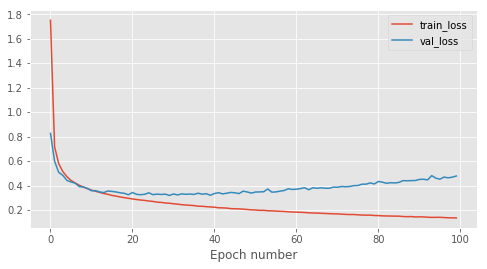

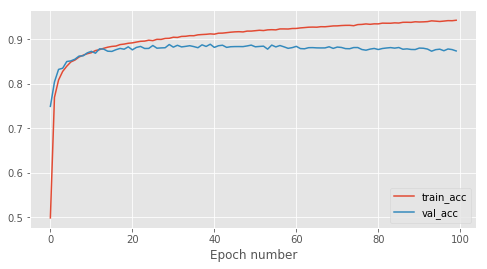

loss: 3.8505, accuracy: 0.0300:   1%|          | 10/1000 [00:00<00:09, 99.69it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 14, 14])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 3, 3])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3),

loss: 1.6334, accuracy: 0.5900:   2%|▏         | 16/1000 [00:00<00:11, 88.54it/s]

Epoch 0: train_acc_0.3431_train_loss_2.2601_val_acc_0.5562_val_loss_1.4599 epoch time 12.8251 seconds
total time0.0 : 12.825107097625732


loss: 1.0482, accuracy: 0.6700:   2%|▏         | 16/1000 [00:00<00:11, 86.09it/s]

Epoch 1: train_acc_0.6360_train_loss_1.1825_val_acc_0.6837_val_loss_1.0020 epoch time 13.4113 seconds
total time0.0 : 26.236433506011963


loss: 1.0844, accuracy: 0.7200:   2%|▏         | 16/1000 [00:00<00:11, 85.99it/s]

Epoch 2: train_acc_0.7155_train_loss_0.9071_val_acc_0.7377_val_loss_0.8276 epoch time 13.4278 seconds
total time0.0 : 39.664209842681885


loss: 0.5092, accuracy: 0.8300:   2%|▏         | 16/1000 [00:00<00:11, 88.03it/s]

Epoch 3: train_acc_0.7518_train_loss_0.7759_val_acc_0.7670_val_loss_0.7034 epoch time 13.4539 seconds
total time0.0 : 53.1180956363678


loss: 0.5003, accuracy: 0.8300:   2%|▏         | 16/1000 [00:00<00:11, 89.44it/s]

Epoch 4: train_acc_0.7765_train_loss_0.6936_val_acc_0.7787_val_loss_0.6750 epoch time 13.3319 seconds
total time1.0 : 6.449975490570068


loss: 0.5438, accuracy: 0.8400:   2%|▏         | 17/1000 [00:00<00:10, 90.40it/s]

Epoch 5: train_acc_0.7907_train_loss_0.6391_val_acc_0.7965_val_loss_0.6034 epoch time 13.3391 seconds
total time1.0 : 19.789109706878662


loss: 0.4276, accuracy: 0.8400:   2%|▏         | 16/1000 [00:00<00:11, 87.25it/s]

Epoch 6: train_acc_0.8033_train_loss_0.5978_val_acc_0.8071_val_loss_0.5819 epoch time 13.4803 seconds
total time1.0 : 33.269373655319214


loss: 0.6873, accuracy: 0.7900:   2%|▏         | 16/1000 [00:00<00:11, 88.17it/s]

Epoch 7: train_acc_0.8132_train_loss_0.5639_val_acc_0.8156_val_loss_0.5486 epoch time 13.3675 seconds
total time1.0 : 46.63691067695618


loss: 0.5351, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:11, 86.73it/s]

Epoch 8: train_acc_0.8211_train_loss_0.5361_val_acc_0.8216_val_loss_0.5342 epoch time 13.2803 seconds
total time1.0 : 59.91722130775452


loss: 0.4533, accuracy: 0.8300:   2%|▏         | 16/1000 [00:00<00:11, 89.19it/s]

Epoch 9: train_acc_0.8272_train_loss_0.5117_val_acc_0.8261_val_loss_0.5142 epoch time 13.4664 seconds
total time2.0 : 13.383618593215942


loss: 0.5952, accuracy: 0.8000:   2%|▏         | 16/1000 [00:00<00:11, 84.86it/s]

Epoch 10: train_acc_0.8329_train_loss_0.4911_val_acc_0.8331_val_loss_0.4923 epoch time 13.3667 seconds
total time2.0 : 26.750290393829346


loss: 0.3188, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 88.10it/s]

Epoch 11: train_acc_0.8386_train_loss_0.4726_val_acc_0.8416_val_loss_0.4658 epoch time 13.4389 seconds
total time2.0 : 40.18918538093567


loss: 0.4449, accuracy: 0.8600:   2%|▏         | 16/1000 [00:00<00:11, 84.27it/s]

Epoch 12: train_acc_0.8430_train_loss_0.4582_val_acc_0.8465_val_loss_0.4558 epoch time 13.3873 seconds
total time2.0 : 53.576521158218384


loss: 0.5325, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 90.42it/s]

Epoch 13: train_acc_0.8473_train_loss_0.4414_val_acc_0.8399_val_loss_0.4695 epoch time 13.4644 seconds
total time3.0 : 7.040942907333374


loss: 0.3472, accuracy: 0.8600:   2%|▏         | 16/1000 [00:00<00:11, 88.01it/s]

Epoch 14: train_acc_0.8507_train_loss_0.4309_val_acc_0.8525_val_loss_0.4344 epoch time 13.4356 seconds
total time3.0 : 20.476523399353027


loss: 0.3646, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 85.87it/s]

Epoch 15: train_acc_0.8547_train_loss_0.4184_val_acc_0.8476_val_loss_0.4453 epoch time 13.5146 seconds
total time3.0 : 33.991135120391846


loss: 0.1979, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 86.15it/s]

Epoch 16: train_acc_0.8558_train_loss_0.4113_val_acc_0.8513_val_loss_0.4307 epoch time 13.2350 seconds
total time3.0 : 47.22610640525818


loss: 0.4887, accuracy: 0.7900:   2%|▏         | 17/1000 [00:00<00:10, 89.85it/s]

Epoch 17: train_acc_0.8595_train_loss_0.3980_val_acc_0.8488_val_loss_0.4256 epoch time 13.3410 seconds
total time4.0 : 0.5670685768127441


loss: 0.4281, accuracy: 0.8500:   2%|▏         | 16/1000 [00:00<00:11, 87.33it/s]

Epoch 18: train_acc_0.8627_train_loss_0.3895_val_acc_0.8597_val_loss_0.4094 epoch time 12.8941 seconds
total time4.0 : 13.461183547973633


loss: 0.4237, accuracy: 0.8800:   2%|▏         | 16/1000 [00:00<00:11, 88.94it/s]

Epoch 19: train_acc_0.8644_train_loss_0.3810_val_acc_0.8609_val_loss_0.4066 epoch time 13.1506 seconds
total time4.0 : 26.61180019378662


loss: 0.2219, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 89.97it/s]

Epoch 20: train_acc_0.8666_train_loss_0.3750_val_acc_0.8585_val_loss_0.4048 epoch time 13.1821 seconds
total time4.0 : 39.793882846832275


loss: 0.4143, accuracy: 0.8300:   2%|▏         | 16/1000 [00:00<00:11, 87.44it/s]

Epoch 21: train_acc_0.8691_train_loss_0.3658_val_acc_0.8599_val_loss_0.3978 epoch time 13.1877 seconds
total time4.0 : 52.981555223464966


loss: 0.3340, accuracy: 0.8800:   2%|▏         | 16/1000 [00:00<00:11, 87.79it/s]

Epoch 22: train_acc_0.8716_train_loss_0.3583_val_acc_0.8583_val_loss_0.3988 epoch time 12.9156 seconds
total time5.0 : 5.897180080413818


loss: 0.2078, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:10, 91.09it/s]

Epoch 23: train_acc_0.8728_train_loss_0.3543_val_acc_0.8627_val_loss_0.3930 epoch time 13.1709 seconds
total time5.0 : 19.068115711212158


loss: 0.3179, accuracy: 0.8600:   2%|▏         | 17/1000 [00:00<00:10, 95.40it/s]

Epoch 24: train_acc_0.8743_train_loss_0.3489_val_acc_0.8560_val_loss_0.4115 epoch time 13.0679 seconds
total time5.0 : 32.13600707054138


loss: 0.2908, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 87.71it/s]

Epoch 25: train_acc_0.8763_train_loss_0.3426_val_acc_0.8656_val_loss_0.3889 epoch time 13.1290 seconds
total time5.0 : 45.264994859695435


loss: 0.2509, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 88.00it/s]

Epoch 26: train_acc_0.8783_train_loss_0.3349_val_acc_0.8654_val_loss_0.3843 epoch time 13.1077 seconds
total time5.0 : 58.372732162475586


loss: 0.2828, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 88.45it/s]

Epoch 27: train_acc_0.8792_train_loss_0.3312_val_acc_0.8669_val_loss_0.3879 epoch time 13.1643 seconds
total time6.0 : 11.5369873046875


loss: 0.3200, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 87.25it/s]

Epoch 28: train_acc_0.8812_train_loss_0.3253_val_acc_0.8617_val_loss_0.3866 epoch time 13.1241 seconds
total time6.0 : 24.66104292869568


loss: 0.2962, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 87.63it/s]

Epoch 29: train_acc_0.8828_train_loss_0.3203_val_acc_0.8649_val_loss_0.3872 epoch time 13.1401 seconds
total time6.0 : 37.8011109828949


loss: 0.2725, accuracy: 0.8800:   2%|▏         | 17/1000 [00:00<00:11, 89.27it/s]

Epoch 30: train_acc_0.8848_train_loss_0.3153_val_acc_0.8672_val_loss_0.3831 epoch time 13.1360 seconds
total time6.0 : 50.93714928627014


loss: 0.4521, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 86.42it/s]

Epoch 31: train_acc_0.8856_train_loss_0.3106_val_acc_0.8665_val_loss_0.3854 epoch time 13.1764 seconds
total time7.0 : 4.11353325843811


loss: 0.2727, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:11, 87.44it/s]

Epoch 32: train_acc_0.8870_train_loss_0.3075_val_acc_0.8659_val_loss_0.3845 epoch time 13.0595 seconds
total time7.0 : 17.1729998588562


loss: 0.4489, accuracy: 0.8500:   2%|▏         | 17/1000 [00:00<00:10, 90.10it/s]

Epoch 33: train_acc_0.8886_train_loss_0.3017_val_acc_0.8599_val_loss_0.3927 epoch time 13.2242 seconds
total time7.0 : 30.397176504135132


loss: 0.1884, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 89.51it/s]

Epoch 34: train_acc_0.8902_train_loss_0.2977_val_acc_0.8648_val_loss_0.3928 epoch time 13.1492 seconds
total time7.0 : 43.54640436172485


loss: 0.2829, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 87.56it/s]

Epoch 35: train_acc_0.8906_train_loss_0.2936_val_acc_0.8661_val_loss_0.3943 epoch time 13.1069 seconds
total time7.0 : 56.653321266174316


loss: 0.2929, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:11, 88.31it/s]

Epoch 36: train_acc_0.8915_train_loss_0.2898_val_acc_0.8670_val_loss_0.3844 epoch time 13.1018 seconds
total time8.0 : 9.755141973495483


loss: 0.3375, accuracy: 0.8600:   2%|▏         | 17/1000 [00:00<00:11, 87.83it/s]

Epoch 37: train_acc_0.8922_train_loss_0.2858_val_acc_0.8640_val_loss_0.3906 epoch time 13.1615 seconds
total time8.0 : 22.916648387908936


loss: 0.2662, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 88.43it/s]

Epoch 38: train_acc_0.8925_train_loss_0.2826_val_acc_0.8690_val_loss_0.3863 epoch time 13.1268 seconds
total time8.0 : 36.04349708557129


loss: 0.1978, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 88.52it/s]

Epoch 39: train_acc_0.8954_train_loss_0.2783_val_acc_0.8666_val_loss_0.3825 epoch time 13.1081 seconds
total time8.0 : 49.15161657333374


loss: 0.3357, accuracy: 0.8800:   2%|▏         | 17/1000 [00:00<00:11, 87.84it/s]

Epoch 40: train_acc_0.8965_train_loss_0.2736_val_acc_0.8715_val_loss_0.3811 epoch time 13.1339 seconds
total time9.0 : 2.285508155822754


loss: 0.3741, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 95.54it/s]

Epoch 41: train_acc_0.8976_train_loss_0.2712_val_acc_0.8713_val_loss_0.3810 epoch time 12.9779 seconds
total time9.0 : 15.263439178466797


loss: 0.1777, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 92.40it/s]

Epoch 42: train_acc_0.8977_train_loss_0.2669_val_acc_0.8651_val_loss_0.3885 epoch time 13.0138 seconds
total time9.0 : 28.27719235420227


loss: 0.2104, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:10, 89.73it/s]

Epoch 43: train_acc_0.8989_train_loss_0.2646_val_acc_0.8698_val_loss_0.3851 epoch time 13.1293 seconds
total time9.0 : 41.406479358673096


loss: 0.2799, accuracy: 0.8900:   2%|▏         | 17/1000 [00:00<00:10, 89.55it/s]

Epoch 44: train_acc_0.9000_train_loss_0.2608_val_acc_0.8698_val_loss_0.3807 epoch time 13.1308 seconds
total time9.0 : 54.53724217414856


loss: 0.2797, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 89.40it/s]

Epoch 45: train_acc_0.9008_train_loss_0.2582_val_acc_0.8708_val_loss_0.3882 epoch time 13.1150 seconds
total time10.0 : 7.652285099029541


loss: 0.3045, accuracy: 0.8600:   2%|▏         | 16/1000 [00:00<00:11, 87.81it/s]

Epoch 46: train_acc_0.9019_train_loss_0.2546_val_acc_0.8701_val_loss_0.3878 epoch time 13.0451 seconds
total time10.0 : 20.697389125823975


loss: 0.2043, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:11, 89.32it/s]

Epoch 47: train_acc_0.9029_train_loss_0.2522_val_acc_0.8672_val_loss_0.4013 epoch time 13.1850 seconds
total time10.0 : 33.88238835334778


loss: 0.3015, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 92.67it/s]

Epoch 48: train_acc_0.9048_train_loss_0.2490_val_acc_0.8647_val_loss_0.4011 epoch time 13.1315 seconds
total time10.0 : 47.013877868652344


loss: 0.1656, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 84.41it/s]

Epoch 49: train_acc_0.9039_train_loss_0.2473_val_acc_0.8673_val_loss_0.4054 epoch time 13.1615 seconds
total time11.0 : 0.17538809776306152


loss: 0.3317, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 88.25it/s]

Epoch 50: train_acc_0.9059_train_loss_0.2428_val_acc_0.8693_val_loss_0.3994 epoch time 13.0987 seconds
total time11.0 : 13.274095296859741


loss: 0.2135, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 85.41it/s]

Epoch 51: train_acc_0.9068_train_loss_0.2405_val_acc_0.8656_val_loss_0.4015 epoch time 13.0853 seconds
total time11.0 : 26.359354734420776


loss: 0.1860, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 86.84it/s]

Epoch 52: train_acc_0.9071_train_loss_0.2370_val_acc_0.8697_val_loss_0.3923 epoch time 13.1065 seconds
total time11.0 : 39.46582269668579


loss: 0.1393, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:11, 88.18it/s]

Epoch 53: train_acc_0.9084_train_loss_0.2350_val_acc_0.8689_val_loss_0.4023 epoch time 13.1222 seconds
total time11.0 : 52.58802247047424


loss: 0.1863, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:10, 89.83it/s]

Epoch 54: train_acc_0.9083_train_loss_0.2319_val_acc_0.8644_val_loss_0.4058 epoch time 13.0969 seconds
total time12.0 : 5.684938430786133


loss: 0.1894, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 87.50it/s]

Epoch 55: train_acc_0.9106_train_loss_0.2296_val_acc_0.8639_val_loss_0.4166 epoch time 13.2143 seconds
total time12.0 : 18.899288415908813


loss: 0.2050, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:10, 91.09it/s]

Epoch 56: train_acc_0.9102_train_loss_0.2268_val_acc_0.8664_val_loss_0.4138 epoch time 13.1431 seconds
total time12.0 : 32.04241442680359


loss: 0.1319, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 87.95it/s]

Epoch 57: train_acc_0.9108_train_loss_0.2251_val_acc_0.8706_val_loss_0.4002 epoch time 13.0762 seconds
total time12.0 : 45.11857509613037


loss: 0.1779, accuracy: 0.9400:   2%|▏         | 17/1000 [00:00<00:10, 92.16it/s]

Epoch 58: train_acc_0.9117_train_loss_0.2217_val_acc_0.8653_val_loss_0.4209 epoch time 13.0946 seconds
total time12.0 : 58.21321773529053


loss: 0.1683, accuracy: 0.9400:   2%|▏         | 17/1000 [00:00<00:10, 89.53it/s]

Epoch 59: train_acc_0.9131_train_loss_0.2184_val_acc_0.8698_val_loss_0.4075 epoch time 13.1414 seconds
total time13.0 : 11.354614019393921


loss: 0.1304, accuracy: 0.9500:   2%|▏         | 17/1000 [00:00<00:10, 91.33it/s]

Epoch 60: train_acc_0.9129_train_loss_0.2168_val_acc_0.8653_val_loss_0.4123 epoch time 13.1257 seconds
total time13.0 : 24.480308532714844


loss: 0.1442, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 87.47it/s]

Epoch 61: train_acc_0.9145_train_loss_0.2132_val_acc_0.8685_val_loss_0.4188 epoch time 13.1385 seconds
total time13.0 : 37.61883783340454


loss: 0.2030, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 87.23it/s]

Epoch 62: train_acc_0.9163_train_loss_0.2104_val_acc_0.8636_val_loss_0.4246 epoch time 13.0872 seconds
total time13.0 : 50.70608377456665


loss: 0.1511, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 86.34it/s]

Epoch 63: train_acc_0.9162_train_loss_0.2101_val_acc_0.8669_val_loss_0.4149 epoch time 13.1087 seconds
total time14.0 : 3.8147804737091064


loss: 0.2498, accuracy: 0.8500:   2%|▏         | 17/1000 [00:00<00:11, 89.10it/s]

Epoch 64: train_acc_0.9168_train_loss_0.2066_val_acc_0.8582_val_loss_0.4426 epoch time 13.0861 seconds
total time14.0 : 16.90087580680847


loss: 0.2315, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:11, 88.77it/s]

Epoch 65: train_acc_0.9166_train_loss_0.2059_val_acc_0.8637_val_loss_0.4245 epoch time 12.7309 seconds
total time14.0 : 29.63180136680603


loss: 0.2723, accuracy: 0.8800:   2%|▏         | 17/1000 [00:00<00:11, 88.18it/s]

Epoch 66: train_acc_0.9190_train_loss_0.2015_val_acc_0.8647_val_loss_0.4293 epoch time 13.1279 seconds
total time14.0 : 42.75973391532898


loss: 0.1347, accuracy: 0.9500:   2%|▏         | 17/1000 [00:00<00:11, 89.30it/s]

Epoch 67: train_acc_0.9182_train_loss_0.2002_val_acc_0.8636_val_loss_0.4437 epoch time 13.1303 seconds
total time14.0 : 55.8900785446167


loss: 0.2678, accuracy: 0.8600:   2%|▏         | 16/1000 [00:00<00:11, 88.44it/s]

Epoch 68: train_acc_0.9199_train_loss_0.1986_val_acc_0.8657_val_loss_0.4391 epoch time 13.0988 seconds
total time15.0 : 8.988866329193115


loss: 0.1945, accuracy: 0.9400:   2%|▏         | 17/1000 [00:00<00:10, 90.00it/s]

Epoch 69: train_acc_0.9209_train_loss_0.1956_val_acc_0.8670_val_loss_0.4358 epoch time 12.9120 seconds
total time15.0 : 21.90084481239319


loss: 0.2408, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:10, 91.13it/s]

Epoch 70: train_acc_0.9217_train_loss_0.1941_val_acc_0.8678_val_loss_0.4334 epoch time 13.0778 seconds
total time15.0 : 34.9786696434021


loss: 0.1577, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:11, 87.78it/s]

Epoch 71: train_acc_0.9225_train_loss_0.1921_val_acc_0.8643_val_loss_0.4465 epoch time 13.1529 seconds
total time15.0 : 48.13156819343567


loss: 0.1903, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 88.33it/s]

Epoch 72: train_acc_0.9228_train_loss_0.1897_val_acc_0.8637_val_loss_0.4501 epoch time 13.1321 seconds
total time16.0 : 1.2636780738830566


loss: 0.2424, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 87.57it/s]

Epoch 73: train_acc_0.9240_train_loss_0.1869_val_acc_0.8633_val_loss_0.4622 epoch time 13.1259 seconds
total time16.0 : 14.389626502990723


loss: 0.1543, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:11, 87.65it/s]

Epoch 74: train_acc_0.9249_train_loss_0.1861_val_acc_0.8563_val_loss_0.4658 epoch time 13.1024 seconds
total time16.0 : 27.492053031921387


loss: 0.1869, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 88.51it/s]

Epoch 75: train_acc_0.9255_train_loss_0.1830_val_acc_0.8652_val_loss_0.4621 epoch time 13.1515 seconds
total time16.0 : 40.64356565475464


loss: 0.1944, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:10, 89.99it/s]

Epoch 76: train_acc_0.9258_train_loss_0.1822_val_acc_0.8587_val_loss_0.4807 epoch time 13.0788 seconds
total time16.0 : 53.72238278388977


loss: 0.1420, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:11, 88.45it/s]

Epoch 77: train_acc_0.9257_train_loss_0.1801_val_acc_0.8618_val_loss_0.4788 epoch time 13.0890 seconds
total time17.0 : 6.811426401138306


loss: 0.1377, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 87.49it/s]

Epoch 78: train_acc_0.9260_train_loss_0.1793_val_acc_0.8668_val_loss_0.4738 epoch time 13.1144 seconds
total time17.0 : 19.92581844329834


loss: 0.2548, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:11, 88.49it/s]

Epoch 79: train_acc_0.9272_train_loss_0.1760_val_acc_0.8631_val_loss_0.4784 epoch time 13.1301 seconds
total time17.0 : 33.0558705329895


loss: 0.2592, accuracy: 0.8800:   2%|▏         | 16/1000 [00:00<00:11, 87.14it/s]

Epoch 80: train_acc_0.9282_train_loss_0.1748_val_acc_0.8615_val_loss_0.4870 epoch time 13.1178 seconds
total time17.0 : 46.17366862297058


loss: 0.1587, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 87.43it/s]

Epoch 81: train_acc_0.9273_train_loss_0.1756_val_acc_0.8639_val_loss_0.4725 epoch time 13.1342 seconds
total time17.0 : 59.30782604217529


loss: 0.1607, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 93.65it/s]

Epoch 82: train_acc_0.9295_train_loss_0.1708_val_acc_0.8658_val_loss_0.4899 epoch time 13.0958 seconds
total time18.0 : 12.403656005859375


loss: 0.2369, accuracy: 0.8800:   2%|▏         | 16/1000 [00:00<00:11, 87.29it/s]

Epoch 83: train_acc_0.9293_train_loss_0.1715_val_acc_0.8606_val_loss_0.4955 epoch time 13.1315 seconds
total time18.0 : 25.535158395767212


loss: 0.1763, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 88.09it/s]

Epoch 84: train_acc_0.9289_train_loss_0.1700_val_acc_0.8647_val_loss_0.4835 epoch time 13.0612 seconds
total time18.0 : 38.59637236595154


loss: 0.1309, accuracy: 0.9600:   2%|▏         | 17/1000 [00:00<00:11, 88.49it/s]

Epoch 85: train_acc_0.9304_train_loss_0.1671_val_acc_0.8611_val_loss_0.4995 epoch time 13.1925 seconds
total time18.0 : 51.78890085220337


loss: 0.1132, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 87.08it/s]

Epoch 86: train_acc_0.9317_train_loss_0.1653_val_acc_0.8613_val_loss_0.5021 epoch time 13.0926 seconds
total time19.0 : 4.881481170654297


loss: 0.1381, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:11, 88.69it/s]

Epoch 87: train_acc_0.9323_train_loss_0.1645_val_acc_0.8627_val_loss_0.4925 epoch time 13.1806 seconds
total time19.0 : 18.062082290649414


loss: 0.1429, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:11, 88.73it/s]

Epoch 88: train_acc_0.9323_train_loss_0.1627_val_acc_0.8583_val_loss_0.5096 epoch time 13.1322 seconds
total time19.0 : 31.19430375099182


loss: 0.2124, accuracy: 0.8900:   2%|▏         | 17/1000 [00:00<00:10, 91.90it/s]

Epoch 89: train_acc_0.9323_train_loss_0.1620_val_acc_0.8632_val_loss_0.4965 epoch time 12.7287 seconds
total time19.0 : 43.92298603057861


loss: 0.1107, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 89.38it/s]

Epoch 90: train_acc_0.9330_train_loss_0.1617_val_acc_0.8565_val_loss_0.5243 epoch time 13.0824 seconds
total time19.0 : 57.00543189048767


loss: 0.0947, accuracy: 0.9500:   2%|▏         | 17/1000 [00:00<00:10, 93.86it/s]

Epoch 91: train_acc_0.9347_train_loss_0.1575_val_acc_0.8627_val_loss_0.5070 epoch time 13.1355 seconds
total time20.0 : 10.140948057174683


loss: 0.1324, accuracy: 0.9600:   2%|▏         | 17/1000 [00:00<00:10, 90.56it/s]

Epoch 92: train_acc_0.9340_train_loss_0.1587_val_acc_0.8607_val_loss_0.5163 epoch time 12.9267 seconds
total time20.0 : 23.067643404006958


loss: 0.1209, accuracy: 0.9600:   2%|▏         | 17/1000 [00:00<00:10, 89.62it/s]

Epoch 93: train_acc_0.9353_train_loss_0.1565_val_acc_0.8592_val_loss_0.5354 epoch time 13.1120 seconds
total time20.0 : 36.17968988418579


loss: 0.0808, accuracy: 0.9800:   2%|▏         | 16/1000 [00:00<00:11, 87.64it/s]

Epoch 94: train_acc_0.9361_train_loss_0.1538_val_acc_0.8592_val_loss_0.5228 epoch time 13.1031 seconds
total time20.0 : 49.28275012969971


loss: 0.1549, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:10, 96.60it/s]

Epoch 95: train_acc_0.9361_train_loss_0.1535_val_acc_0.8554_val_loss_0.5489 epoch time 13.1808 seconds
total time21.0 : 2.4635229110717773


loss: 0.0927, accuracy: 0.9800:   2%|▏         | 17/1000 [00:00<00:10, 91.30it/s]

Epoch 96: train_acc_0.9361_train_loss_0.1538_val_acc_0.8625_val_loss_0.5284 epoch time 13.1967 seconds
total time21.0 : 15.660197496414185


loss: 0.1195, accuracy: 0.9600:   2%|▏         | 17/1000 [00:00<00:10, 93.58it/s]

Epoch 97: train_acc_0.9374_train_loss_0.1507_val_acc_0.8613_val_loss_0.5355 epoch time 13.0887 seconds
total time21.0 : 28.748863458633423


loss: 0.1189, accuracy: 0.9500:   2%|▏         | 17/1000 [00:00<00:10, 92.50it/s]

Epoch 98: train_acc_0.9373_train_loss_0.1500_val_acc_0.8603_val_loss_0.5480 epoch time 13.1373 seconds
total time21.0 : 41.88615870475769


loss: 0.3867, accuracy: 0.8200:  19%|█▉        | 30/158 [00:00<00:00, 156.30it/s]

Epoch 99: train_acc_0.9388_train_loss_0.1471_val_acc_0.8568_val_loss_0.5539 epoch time 13.1780 seconds
total time21.0 : 55.064183950424194
Generating test set evaluation metrics


loss: 0.3331, accuracy: 0.8900: 100%|██████████| 158/158 [00:01<00:00, 146.68it/s]


finish


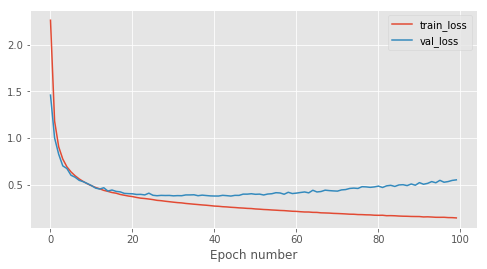

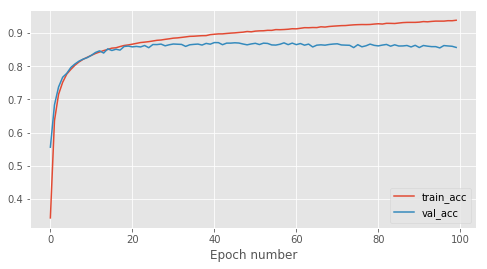

loss: 3.8514, accuracy: 0.0100:   2%|▏         | 16/1000 [00:00<00:09, 101.12it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 6, 6])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3),

loss: 2.1036, accuracy: 0.3200:   2%|▏         | 18/1000 [00:00<00:10, 97.98it/s]

Epoch 0: train_acc_0.2414_train_loss_2.6433_val_acc_0.3659_val_loss_2.1334 epoch time 12.0838 seconds
total time0.0 : 12.083846807479858


loss: 1.4511, accuracy: 0.5400:   2%|▏         | 18/1000 [00:00<00:10, 97.20it/s]

Epoch 1: train_acc_0.4651_train_loss_1.7884_val_acc_0.5385_val_loss_1.5169 epoch time 12.0875 seconds
total time0.0 : 24.171303749084473


loss: 1.1470, accuracy: 0.6500:   2%|▏         | 18/1000 [00:00<00:10, 95.45it/s]

Epoch 2: train_acc_0.5762_train_loss_1.3883_val_acc_0.6148_val_loss_1.2589 epoch time 12.1318 seconds
total time0.0 : 36.30310106277466


loss: 1.1850, accuracy: 0.6100:   2%|▏         | 18/1000 [00:00<00:10, 97.59it/s]

Epoch 3: train_acc_0.6309_train_loss_1.1934_val_acc_0.6400_val_loss_1.1629 epoch time 12.0902 seconds
total time0.0 : 48.39331889152527


loss: 0.8807, accuracy: 0.7300:   2%|▏         | 19/1000 [00:00<00:09, 104.07it/s]

Epoch 4: train_acc_0.6673_train_loss_1.0628_val_acc_0.6628_val_loss_1.0418 epoch time 12.1142 seconds
total time1.0 : 0.5074737071990967


loss: 0.9133, accuracy: 0.6900:   2%|▏         | 19/1000 [00:00<00:09, 102.04it/s]

Epoch 5: train_acc_0.6938_train_loss_0.9735_val_acc_0.7000_val_loss_0.9391 epoch time 12.0234 seconds
total time1.0 : 12.530879735946655


loss: 0.8213, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 97.01it/s]

Epoch 6: train_acc_0.7123_train_loss_0.9089_val_acc_0.7217_val_loss_0.8731 epoch time 12.0698 seconds
total time1.0 : 24.60064387321472


loss: 0.8349, accuracy: 0.7000:   2%|▏         | 18/1000 [00:00<00:10, 97.52it/s]

Epoch 7: train_acc_0.7280_train_loss_0.8530_val_acc_0.7340_val_loss_0.8362 epoch time 12.0754 seconds
total time1.0 : 36.67599678039551


loss: 0.8219, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:09, 99.78it/s] 

Epoch 8: train_acc_0.7412_train_loss_0.8090_val_acc_0.7482_val_loss_0.7851 epoch time 12.1052 seconds
total time1.0 : 48.78119659423828


loss: 0.8246, accuracy: 0.7100:   2%|▏         | 18/1000 [00:00<00:10, 97.50it/s]

Epoch 9: train_acc_0.7521_train_loss_0.7709_val_acc_0.7596_val_loss_0.7427 epoch time 12.0562 seconds
total time2.0 : 0.8373510837554932


loss: 0.7249, accuracy: 0.7600:   2%|▏         | 18/1000 [00:00<00:10, 97.85it/s]

Epoch 10: train_acc_0.7613_train_loss_0.7391_val_acc_0.7673_val_loss_0.7217 epoch time 12.0987 seconds
total time2.0 : 12.936036109924316


loss: 0.7803, accuracy: 0.7200:   2%|▏         | 19/1000 [00:00<00:10, 97.88it/s]

Epoch 11: train_acc_0.7685_train_loss_0.7144_val_acc_0.7697_val_loss_0.7047 epoch time 12.0471 seconds
total time2.0 : 24.983099222183228


loss: 0.7217, accuracy: 0.7300:   2%|▏         | 19/1000 [00:00<00:09, 98.79it/s]

Epoch 12: train_acc_0.7748_train_loss_0.6885_val_acc_0.7763_val_loss_0.6932 epoch time 12.0636 seconds
total time2.0 : 37.04667520523071


loss: 0.3990, accuracy: 0.8300:   2%|▏         | 20/1000 [00:00<00:09, 102.66it/s]

Epoch 13: train_acc_0.7811_train_loss_0.6679_val_acc_0.7753_val_loss_0.6851 epoch time 11.8477 seconds
total time2.0 : 48.89439129829407


loss: 0.6164, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 97.65it/s]

Epoch 14: train_acc_0.7862_train_loss_0.6505_val_acc_0.7912_val_loss_0.6481 epoch time 11.9467 seconds
total time3.0 : 0.841057538986206


loss: 0.4821, accuracy: 0.8600:   2%|▏         | 19/1000 [00:00<00:09, 104.13it/s]

Epoch 15: train_acc_0.7919_train_loss_0.6301_val_acc_0.7952_val_loss_0.6252 epoch time 12.1356 seconds
total time3.0 : 12.976679563522339


loss: 0.7637, accuracy: 0.7900:   2%|▏         | 19/1000 [00:00<00:09, 101.73it/s]

Epoch 16: train_acc_0.7959_train_loss_0.6142_val_acc_0.7932_val_loss_0.6227 epoch time 12.1055 seconds
total time3.0 : 25.082193613052368


loss: 0.5138, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:10, 96.40it/s]

Epoch 17: train_acc_0.7998_train_loss_0.5992_val_acc_0.7997_val_loss_0.6115 epoch time 11.8477 seconds
total time3.0 : 36.929879665374756


loss: 0.7257, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 96.29it/s]

Epoch 18: train_acc_0.8053_train_loss_0.5854_val_acc_0.8054_val_loss_0.5953 epoch time 12.1333 seconds
total time3.0 : 49.0631582736969


loss: 0.4415, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 96.29it/s]

Epoch 19: train_acc_0.8095_train_loss_0.5716_val_acc_0.8141_val_loss_0.5660 epoch time 12.1245 seconds
total time4.0 : 1.1876211166381836


loss: 0.4787, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 97.31it/s]

Epoch 20: train_acc_0.8115_train_loss_0.5597_val_acc_0.8115_val_loss_0.5670 epoch time 12.1063 seconds
total time4.0 : 13.29391622543335


loss: 0.4581, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 94.96it/s]

Epoch 21: train_acc_0.8163_train_loss_0.5485_val_acc_0.8101_val_loss_0.5769 epoch time 12.1134 seconds
total time4.0 : 25.407276153564453


loss: 0.5750, accuracy: 0.7800:   2%|▏         | 18/1000 [00:00<00:10, 97.62it/s]

Epoch 22: train_acc_0.8185_train_loss_0.5368_val_acc_0.8192_val_loss_0.5489 epoch time 12.1235 seconds
total time4.0 : 37.53079032897949


loss: 0.5405, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:09, 98.26it/s]

Epoch 23: train_acc_0.8228_train_loss_0.5241_val_acc_0.8204_val_loss_0.5364 epoch time 12.1055 seconds
total time4.0 : 49.63625144958496


loss: 0.4183, accuracy: 0.8300:   2%|▏         | 19/1000 [00:00<00:10, 96.84it/s]

Epoch 24: train_acc_0.8246_train_loss_0.5174_val_acc_0.8246_val_loss_0.5274 epoch time 12.1159 seconds
total time5.0 : 1.752182960510254


loss: 0.5558, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 98.00it/s]

Epoch 25: train_acc_0.8278_train_loss_0.5075_val_acc_0.8209_val_loss_0.5311 epoch time 12.0967 seconds
total time5.0 : 13.848840951919556


loss: 0.5280, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 98.03it/s]

Epoch 26: train_acc_0.8297_train_loss_0.4987_val_acc_0.8242_val_loss_0.5191 epoch time 12.0893 seconds
total time5.0 : 25.938178300857544


loss: 0.6228, accuracy: 0.7700:   2%|▏         | 18/1000 [00:00<00:10, 94.89it/s]

Epoch 27: train_acc_0.8319_train_loss_0.4909_val_acc_0.8280_val_loss_0.5139 epoch time 12.1454 seconds
total time5.0 : 38.083571672439575


loss: 0.2807, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 96.60it/s]

Epoch 28: train_acc_0.8348_train_loss_0.4835_val_acc_0.8291_val_loss_0.5180 epoch time 12.1630 seconds
total time5.0 : 50.24659538269043


loss: 0.3656, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 94.46it/s]

Epoch 29: train_acc_0.8371_train_loss_0.4769_val_acc_0.8313_val_loss_0.5034 epoch time 12.1510 seconds
total time6.0 : 2.397599458694458


loss: 0.3729, accuracy: 0.9000:   2%|▏         | 19/1000 [00:00<00:09, 100.49it/s]

Epoch 30: train_acc_0.8390_train_loss_0.4689_val_acc_0.8276_val_loss_0.5225 epoch time 12.1097 seconds
total time6.0 : 14.50725793838501


loss: 0.4853, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:09, 99.30it/s]

Epoch 31: train_acc_0.8406_train_loss_0.4651_val_acc_0.8338_val_loss_0.4946 epoch time 12.1488 seconds
total time6.0 : 26.656028032302856


loss: 0.5071, accuracy: 0.8200:   2%|▏         | 19/1000 [00:00<00:09, 104.04it/s]

Epoch 32: train_acc_0.8434_train_loss_0.4575_val_acc_0.8364_val_loss_0.4881 epoch time 12.1096 seconds
total time6.0 : 38.765663862228394


loss: 0.6088, accuracy: 0.7900:   2%|▏         | 19/1000 [00:00<00:09, 100.98it/s]

Epoch 33: train_acc_0.8438_train_loss_0.4529_val_acc_0.8342_val_loss_0.4975 epoch time 12.0743 seconds
total time6.0 : 50.840009689331055


loss: 0.7037, accuracy: 0.7300:   2%|▏         | 18/1000 [00:00<00:10, 95.83it/s]

Epoch 34: train_acc_0.8446_train_loss_0.4470_val_acc_0.8376_val_loss_0.4847 epoch time 12.1207 seconds
total time7.0 : 2.9607324600219727


loss: 0.4562, accuracy: 0.8800:   2%|▏         | 19/1000 [00:00<00:09, 104.37it/s]

Epoch 35: train_acc_0.8470_train_loss_0.4418_val_acc_0.8390_val_loss_0.4782 epoch time 12.0819 seconds
total time7.0 : 15.042602777481079


loss: 0.5072, accuracy: 0.7900:   2%|▏         | 18/1000 [00:00<00:09, 98.89it/s]

Epoch 36: train_acc_0.8493_train_loss_0.4362_val_acc_0.8352_val_loss_0.4838 epoch time 12.0332 seconds
total time7.0 : 27.075806617736816


loss: 0.3145, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:09, 99.47it/s]

Epoch 37: train_acc_0.8504_train_loss_0.4318_val_acc_0.8380_val_loss_0.4781 epoch time 12.0839 seconds
total time7.0 : 39.15970802307129


loss: 0.2921, accuracy: 0.8900:   2%|▏         | 19/1000 [00:00<00:09, 101.26it/s]

Epoch 38: train_acc_0.8521_train_loss_0.4278_val_acc_0.8434_val_loss_0.4669 epoch time 12.0596 seconds
total time7.0 : 51.21935486793518


loss: 0.4474, accuracy: 0.8400:   2%|▏         | 19/1000 [00:00<00:09, 100.77it/s]

Epoch 39: train_acc_0.8529_train_loss_0.4226_val_acc_0.8375_val_loss_0.4810 epoch time 11.8066 seconds
total time8.0 : 3.025965929031372


loss: 0.5161, accuracy: 0.8300:   2%|▏         | 19/1000 [00:00<00:09, 99.22it/s]

Epoch 40: train_acc_0.8539_train_loss_0.4179_val_acc_0.8408_val_loss_0.4746 epoch time 12.0323 seconds
total time8.0 : 15.058306217193604


loss: 0.4087, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 98.14it/s]

Epoch 41: train_acc_0.8560_train_loss_0.4142_val_acc_0.8433_val_loss_0.4606 epoch time 12.0173 seconds
total time8.0 : 27.07564067840576


loss: 0.2845, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 95.70it/s]

Epoch 42: train_acc_0.8573_train_loss_0.4087_val_acc_0.8437_val_loss_0.4631 epoch time 11.9406 seconds
total time8.0 : 39.01622176170349


loss: 0.4119, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 95.55it/s]

Epoch 43: train_acc_0.8579_train_loss_0.4056_val_acc_0.8469_val_loss_0.4562 epoch time 12.0706 seconds
total time8.0 : 51.08683753013611


loss: 0.3331, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 97.59it/s]

Epoch 44: train_acc_0.8583_train_loss_0.4022_val_acc_0.8457_val_loss_0.4555 epoch time 12.0338 seconds
total time9.0 : 3.120631456375122


loss: 0.2950, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 97.23it/s]

Epoch 45: train_acc_0.8601_train_loss_0.3985_val_acc_0.8403_val_loss_0.4618 epoch time 11.9934 seconds
total time9.0 : 15.114072799682617


loss: 0.2783, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 97.34it/s]

Epoch 46: train_acc_0.8607_train_loss_0.3953_val_acc_0.8451_val_loss_0.4625 epoch time 12.0425 seconds
total time9.0 : 27.1565523147583


loss: 0.3265, accuracy: 0.8700:   2%|▏         | 19/1000 [00:00<00:09, 99.44it/s]

Epoch 47: train_acc_0.8620_train_loss_0.3915_val_acc_0.8473_val_loss_0.4569 epoch time 12.0097 seconds
total time9.0 : 39.16622757911682


loss: 0.4886, accuracy: 0.8400:   2%|▏         | 19/1000 [00:00<00:09, 99.76it/s]

Epoch 48: train_acc_0.8634_train_loss_0.3885_val_acc_0.8458_val_loss_0.4478 epoch time 12.0059 seconds
total time9.0 : 51.172173500061035


loss: 0.4934, accuracy: 0.8000:   2%|▏         | 18/1000 [00:00<00:10, 97.17it/s]

Epoch 49: train_acc_0.8635_train_loss_0.3855_val_acc_0.8443_val_loss_0.4597 epoch time 11.9840 seconds
total time10.0 : 3.156186580657959


loss: 0.2691, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 98.14it/s]

Epoch 50: train_acc_0.8646_train_loss_0.3822_val_acc_0.8472_val_loss_0.4492 epoch time 12.0449 seconds
total time10.0 : 15.201127529144287


loss: 0.3017, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 95.99it/s]

Epoch 51: train_acc_0.8658_train_loss_0.3796_val_acc_0.8492_val_loss_0.4431 epoch time 12.0162 seconds
total time10.0 : 27.217312812805176


loss: 0.3802, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 97.09it/s]

Epoch 52: train_acc_0.8667_train_loss_0.3756_val_acc_0.8492_val_loss_0.4431 epoch time 12.0482 seconds
total time10.0 : 39.26551079750061


loss: 0.3682, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 97.44it/s]

Epoch 53: train_acc_0.8677_train_loss_0.3731_val_acc_0.8448_val_loss_0.4408 epoch time 12.0530 seconds
total time10.0 : 51.318479776382446


loss: 0.5902, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 97.45it/s]

Epoch 54: train_acc_0.8690_train_loss_0.3693_val_acc_0.8495_val_loss_0.4459 epoch time 12.0389 seconds
total time11.0 : 3.357344388961792


loss: 0.4210, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 97.05it/s]

Epoch 55: train_acc_0.8682_train_loss_0.3687_val_acc_0.8476_val_loss_0.4492 epoch time 11.9827 seconds
total time11.0 : 15.340035915374756


loss: 0.2570, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:09, 99.69it/s]

Epoch 56: train_acc_0.8702_train_loss_0.3651_val_acc_0.8490_val_loss_0.4433 epoch time 12.0262 seconds
total time11.0 : 27.366250038146973


loss: 0.3381, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:09, 99.03it/s]

Epoch 57: train_acc_0.8694_train_loss_0.3622_val_acc_0.8523_val_loss_0.4402 epoch time 11.9217 seconds
total time11.0 : 39.28797268867493


loss: 0.3884, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 95.11it/s]

Epoch 58: train_acc_0.8712_train_loss_0.3593_val_acc_0.8501_val_loss_0.4365 epoch time 11.9818 seconds
total time11.0 : 51.26980495452881


loss: 0.4480, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 96.89it/s]

Epoch 59: train_acc_0.8714_train_loss_0.3571_val_acc_0.8489_val_loss_0.4356 epoch time 11.9746 seconds
total time12.0 : 3.2444276809692383


loss: 0.4646, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 96.54it/s]

Epoch 60: train_acc_0.8720_train_loss_0.3539_val_acc_0.8453_val_loss_0.4626 epoch time 11.9880 seconds
total time12.0 : 15.232415199279785


loss: 0.3220, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 97.40it/s]

Epoch 61: train_acc_0.8735_train_loss_0.3526_val_acc_0.8503_val_loss_0.4367 epoch time 12.0222 seconds
total time12.0 : 27.2546329498291


loss: 0.2309, accuracy: 0.9100:   2%|▏         | 19/1000 [00:00<00:09, 100.48it/s]

Epoch 62: train_acc_0.8730_train_loss_0.3505_val_acc_0.8522_val_loss_0.4378 epoch time 11.9984 seconds
total time12.0 : 39.25305891036987


loss: 0.2786, accuracy: 0.8800:   2%|▏         | 19/1000 [00:00<00:09, 104.04it/s]

Epoch 63: train_acc_0.8743_train_loss_0.3477_val_acc_0.8526_val_loss_0.4345 epoch time 11.9872 seconds
total time12.0 : 51.24030566215515


loss: 0.4855, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:09, 98.80it/s]

Epoch 64: train_acc_0.8756_train_loss_0.3462_val_acc_0.8534_val_loss_0.4359 epoch time 12.0038 seconds
total time13.0 : 3.2440876960754395


loss: 0.2731, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:09, 99.21it/s]

Epoch 65: train_acc_0.8760_train_loss_0.3422_val_acc_0.8534_val_loss_0.4389 epoch time 11.8880 seconds
total time13.0 : 15.13210153579712


loss: 0.3422, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 96.04it/s]

Epoch 66: train_acc_0.8765_train_loss_0.3403_val_acc_0.8513_val_loss_0.4355 epoch time 12.0429 seconds
total time13.0 : 27.175040006637573


loss: 0.4682, accuracy: 0.8700:   2%|▏         | 19/1000 [00:00<00:10, 97.81it/s]

Epoch 67: train_acc_0.8775_train_loss_0.3390_val_acc_0.8530_val_loss_0.4285 epoch time 12.0000 seconds
total time13.0 : 39.17501664161682


loss: 0.2980, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 96.70it/s]

Epoch 68: train_acc_0.8772_train_loss_0.3363_val_acc_0.8529_val_loss_0.4351 epoch time 12.0113 seconds
total time13.0 : 51.186312198638916


loss: 0.4141, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 95.08it/s]

Epoch 69: train_acc_0.8786_train_loss_0.3329_val_acc_0.8492_val_loss_0.4385 epoch time 12.0215 seconds
total time14.0 : 3.207843542098999


loss: 0.2743, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 98.15it/s]

Epoch 70: train_acc_0.8790_train_loss_0.3324_val_acc_0.8527_val_loss_0.4330 epoch time 12.0089 seconds
total time14.0 : 15.216785907745361


loss: 0.2238, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 97.29it/s]

Epoch 71: train_acc_0.8796_train_loss_0.3302_val_acc_0.8528_val_loss_0.4358 epoch time 12.0553 seconds
total time14.0 : 27.272108793258667


loss: 0.3476, accuracy: 0.8700:   2%|▏         | 19/1000 [00:00<00:10, 96.83it/s]

Epoch 72: train_acc_0.8805_train_loss_0.3276_val_acc_0.8513_val_loss_0.4354 epoch time 12.0718 seconds
total time14.0 : 39.34394669532776


loss: 0.3602, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 94.83it/s]

Epoch 73: train_acc_0.8802_train_loss_0.3261_val_acc_0.8499_val_loss_0.4428 epoch time 12.0155 seconds
total time14.0 : 51.359440088272095


loss: 0.2916, accuracy: 0.8800:   2%|▏         | 19/1000 [00:00<00:09, 98.29it/s]

Epoch 74: train_acc_0.8806_train_loss_0.3245_val_acc_0.8516_val_loss_0.4413 epoch time 12.0700 seconds
total time15.0 : 3.4293925762176514


loss: 0.1876, accuracy: 0.9200:   2%|▏         | 19/1000 [00:00<00:09, 99.83it/s]

Epoch 75: train_acc_0.8824_train_loss_0.3222_val_acc_0.8546_val_loss_0.4435 epoch time 12.0477 seconds
total time15.0 : 15.477107524871826


loss: 0.2238, accuracy: 0.9200:   2%|▏         | 19/1000 [00:00<00:10, 97.96it/s]

Epoch 76: train_acc_0.8819_train_loss_0.3205_val_acc_0.8531_val_loss_0.4341 epoch time 12.0156 seconds
total time15.0 : 27.49271059036255


loss: 0.3542, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:10, 98.13it/s]

Epoch 77: train_acc_0.8833_train_loss_0.3184_val_acc_0.8550_val_loss_0.4363 epoch time 12.0052 seconds
total time15.0 : 39.49789595603943


loss: 0.3272, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:10, 97.44it/s]

Epoch 78: train_acc_0.8840_train_loss_0.3169_val_acc_0.8527_val_loss_0.4398 epoch time 12.0262 seconds
total time15.0 : 51.52408742904663


loss: 0.2440, accuracy: 0.9200:   2%|▏         | 19/1000 [00:00<00:09, 98.49it/s]

Epoch 79: train_acc_0.8831_train_loss_0.3162_val_acc_0.8537_val_loss_0.4316 epoch time 12.0058 seconds
total time16.0 : 3.5299174785614014


loss: 0.2953, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:09, 99.06it/s]

Epoch 80: train_acc_0.8847_train_loss_0.3145_val_acc_0.8557_val_loss_0.4322 epoch time 12.0317 seconds
total time16.0 : 15.561577320098877


loss: 0.2831, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:09, 99.48it/s]

Epoch 81: train_acc_0.8845_train_loss_0.3121_val_acc_0.8544_val_loss_0.4362 epoch time 12.0399 seconds
total time16.0 : 27.601447105407715


loss: 0.4509, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 96.27it/s]

Epoch 82: train_acc_0.8862_train_loss_0.3094_val_acc_0.8501_val_loss_0.4413 epoch time 12.0005 seconds
total time16.0 : 39.60192155838013


loss: 0.3209, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:09, 99.05it/s]

Epoch 83: train_acc_0.8852_train_loss_0.3083_val_acc_0.8540_val_loss_0.4355 epoch time 11.9754 seconds
total time16.0 : 51.57729721069336


loss: 0.3764, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 97.72it/s]

Epoch 84: train_acc_0.8864_train_loss_0.3074_val_acc_0.8532_val_loss_0.4405 epoch time 12.0714 seconds
total time17.0 : 3.6486968994140625


loss: 0.2679, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 96.39it/s]

Epoch 85: train_acc_0.8868_train_loss_0.3045_val_acc_0.8535_val_loss_0.4415 epoch time 11.9835 seconds
total time17.0 : 15.632181644439697


loss: 0.2833, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:09, 98.50it/s]

Epoch 86: train_acc_0.8882_train_loss_0.3037_val_acc_0.8530_val_loss_0.4413 epoch time 12.0017 seconds
total time17.0 : 27.633857488632202


loss: 0.2113, accuracy: 0.9400:   2%|▏         | 19/1000 [00:00<00:10, 97.54it/s]

Epoch 87: train_acc_0.8874_train_loss_0.3024_val_acc_0.8529_val_loss_0.4359 epoch time 11.9984 seconds
total time17.0 : 39.63221740722656


loss: 0.2890, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 98.13it/s]

Epoch 88: train_acc_0.8894_train_loss_0.2999_val_acc_0.8524_val_loss_0.4396 epoch time 12.0010 seconds
total time17.0 : 51.63321352005005


loss: 0.3382, accuracy: 0.8800:   2%|▏         | 19/1000 [00:00<00:10, 96.94it/s]

Epoch 89: train_acc_0.8895_train_loss_0.2986_val_acc_0.8517_val_loss_0.4389 epoch time 12.0129 seconds
total time18.0 : 3.646148681640625


loss: 0.3200, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:10, 97.28it/s]

Epoch 90: train_acc_0.8891_train_loss_0.2974_val_acc_0.8527_val_loss_0.4362 epoch time 12.0397 seconds
total time18.0 : 15.685848712921143


loss: 0.2239, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:09, 99.61it/s]

Epoch 91: train_acc_0.8900_train_loss_0.2964_val_acc_0.8536_val_loss_0.4429 epoch time 11.8956 seconds
total time18.0 : 27.581426858901978


loss: 0.3735, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:09, 98.48it/s]

Epoch 92: train_acc_0.8898_train_loss_0.2945_val_acc_0.8557_val_loss_0.4415 epoch time 12.1055 seconds
total time18.0 : 39.6869683265686


loss: 0.2145, accuracy: 0.9400:   2%|▏         | 18/1000 [00:00<00:09, 99.70it/s]

Epoch 93: train_acc_0.8912_train_loss_0.2925_val_acc_0.8520_val_loss_0.4456 epoch time 11.9578 seconds
total time18.0 : 51.64475202560425


loss: 0.3745, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:09, 98.84it/s]

Epoch 94: train_acc_0.8917_train_loss_0.2925_val_acc_0.8541_val_loss_0.4466 epoch time 12.0890 seconds
total time19.0 : 3.7337112426757812


loss: 0.1928, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 94.24it/s]

Epoch 95: train_acc_0.8923_train_loss_0.2896_val_acc_0.8523_val_loss_0.4412 epoch time 12.0078 seconds
total time19.0 : 15.74151873588562


loss: 0.2929, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:09, 98.95it/s]

Epoch 96: train_acc_0.8932_train_loss_0.2882_val_acc_0.8540_val_loss_0.4433 epoch time 12.0586 seconds
total time19.0 : 27.800155639648438


loss: 0.2531, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:09, 98.75it/s]

Epoch 97: train_acc_0.8924_train_loss_0.2871_val_acc_0.8513_val_loss_0.4530 epoch time 12.0138 seconds
total time19.0 : 39.81395602226257


loss: 0.2974, accuracy: 0.8700:   2%|▏         | 19/1000 [00:00<00:10, 97.95it/s]

Epoch 98: train_acc_0.8926_train_loss_0.2860_val_acc_0.8508_val_loss_0.4505 epoch time 12.0717 seconds
total time19.0 : 51.88568449020386


loss: 0.5579, accuracy: 0.8900:  20%|█▉        | 31/158 [00:00<00:00, 164.17it/s]

Epoch 99: train_acc_0.8927_train_loss_0.2849_val_acc_0.8506_val_loss_0.4586 epoch time 12.0356 seconds
total time20.0 : 3.921269655227661
Generating test set evaluation metrics


loss: 0.4498, accuracy: 0.8100: 100%|██████████| 158/158 [00:01<00:00, 152.00it/s]


finish


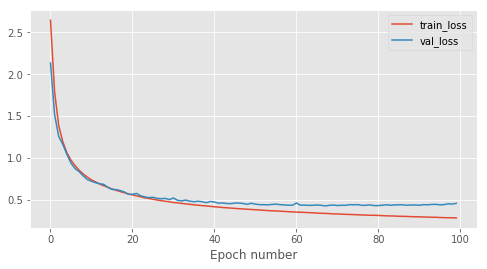

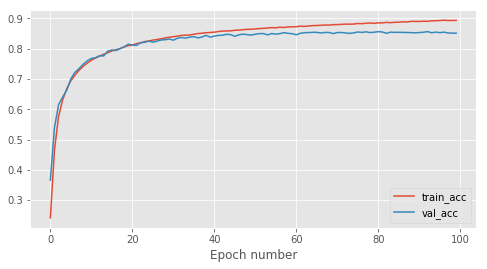

loss: 3.8506, accuracy: 0.0200:   2%|▏         | 19/1000 [00:00<00:08, 111.79it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), s

loss: 3.6525, accuracy: 0.0500:   2%|▏         | 20/1000 [00:00<00:09, 108.04it/s]

Epoch 0: train_acc_0.0415_train_loss_3.7004_val_acc_0.0440_val_loss_3.6717 epoch time 11.0884 seconds
total time0.0 : 11.08840560913086


loss: 3.5659, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 105.74it/s]

Epoch 1: train_acc_0.0537_train_loss_3.6393_val_acc_0.0554_val_loss_3.5924 epoch time 11.0341 seconds
total time0.0 : 22.122516870498657


loss: 3.6066, accuracy: 0.0600:   2%|▏         | 20/1000 [00:00<00:09, 106.24it/s]

Epoch 2: train_acc_0.0654_train_loss_3.5261_val_acc_0.0690_val_loss_3.4918 epoch time 11.1138 seconds
total time0.0 : 33.23634076118469


loss: 3.4315, accuracy: 0.1000:   2%|▏         | 20/1000 [00:00<00:09, 103.87it/s]

Epoch 3: train_acc_0.0737_train_loss_3.4679_val_acc_0.0756_val_loss_3.4681 epoch time 11.0111 seconds
total time0.0 : 44.2474582195282


loss: 3.3677, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 107.28it/s]

Epoch 4: train_acc_0.0794_train_loss_3.4362_val_acc_0.0791_val_loss_3.4216 epoch time 11.0760 seconds
total time0.0 : 55.323437452316284


loss: 3.4820, accuracy: 0.0600:   2%|▏         | 20/1000 [00:00<00:09, 108.89it/s]

Epoch 5: train_acc_0.0846_train_loss_3.4000_val_acc_0.0849_val_loss_3.3936 epoch time 11.0016 seconds
total time1.0 : 6.325051784515381


loss: 3.2340, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 105.67it/s]

Epoch 6: train_acc_0.0886_train_loss_3.3708_val_acc_0.0873_val_loss_3.3723 epoch time 11.1114 seconds
total time1.0 : 17.436465740203857


loss: 3.2707, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 107.59it/s]

Epoch 7: train_acc_0.0939_train_loss_3.3467_val_acc_0.0923_val_loss_3.3410 epoch time 11.0546 seconds
total time1.0 : 28.491097927093506


loss: 3.2487, accuracy: 0.1300:   2%|▏         | 21/1000 [00:00<00:09, 107.72it/s]

Epoch 8: train_acc_0.0972_train_loss_3.3279_val_acc_0.0903_val_loss_3.3306 epoch time 11.0950 seconds
total time1.0 : 39.5861279964447


loss: 3.3613, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 105.21it/s]

Epoch 9: train_acc_0.0996_train_loss_3.3092_val_acc_0.0975_val_loss_3.3040 epoch time 11.0325 seconds
total time1.0 : 50.61865758895874


loss: 3.3077, accuracy: 0.0600:   2%|▏         | 21/1000 [00:00<00:08, 110.29it/s]

Epoch 10: train_acc_0.1023_train_loss_3.2889_val_acc_0.0994_val_loss_3.2844 epoch time 11.0737 seconds
total time2.0 : 1.6923503875732422


loss: 3.0914, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 105.14it/s]

Epoch 11: train_acc_0.1062_train_loss_3.2702_val_acc_0.0999_val_loss_3.2678 epoch time 11.0511 seconds
total time2.0 : 12.74345588684082


loss: 3.3327, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 107.04it/s]

Epoch 12: train_acc_0.1083_train_loss_3.2539_val_acc_0.1045_val_loss_3.2526 epoch time 11.1428 seconds
total time2.0 : 23.88623046875


loss: 3.0988, accuracy: 0.1200:   2%|▏         | 20/1000 [00:00<00:09, 106.25it/s]

Epoch 13: train_acc_0.1121_train_loss_3.2388_val_acc_0.1064_val_loss_3.2418 epoch time 11.0166 seconds
total time2.0 : 34.90286421775818


loss: 3.1389, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 108.15it/s]

Epoch 14: train_acc_0.1144_train_loss_3.2191_val_acc_0.1143_val_loss_3.2160 epoch time 11.0945 seconds
total time2.0 : 45.99735474586487


loss: 3.2056, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 108.41it/s]

Epoch 15: train_acc_0.1182_train_loss_3.1987_val_acc_0.1145_val_loss_3.2094 epoch time 10.9854 seconds
total time2.0 : 56.98270845413208


loss: 3.3028, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 107.12it/s]

Epoch 16: train_acc_0.1216_train_loss_3.1824_val_acc_0.1199_val_loss_3.1858 epoch time 11.0481 seconds
total time3.0 : 8.030776500701904


loss: 3.1661, accuracy: 0.1300:   2%|▏         | 21/1000 [00:00<00:09, 106.57it/s]

Epoch 17: train_acc_0.1232_train_loss_3.1689_val_acc_0.1211_val_loss_3.1715 epoch time 10.9870 seconds
total time3.0 : 19.017822265625


loss: 3.1014, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 107.13it/s]

Epoch 18: train_acc_0.1262_train_loss_3.1568_val_acc_0.1258_val_loss_3.1567 epoch time 11.0503 seconds
total time3.0 : 30.068074703216553


loss: 3.1675, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 106.89it/s]

Epoch 19: train_acc_0.1291_train_loss_3.1443_val_acc_0.1284_val_loss_3.1522 epoch time 11.0098 seconds
total time3.0 : 41.07782983779907


loss: 3.3509, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 106.32it/s]

Epoch 20: train_acc_0.1306_train_loss_3.1334_val_acc_0.1291_val_loss_3.1358 epoch time 11.0939 seconds
total time3.0 : 52.17176842689514


loss: 3.1268, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 105.59it/s]

Epoch 21: train_acc_0.1327_train_loss_3.1247_val_acc_0.1327_val_loss_3.1248 epoch time 10.9802 seconds
total time4.0 : 3.15200138092041


loss: 3.0413, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 107.67it/s]

Epoch 22: train_acc_0.1344_train_loss_3.1135_val_acc_0.1324_val_loss_3.1145 epoch time 11.0678 seconds
total time4.0 : 14.219841480255127


loss: 3.1365, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 107.62it/s]

Epoch 23: train_acc_0.1379_train_loss_3.1049_val_acc_0.1364_val_loss_3.1012 epoch time 11.0138 seconds
total time4.0 : 25.233661651611328


loss: 3.0419, accuracy: 0.1500:   2%|▏         | 21/1000 [00:00<00:08, 111.15it/s]

Epoch 24: train_acc_0.1376_train_loss_3.0966_val_acc_0.1396_val_loss_3.1055 epoch time 11.1054 seconds
total time4.0 : 36.33904147148132


loss: 2.9956, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 106.33it/s]

Epoch 25: train_acc_0.1392_train_loss_3.0885_val_acc_0.1439_val_loss_3.0887 epoch time 11.0499 seconds
total time4.0 : 47.388983964920044


loss: 3.0852, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:08, 109.58it/s]

Epoch 26: train_acc_0.1411_train_loss_3.0803_val_acc_0.1421_val_loss_3.0782 epoch time 11.0821 seconds
total time4.0 : 58.47103810310364


loss: 3.0968, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 107.81it/s]

Epoch 27: train_acc_0.1432_train_loss_3.0734_val_acc_0.1410_val_loss_3.0728 epoch time 11.0018 seconds
total time5.0 : 9.472874641418457


loss: 3.1087, accuracy: 0.1500:   2%|▏         | 21/1000 [00:00<00:08, 109.93it/s]

Epoch 28: train_acc_0.1443_train_loss_3.0684_val_acc_0.1444_val_loss_3.0704 epoch time 11.1186 seconds
total time5.0 : 20.591424703598022


loss: 2.9872, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 107.51it/s]

Epoch 29: train_acc_0.1468_train_loss_3.0626_val_acc_0.1466_val_loss_3.0655 epoch time 11.0456 seconds
total time5.0 : 31.63698697090149


loss: 3.0625, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 105.92it/s]

Epoch 30: train_acc_0.1460_train_loss_3.0580_val_acc_0.1472_val_loss_3.0539 epoch time 11.0844 seconds
total time5.0 : 42.72143507003784


loss: 3.0718, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 106.58it/s]

Epoch 31: train_acc_0.1483_train_loss_3.0514_val_acc_0.1489_val_loss_3.0521 epoch time 11.0385 seconds
total time5.0 : 53.75994515419006


loss: 3.0550, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 106.23it/s]

Epoch 32: train_acc_0.1483_train_loss_3.0465_val_acc_0.1495_val_loss_3.0549 epoch time 11.0935 seconds
total time6.0 : 4.853432655334473


loss: 3.0355, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 108.62it/s]

Epoch 33: train_acc_0.1489_train_loss_3.0417_val_acc_0.1504_val_loss_3.0469 epoch time 10.9780 seconds
total time6.0 : 15.83145809173584


loss: 3.1881, accuracy: 0.1000:   2%|▏         | 20/1000 [00:00<00:09, 107.50it/s]

Epoch 34: train_acc_0.1509_train_loss_3.0373_val_acc_0.1511_val_loss_3.0415 epoch time 11.0627 seconds
total time6.0 : 26.894142389297485


loss: 3.0539, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 106.17it/s]

Epoch 35: train_acc_0.1508_train_loss_3.0330_val_acc_0.1513_val_loss_3.0358 epoch time 10.9668 seconds
total time6.0 : 37.86090159416199


loss: 3.0481, accuracy: 0.1000:   2%|▏         | 20/1000 [00:00<00:09, 107.22it/s]

Epoch 36: train_acc_0.1519_train_loss_3.0280_val_acc_0.1532_val_loss_3.0281 epoch time 11.0500 seconds
total time6.0 : 48.91090178489685


loss: 3.0572, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 107.82it/s]

Epoch 37: train_acc_0.1531_train_loss_3.0244_val_acc_0.1511_val_loss_3.0251 epoch time 10.9980 seconds
total time6.0 : 59.90887975692749


loss: 2.9393, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 107.34it/s]

Epoch 38: train_acc_0.1534_train_loss_3.0197_val_acc_0.1513_val_loss_3.0268 epoch time 11.1264 seconds
total time7.0 : 11.035237789154053


loss: 2.9550, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 105.76it/s]

Epoch 39: train_acc_0.1552_train_loss_3.0187_val_acc_0.1509_val_loss_3.0260 epoch time 10.9928 seconds
total time7.0 : 22.02803635597229


loss: 3.1007, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 106.94it/s]

Epoch 40: train_acc_0.1553_train_loss_3.0125_val_acc_0.1554_val_loss_3.0139 epoch time 11.1227 seconds
total time7.0 : 33.15075063705444


loss: 2.9862, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 104.72it/s]

Epoch 41: train_acc_0.1568_train_loss_3.0102_val_acc_0.1528_val_loss_3.0146 epoch time 11.0370 seconds
total time7.0 : 44.18778443336487


loss: 3.1138, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 108.30it/s]

Epoch 42: train_acc_0.1570_train_loss_3.0070_val_acc_0.1566_val_loss_3.0059 epoch time 11.1077 seconds
total time7.0 : 55.29545259475708


loss: 3.0051, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 104.55it/s]

Epoch 43: train_acc_0.1573_train_loss_3.0044_val_acc_0.1557_val_loss_3.0088 epoch time 11.0058 seconds
total time8.0 : 6.3012707233428955


loss: 2.9718, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 105.76it/s]

Epoch 44: train_acc_0.1571_train_loss_3.0013_val_acc_0.1553_val_loss_3.0050 epoch time 11.1158 seconds
total time8.0 : 17.417089462280273


loss: 2.9534, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 106.33it/s]

Epoch 45: train_acc_0.1581_train_loss_2.9987_val_acc_0.1591_val_loss_3.0017 epoch time 11.0057 seconds
total time8.0 : 28.42279577255249


loss: 2.8622, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 107.08it/s]

Epoch 46: train_acc_0.1587_train_loss_2.9965_val_acc_0.1589_val_loss_3.0011 epoch time 11.0525 seconds
total time8.0 : 39.47529363632202


loss: 2.9723, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 106.79it/s]

Epoch 47: train_acc_0.1593_train_loss_2.9941_val_acc_0.1580_val_loss_3.0158 epoch time 11.0344 seconds
total time8.0 : 50.509663105010986


loss: 3.1642, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 106.77it/s]

Epoch 48: train_acc_0.1592_train_loss_2.9905_val_acc_0.1589_val_loss_2.9947 epoch time 11.0951 seconds
total time9.0 : 1.6047327518463135


loss: 2.8784, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 106.93it/s]

Epoch 49: train_acc_0.1596_train_loss_2.9883_val_acc_0.1585_val_loss_2.9894 epoch time 11.0607 seconds
total time9.0 : 12.665448665618896


loss: 2.8590, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 108.08it/s]

Epoch 50: train_acc_0.1609_train_loss_2.9860_val_acc_0.1584_val_loss_2.9915 epoch time 11.1006 seconds
total time9.0 : 23.76605224609375


loss: 3.0781, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 105.74it/s]

Epoch 51: train_acc_0.1615_train_loss_2.9833_val_acc_0.1596_val_loss_2.9905 epoch time 11.0239 seconds
total time9.0 : 34.78993821144104


loss: 3.0049, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:08, 109.15it/s]

Epoch 52: train_acc_0.1613_train_loss_2.9816_val_acc_0.1606_val_loss_2.9916 epoch time 11.1146 seconds
total time9.0 : 45.904540061950684


loss: 2.9869, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 108.78it/s]

Epoch 53: train_acc_0.1609_train_loss_2.9785_val_acc_0.1590_val_loss_2.9879 epoch time 11.0424 seconds
total time9.0 : 56.946985483169556


loss: 3.0624, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 108.40it/s]

Epoch 54: train_acc_0.1629_train_loss_2.9767_val_acc_0.1596_val_loss_2.9839 epoch time 11.1131 seconds
total time10.0 : 8.060102701187134


loss: 2.8510, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 104.97it/s]

Epoch 55: train_acc_0.1618_train_loss_2.9752_val_acc_0.1614_val_loss_2.9893 epoch time 11.0609 seconds
total time10.0 : 19.12098526954651


loss: 2.9296, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 107.53it/s]

Epoch 56: train_acc_0.1623_train_loss_2.9730_val_acc_0.1580_val_loss_2.9821 epoch time 11.0829 seconds
total time10.0 : 30.20388913154602


loss: 2.8390, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 105.02it/s]

Epoch 57: train_acc_0.1636_train_loss_2.9716_val_acc_0.1613_val_loss_2.9767 epoch time 11.0217 seconds
total time10.0 : 41.22554874420166


loss: 2.9295, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 107.64it/s]

Epoch 58: train_acc_0.1625_train_loss_2.9698_val_acc_0.1632_val_loss_2.9742 epoch time 11.0869 seconds
total time10.0 : 52.3124725818634


loss: 2.9598, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:08, 109.55it/s]

Epoch 59: train_acc_0.1633_train_loss_2.9678_val_acc_0.1663_val_loss_2.9762 epoch time 11.0127 seconds
total time11.0 : 3.3252038955688477


loss: 3.1350, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:08, 109.25it/s]

Epoch 60: train_acc_0.1640_train_loss_2.9666_val_acc_0.1642_val_loss_2.9764 epoch time 11.1353 seconds
total time11.0 : 14.460480213165283


loss: 3.0652, accuracy: 0.1000:   2%|▏         | 20/1000 [00:00<00:09, 106.56it/s]

Epoch 61: train_acc_0.1638_train_loss_2.9628_val_acc_0.1650_val_loss_2.9688 epoch time 11.0561 seconds
total time11.0 : 25.516589879989624


loss: 3.0246, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 106.72it/s]

Epoch 62: train_acc_0.1655_train_loss_2.9625_val_acc_0.1647_val_loss_2.9725 epoch time 11.1094 seconds
total time11.0 : 36.62599802017212


loss: 3.0829, accuracy: 0.1200:   2%|▏         | 20/1000 [00:00<00:09, 106.45it/s]

Epoch 63: train_acc_0.1642_train_loss_2.9611_val_acc_0.1618_val_loss_2.9776 epoch time 11.0035 seconds
total time11.0 : 47.62946820259094


loss: 2.8391, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:08, 109.49it/s]

Epoch 64: train_acc_0.1652_train_loss_2.9595_val_acc_0.1637_val_loss_2.9685 epoch time 11.1015 seconds
total time11.0 : 58.7309684753418


loss: 3.0190, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 103.77it/s]

Epoch 65: train_acc_0.1652_train_loss_2.9584_val_acc_0.1646_val_loss_2.9592 epoch time 11.0833 seconds
total time12.0 : 9.814297437667847


loss: 2.7817, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 105.81it/s]

Epoch 66: train_acc_0.1654_train_loss_2.9560_val_acc_0.1673_val_loss_2.9663 epoch time 11.1408 seconds
total time12.0 : 20.955058813095093


loss: 2.9303, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 106.23it/s]

Epoch 67: train_acc_0.1668_train_loss_2.9555_val_acc_0.1671_val_loss_2.9596 epoch time 11.0334 seconds
total time12.0 : 31.9884672164917


loss: 2.8603, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 105.41it/s]

Epoch 68: train_acc_0.1675_train_loss_2.9535_val_acc_0.1654_val_loss_2.9622 epoch time 11.1165 seconds
total time12.0 : 43.10498356819153


loss: 2.8787, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 104.91it/s]

Epoch 69: train_acc_0.1664_train_loss_2.9526_val_acc_0.1609_val_loss_2.9681 epoch time 11.0798 seconds
total time12.0 : 54.18480896949768


loss: 3.0043, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 106.63it/s]

Epoch 70: train_acc_0.1662_train_loss_2.9519_val_acc_0.1676_val_loss_2.9573 epoch time 11.1298 seconds
total time13.0 : 5.31462836265564


loss: 3.0927, accuracy: 0.1100:   2%|▏         | 19/1000 [00:00<00:09, 104.82it/s]

Epoch 71: train_acc_0.1669_train_loss_2.9493_val_acc_0.1675_val_loss_2.9603 epoch time 11.0680 seconds
total time13.0 : 16.38265299797058


loss: 3.1051, accuracy: 0.1000:   2%|▏         | 20/1000 [00:00<00:09, 107.13it/s]

Epoch 72: train_acc_0.1676_train_loss_2.9477_val_acc_0.1636_val_loss_2.9572 epoch time 11.1978 seconds
total time13.0 : 27.580495834350586


loss: 2.9020, accuracy: 0.1300:   2%|▏         | 19/1000 [00:00<00:09, 101.81it/s]

Epoch 73: train_acc_0.1678_train_loss_2.9472_val_acc_0.1687_val_loss_2.9528 epoch time 11.0841 seconds
total time13.0 : 38.66456866264343


loss: 2.9274, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 105.32it/s]

Epoch 74: train_acc_0.1669_train_loss_2.9457_val_acc_0.1665_val_loss_2.9511 epoch time 11.0641 seconds
total time13.0 : 49.72865009307861


loss: 2.9331, accuracy: 0.2000:   2%|▏         | 19/1000 [00:00<00:09, 104.49it/s]

Epoch 75: train_acc_0.1688_train_loss_2.9445_val_acc_0.1691_val_loss_2.9543 epoch time 11.0333 seconds
total time14.0 : 0.7619867324829102


loss: 3.0487, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 107.30it/s]

Epoch 76: train_acc_0.1688_train_loss_2.9437_val_acc_0.1679_val_loss_2.9514 epoch time 11.1878 seconds
total time14.0 : 11.949767589569092


loss: 2.9008, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 104.51it/s]

Epoch 77: train_acc_0.1681_train_loss_2.9419_val_acc_0.1686_val_loss_2.9639 epoch time 11.0876 seconds
total time14.0 : 23.03739094734192


loss: 2.9123, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 106.92it/s]

Epoch 78: train_acc_0.1683_train_loss_2.9408_val_acc_0.1705_val_loss_2.9571 epoch time 11.0859 seconds
total time14.0 : 34.12325644493103


loss: 2.9226, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 104.42it/s]

Epoch 79: train_acc_0.1689_train_loss_2.9398_val_acc_0.1595_val_loss_2.9491 epoch time 11.0942 seconds
total time14.0 : 45.217451333999634


loss: 2.8975, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 107.65it/s]

Epoch 80: train_acc_0.1692_train_loss_2.9390_val_acc_0.1682_val_loss_2.9533 epoch time 11.1411 seconds
total time14.0 : 56.35858917236328


loss: 3.0424, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 105.47it/s]

Epoch 81: train_acc_0.1704_train_loss_2.9380_val_acc_0.1700_val_loss_2.9446 epoch time 11.0207 seconds
total time15.0 : 7.379294395446777


loss: 3.0034, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 104.96it/s]

Epoch 82: train_acc_0.1703_train_loss_2.9353_val_acc_0.1684_val_loss_2.9532 epoch time 11.0715 seconds
total time15.0 : 18.45078682899475


loss: 2.9079, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 108.05it/s]

Epoch 83: train_acc_0.1696_train_loss_2.9354_val_acc_0.1697_val_loss_2.9474 epoch time 11.0381 seconds
total time15.0 : 29.488861799240112


loss: 2.8396, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 107.20it/s]

Epoch 84: train_acc_0.1702_train_loss_2.9338_val_acc_0.1689_val_loss_2.9468 epoch time 11.1178 seconds
total time15.0 : 40.60663342475891


loss: 2.7629, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 105.71it/s]

Epoch 85: train_acc_0.1705_train_loss_2.9340_val_acc_0.1727_val_loss_2.9416 epoch time 11.0096 seconds
total time15.0 : 51.616254568099976


loss: 2.9426, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 106.19it/s]

Epoch 86: train_acc_0.1694_train_loss_2.9317_val_acc_0.1699_val_loss_2.9398 epoch time 11.0536 seconds
total time16.0 : 2.6698522567749023


loss: 2.9724, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 103.94it/s]

Epoch 87: train_acc_0.1702_train_loss_2.9303_val_acc_0.1709_val_loss_2.9400 epoch time 10.9848 seconds
total time16.0 : 13.654677867889404


loss: 2.8076, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:08, 109.30it/s]

Epoch 88: train_acc_0.1701_train_loss_2.9303_val_acc_0.1713_val_loss_2.9431 epoch time 11.1001 seconds
total time16.0 : 24.754825830459595


loss: 2.8220, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 107.05it/s]

Epoch 89: train_acc_0.1702_train_loss_2.9297_val_acc_0.1585_val_loss_2.9546 epoch time 11.0293 seconds
total time16.0 : 35.784080505371094


loss: 2.9778, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 107.29it/s]

Epoch 90: train_acc_0.1703_train_loss_2.9281_val_acc_0.1715_val_loss_2.9490 epoch time 11.1158 seconds
total time16.0 : 46.899879455566406


loss: 2.9467, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 106.78it/s]

Epoch 91: train_acc_0.1721_train_loss_2.9273_val_acc_0.1659_val_loss_2.9399 epoch time 10.9987 seconds
total time16.0 : 57.89856719970703


loss: 2.7352, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 108.12it/s]

Epoch 92: train_acc_0.1726_train_loss_2.9263_val_acc_0.1702_val_loss_2.9365 epoch time 11.1108 seconds
total time17.0 : 9.009374380111694


loss: 3.1451, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 107.57it/s]

Epoch 93: train_acc_0.1713_train_loss_2.9256_val_acc_0.1704_val_loss_2.9441 epoch time 10.9675 seconds
total time17.0 : 19.976903200149536


loss: 3.1164, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 106.85it/s]

Epoch 94: train_acc_0.1717_train_loss_2.9251_val_acc_0.1697_val_loss_2.9423 epoch time 11.0745 seconds
total time17.0 : 31.051450729370117


loss: 2.9264, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 104.85it/s]

Epoch 95: train_acc_0.1728_train_loss_2.9243_val_acc_0.1673_val_loss_2.9524 epoch time 11.0478 seconds
total time17.0 : 42.099226236343384


loss: 2.8343, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 107.24it/s]

Epoch 96: train_acc_0.1726_train_loss_2.9222_val_acc_0.1699_val_loss_2.9413 epoch time 11.1876 seconds
total time17.0 : 53.286805391311646


loss: 3.0492, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 105.24it/s]

Epoch 97: train_acc_0.1723_train_loss_2.9217_val_acc_0.1704_val_loss_2.9334 epoch time 11.0380 seconds
total time18.0 : 4.324832916259766


loss: 2.7498, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 108.19it/s]

Epoch 98: train_acc_0.1722_train_loss_2.9209_val_acc_0.1720_val_loss_2.9397 epoch time 11.0944 seconds
total time18.0 : 15.41927433013916


loss: 2.9841, accuracy: 0.1600:  20%|██        | 32/158 [00:00<00:00, 170.90it/s]

Epoch 99: train_acc_0.1712_train_loss_2.9198_val_acc_0.1676_val_loss_2.9368 epoch time 11.0441 seconds
total time18.0 : 26.463392972946167
Generating test set evaluation metrics


loss: 3.1589, accuracy: 0.1200: 100%|██████████| 158/158 [00:01<00:00, 157.15it/s]


finish


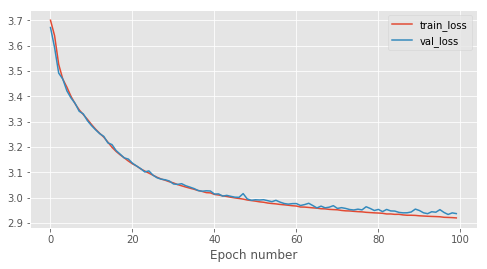

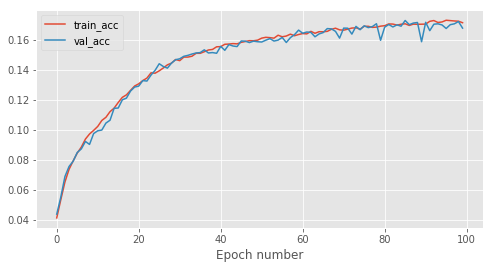

loss: 3.8486, accuracy: 0.0100:   2%|▏         | 19/1000 [00:00<00:08, 109.26it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 6, 6])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(5, 5), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(5, 5), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(5, 5), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), s

loss: 3.5644, accuracy: 0.0600:   2%|▏         | 20/1000 [00:00<00:09, 106.81it/s]

Epoch 0: train_acc_0.0428_train_loss_3.6749_val_acc_0.0575_val_loss_3.5812 epoch time 11.0502 seconds
total time0.0 : 11.050235509872437


loss: 3.3904, accuracy: 0.1200:   2%|▏         | 20/1000 [00:00<00:09, 106.70it/s]

Epoch 1: train_acc_0.0639_train_loss_3.4843_val_acc_0.0723_val_loss_3.4297 epoch time 11.0693 seconds
total time0.0 : 22.119518041610718


loss: 3.3692, accuracy: 0.0600:   2%|▏         | 20/1000 [00:00<00:09, 105.30it/s]

Epoch 2: train_acc_0.0734_train_loss_3.4180_val_acc_0.0754_val_loss_3.4087 epoch time 11.0496 seconds
total time0.0 : 33.169081926345825


loss: 3.2548, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 105.72it/s]

Epoch 3: train_acc_0.0793_train_loss_3.3947_val_acc_0.0802_val_loss_3.3831 epoch time 11.0569 seconds
total time0.0 : 44.225980281829834


loss: 3.3723, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 105.73it/s]

Epoch 4: train_acc_0.0819_train_loss_3.3775_val_acc_0.0773_val_loss_3.3690 epoch time 10.9849 seconds
total time0.0 : 55.21086883544922


loss: 3.3549, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 107.43it/s]

Epoch 5: train_acc_0.0823_train_loss_3.3631_val_acc_0.0839_val_loss_3.3676 epoch time 11.0641 seconds
total time1.0 : 6.274988651275635


loss: 3.2834, accuracy: 0.0600:   2%|▏         | 20/1000 [00:00<00:09, 106.08it/s]

Epoch 6: train_acc_0.0849_train_loss_3.3517_val_acc_0.0875_val_loss_3.3541 epoch time 11.0630 seconds
total time1.0 : 17.338012218475342


loss: 3.2790, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 107.70it/s]

Epoch 7: train_acc_0.0860_train_loss_3.3398_val_acc_0.0899_val_loss_3.3374 epoch time 11.0731 seconds
total time1.0 : 28.41112756729126


loss: 3.2778, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 105.65it/s]

Epoch 8: train_acc_0.0887_train_loss_3.3269_val_acc_0.0915_val_loss_3.3183 epoch time 11.0235 seconds
total time1.0 : 39.434667348861694


loss: 3.2699, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 105.36it/s]

Epoch 9: train_acc_0.0937_train_loss_3.3011_val_acc_0.0997_val_loss_3.2865 epoch time 11.1246 seconds
total time1.0 : 50.55931520462036


loss: 3.2197, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 104.84it/s]

Epoch 10: train_acc_0.1040_train_loss_3.2623_val_acc_0.1053_val_loss_3.2529 epoch time 11.0436 seconds
total time2.0 : 1.6029205322265625


loss: 3.1383, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 107.09it/s]

Epoch 11: train_acc_0.1106_train_loss_3.2342_val_acc_0.1083_val_loss_3.2451 epoch time 11.0261 seconds
total time2.0 : 12.629025936126709


loss: 3.1942, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 107.90it/s]

Epoch 12: train_acc_0.1172_train_loss_3.2064_val_acc_0.1154_val_loss_3.2181 epoch time 11.0205 seconds
total time2.0 : 23.6495623588562


loss: 3.1179, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 108.82it/s]

Epoch 13: train_acc_0.1237_train_loss_3.1681_val_acc_0.1231_val_loss_3.1635 epoch time 11.0208 seconds
total time2.0 : 34.67034912109375


loss: 3.1473, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:08, 108.91it/s]

Epoch 14: train_acc_0.1320_train_loss_3.1274_val_acc_0.1301_val_loss_3.1112 epoch time 11.0407 seconds
total time2.0 : 45.71103835105896


loss: 3.0514, accuracy: 0.1200:   2%|▏         | 20/1000 [00:00<00:09, 106.32it/s]

Epoch 15: train_acc_0.1363_train_loss_3.1012_val_acc_0.1356_val_loss_3.0944 epoch time 11.0423 seconds
total time2.0 : 56.75329113006592


loss: 3.2259, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 106.20it/s]

Epoch 16: train_acc_0.1412_train_loss_3.0817_val_acc_0.1385_val_loss_3.0842 epoch time 11.0460 seconds
total time3.0 : 7.799334287643433


loss: 2.8899, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 107.59it/s]

Epoch 17: train_acc_0.1436_train_loss_3.0644_val_acc_0.1452_val_loss_3.0520 epoch time 11.1053 seconds
total time3.0 : 18.904624462127686


loss: 3.1919, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 107.40it/s]

Epoch 18: train_acc_0.1460_train_loss_3.0503_val_acc_0.1447_val_loss_3.0532 epoch time 11.0325 seconds
total time3.0 : 29.93710470199585


loss: 3.1782, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 108.54it/s]

Epoch 19: train_acc_0.1484_train_loss_3.0373_val_acc_0.1501_val_loss_3.0358 epoch time 11.0314 seconds
total time3.0 : 40.96854853630066


loss: 2.9545, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 105.35it/s]

Epoch 20: train_acc_0.1510_train_loss_3.0236_val_acc_0.1513_val_loss_3.0149 epoch time 11.0272 seconds
total time3.0 : 51.99573993682861


loss: 3.0316, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 107.92it/s]

Epoch 21: train_acc_0.1545_train_loss_3.0114_val_acc_0.1549_val_loss_3.0021 epoch time 11.1258 seconds
total time4.0 : 3.121509313583374


loss: 3.0159, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 106.15it/s]

Epoch 22: train_acc_0.1575_train_loss_2.9978_val_acc_0.1618_val_loss_2.9909 epoch time 11.0155 seconds
total time4.0 : 14.136987924575806


loss: 2.9655, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 106.32it/s]

Epoch 23: train_acc_0.1604_train_loss_2.9821_val_acc_0.1635_val_loss_2.9699 epoch time 11.0813 seconds
total time4.0 : 25.218281745910645


loss: 2.9874, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 106.02it/s]

Epoch 24: train_acc_0.1638_train_loss_2.9675_val_acc_0.1693_val_loss_2.9529 epoch time 10.9920 seconds
total time4.0 : 36.21026277542114


loss: 2.8976, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 107.44it/s]

Epoch 25: train_acc_0.1681_train_loss_2.9525_val_acc_0.1670_val_loss_2.9520 epoch time 11.1076 seconds
total time4.0 : 47.317821741104126


loss: 3.1226, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 107.77it/s]

Epoch 26: train_acc_0.1692_train_loss_2.9407_val_acc_0.1742_val_loss_2.9328 epoch time 11.0545 seconds
total time4.0 : 58.372310638427734


loss: 2.9727, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 108.32it/s]

Epoch 27: train_acc_0.1723_train_loss_2.9285_val_acc_0.1744_val_loss_2.9301 epoch time 11.0790 seconds
total time5.0 : 9.4512779712677


loss: 2.8885, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 106.15it/s]

Epoch 28: train_acc_0.1749_train_loss_2.9168_val_acc_0.1754_val_loss_2.9153 epoch time 11.0564 seconds
total time5.0 : 20.507694482803345


loss: 2.7734, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 105.18it/s]

Epoch 29: train_acc_0.1769_train_loss_2.9055_val_acc_0.1780_val_loss_2.9001 epoch time 11.0560 seconds
total time5.0 : 31.563735723495483


loss: 2.9946, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 106.47it/s]

Epoch 30: train_acc_0.1784_train_loss_2.8973_val_acc_0.1787_val_loss_2.9059 epoch time 11.0290 seconds
total time5.0 : 42.59270453453064


loss: 2.9476, accuracy: 0.1100:   2%|▏         | 20/1000 [00:00<00:09, 105.43it/s]

Epoch 31: train_acc_0.1815_train_loss_2.8876_val_acc_0.1812_val_loss_2.8945 epoch time 11.0963 seconds
total time5.0 : 53.68903112411499


loss: 2.9583, accuracy: 0.1200:   2%|▏         | 20/1000 [00:00<00:09, 106.81it/s]

Epoch 32: train_acc_0.1829_train_loss_2.8792_val_acc_0.1797_val_loss_2.9088 epoch time 11.0191 seconds
total time6.0 : 4.708139419555664


loss: 2.9136, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:08, 109.37it/s]

Epoch 33: train_acc_0.1852_train_loss_2.8704_val_acc_0.1882_val_loss_2.8653 epoch time 11.0801 seconds
total time6.0 : 15.788202047348022


loss: 2.9536, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 107.46it/s]

Epoch 34: train_acc_0.1853_train_loss_2.8627_val_acc_0.1918_val_loss_2.8559 epoch time 11.0063 seconds
total time6.0 : 26.794549703598022


loss: 2.9643, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:08, 109.08it/s]

Epoch 35: train_acc_0.1878_train_loss_2.8540_val_acc_0.1903_val_loss_2.8593 epoch time 11.0543 seconds
total time6.0 : 37.8488872051239


loss: 2.6417, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 106.87it/s]

Epoch 36: train_acc_0.1887_train_loss_2.8467_val_acc_0.1904_val_loss_2.8416 epoch time 11.0089 seconds
total time6.0 : 48.85778880119324


loss: 2.7180, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:08, 109.80it/s]

Epoch 37: train_acc_0.1901_train_loss_2.8387_val_acc_0.1923_val_loss_2.8344 epoch time 11.1205 seconds
total time6.0 : 59.97832489013672


loss: 2.7558, accuracy: 0.2600:   2%|▏         | 20/1000 [00:00<00:09, 106.00it/s]

Epoch 38: train_acc_0.1922_train_loss_2.8314_val_acc_0.1971_val_loss_2.8292 epoch time 11.0604 seconds
total time7.0 : 11.03868556022644


loss: 2.7132, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 108.36it/s]

Epoch 39: train_acc_0.1944_train_loss_2.8247_val_acc_0.1955_val_loss_2.8192 epoch time 11.0891 seconds
total time7.0 : 22.127752542495728


loss: 2.7933, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 106.56it/s]

Epoch 40: train_acc_0.1960_train_loss_2.8175_val_acc_0.1951_val_loss_2.8102 epoch time 11.0512 seconds
total time7.0 : 33.1789767742157


loss: 2.9530, accuracy: 0.1000:   2%|▏         | 20/1000 [00:00<00:09, 105.95it/s]

Epoch 41: train_acc_0.1960_train_loss_2.8132_val_acc_0.1954_val_loss_2.8108 epoch time 11.1270 seconds
total time7.0 : 44.30602431297302


loss: 2.6374, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 108.70it/s]

Epoch 42: train_acc_0.1981_train_loss_2.8043_val_acc_0.1978_val_loss_2.8041 epoch time 11.0464 seconds
total time7.0 : 55.35242986679077


loss: 2.9419, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 106.71it/s]

Epoch 43: train_acc_0.1991_train_loss_2.7993_val_acc_0.2020_val_loss_2.7981 epoch time 11.1263 seconds
total time8.0 : 6.478774070739746


loss: 2.7217, accuracy: 0.2200:   2%|▏         | 19/1000 [00:00<00:09, 103.31it/s]

Epoch 44: train_acc_0.2003_train_loss_2.7925_val_acc_0.2012_val_loss_2.7885 epoch time 11.0556 seconds
total time8.0 : 17.53435492515564


loss: 2.8364, accuracy: 0.2300:   2%|▏         | 20/1000 [00:00<00:09, 104.68it/s]

Epoch 45: train_acc_0.2016_train_loss_2.7876_val_acc_0.2021_val_loss_2.7804 epoch time 11.0771 seconds
total time8.0 : 28.611464500427246


loss: 2.8072, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 104.90it/s]

Epoch 46: train_acc_0.2023_train_loss_2.7829_val_acc_0.2035_val_loss_2.7756 epoch time 11.0339 seconds
total time8.0 : 39.645331621170044


loss: 2.5646, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 107.05it/s]

Epoch 47: train_acc_0.2049_train_loss_2.7781_val_acc_0.2059_val_loss_2.7749 epoch time 11.0403 seconds
total time8.0 : 50.685588121414185


loss: 2.9299, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:08, 109.28it/s]

Epoch 48: train_acc_0.2057_train_loss_2.7731_val_acc_0.2028_val_loss_2.7666 epoch time 11.0728 seconds
total time9.0 : 1.7584333419799805


loss: 2.8471, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 108.09it/s]

Epoch 49: train_acc_0.2048_train_loss_2.7710_val_acc_0.1996_val_loss_2.7782 epoch time 11.1149 seconds
total time9.0 : 12.873376369476318


loss: 3.0709, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 105.42it/s]

Epoch 50: train_acc_0.2077_train_loss_2.7648_val_acc_0.2044_val_loss_2.7735 epoch time 11.0722 seconds
total time9.0 : 23.945528268814087


loss: 2.7958, accuracy: 0.2300:   2%|▏         | 20/1000 [00:00<00:09, 107.49it/s]

Epoch 51: train_acc_0.2076_train_loss_2.7610_val_acc_0.2113_val_loss_2.7603 epoch time 11.0822 seconds
total time9.0 : 35.02775692939758


loss: 2.8405, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 105.63it/s]

Epoch 52: train_acc_0.2083_train_loss_2.7569_val_acc_0.2047_val_loss_2.7757 epoch time 11.0270 seconds
total time9.0 : 46.05478644371033


loss: 2.6456, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 106.26it/s]

Epoch 53: train_acc_0.2089_train_loss_2.7527_val_acc_0.2122_val_loss_2.7452 epoch time 11.0912 seconds
total time9.0 : 57.145939111709595


loss: 2.7866, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 106.63it/s]

Epoch 54: train_acc_0.2098_train_loss_2.7488_val_acc_0.2079_val_loss_2.7843 epoch time 11.0475 seconds
total time10.0 : 8.193442106246948


loss: 2.8158, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 107.97it/s]

Epoch 55: train_acc_0.2117_train_loss_2.7454_val_acc_0.2065_val_loss_2.7719 epoch time 11.0648 seconds
total time10.0 : 19.258260011672974


loss: 2.6225, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 105.92it/s]

Epoch 56: train_acc_0.2112_train_loss_2.7426_val_acc_0.2086_val_loss_2.7507 epoch time 11.0541 seconds
total time10.0 : 30.312350034713745


loss: 2.7084, accuracy: 0.3000:   2%|▏         | 20/1000 [00:00<00:08, 109.31it/s]

Epoch 57: train_acc_0.2118_train_loss_2.7391_val_acc_0.2082_val_loss_2.7450 epoch time 11.1209 seconds
total time10.0 : 41.433265209198


loss: 2.7392, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 105.37it/s]

Epoch 58: train_acc_0.2137_train_loss_2.7354_val_acc_0.2086_val_loss_2.7490 epoch time 11.0155 seconds
total time10.0 : 52.44880533218384


loss: 2.4860, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 107.27it/s]

Epoch 59: train_acc_0.2130_train_loss_2.7317_val_acc_0.2144_val_loss_2.7416 epoch time 11.0795 seconds
total time11.0 : 3.5283498764038086


loss: 2.7724, accuracy: 0.2900:   2%|▏         | 20/1000 [00:00<00:09, 104.49it/s]

Epoch 60: train_acc_0.2142_train_loss_2.7300_val_acc_0.2134_val_loss_2.7349 epoch time 11.0819 seconds
total time11.0 : 14.610238313674927


loss: 2.7586, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 106.67it/s]

Epoch 61: train_acc_0.2150_train_loss_2.7260_val_acc_0.2134_val_loss_2.7386 epoch time 11.0504 seconds
total time11.0 : 25.660671710968018


loss: 2.8128, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 107.18it/s]

Epoch 62: train_acc_0.2161_train_loss_2.7233_val_acc_0.2153_val_loss_2.7255 epoch time 11.0346 seconds
total time11.0 : 36.695253133773804


loss: 2.7250, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 104.83it/s]

Epoch 63: train_acc_0.2161_train_loss_2.7210_val_acc_0.2153_val_loss_2.7339 epoch time 11.0979 seconds
total time11.0 : 47.79318690299988


loss: 2.6491, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 105.50it/s]

Epoch 64: train_acc_0.2175_train_loss_2.7171_val_acc_0.2126_val_loss_2.7309 epoch time 11.0385 seconds
total time11.0 : 58.83166170120239


loss: 2.6367, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 107.89it/s]

Epoch 65: train_acc_0.2162_train_loss_2.7149_val_acc_0.2169_val_loss_2.7277 epoch time 11.0971 seconds
total time12.0 : 9.92873764038086


loss: 2.6241, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 106.34it/s]

Epoch 66: train_acc_0.2174_train_loss_2.7118_val_acc_0.2196_val_loss_2.7132 epoch time 11.0540 seconds
total time12.0 : 20.982767581939697


loss: 2.7977, accuracy: 0.2400:   2%|▏         | 21/1000 [00:00<00:08, 112.58it/s]

Epoch 67: train_acc_0.2189_train_loss_2.7103_val_acc_0.2169_val_loss_2.7154 epoch time 11.0847 seconds
total time12.0 : 32.067490100860596


loss: 2.7526, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 106.90it/s]

Epoch 68: train_acc_0.2191_train_loss_2.7059_val_acc_0.2212_val_loss_2.7140 epoch time 11.0630 seconds
total time12.0 : 43.13050842285156


loss: 2.6153, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 105.97it/s]

Epoch 69: train_acc_0.2198_train_loss_2.7043_val_acc_0.2174_val_loss_2.7125 epoch time 11.1210 seconds
total time12.0 : 54.251556158065796


loss: 2.6666, accuracy: 0.2500:   2%|▏         | 20/1000 [00:00<00:09, 106.23it/s]

Epoch 70: train_acc_0.2204_train_loss_2.7026_val_acc_0.2135_val_loss_2.7046 epoch time 11.0632 seconds
total time13.0 : 5.314770936965942


loss: 2.6500, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 107.76it/s]

Epoch 71: train_acc_0.2210_train_loss_2.6999_val_acc_0.2170_val_loss_2.7176 epoch time 11.0938 seconds
total time13.0 : 16.408583641052246


loss: 2.4834, accuracy: 0.3000:   2%|▏         | 20/1000 [00:00<00:09, 105.63it/s]

Epoch 72: train_acc_0.2214_train_loss_2.6965_val_acc_0.2175_val_loss_2.7199 epoch time 11.0700 seconds
total time13.0 : 27.478593587875366


loss: 2.6363, accuracy: 0.2600:   2%|▏         | 20/1000 [00:00<00:08, 109.29it/s]

Epoch 73: train_acc_0.2230_train_loss_2.6951_val_acc_0.2206_val_loss_2.7012 epoch time 11.1025 seconds
total time13.0 : 38.581134557724


loss: 2.8112, accuracy: 0.2800:   2%|▏         | 20/1000 [00:00<00:09, 108.09it/s]

Epoch 74: train_acc_0.2230_train_loss_2.6921_val_acc_0.2208_val_loss_2.7077 epoch time 11.0559 seconds
total time13.0 : 49.637022256851196


loss: 2.3822, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 105.43it/s]

Epoch 75: train_acc_0.2232_train_loss_2.6903_val_acc_0.2203_val_loss_2.6974 epoch time 11.1023 seconds
total time14.0 : 0.739316463470459


loss: 2.6993, accuracy: 0.2300:   2%|▏         | 20/1000 [00:00<00:09, 106.12it/s]

Epoch 76: train_acc_0.2251_train_loss_2.6871_val_acc_0.2140_val_loss_2.7088 epoch time 11.0602 seconds
total time14.0 : 11.799507141113281


loss: 2.6660, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 106.73it/s]

Epoch 77: train_acc_0.2235_train_loss_2.6874_val_acc_0.2157_val_loss_2.7074 epoch time 11.0808 seconds
total time14.0 : 22.88030767440796


loss: 2.6194, accuracy: 0.2700:   2%|▏         | 20/1000 [00:00<00:09, 104.62it/s]

Epoch 78: train_acc_0.2233_train_loss_2.6836_val_acc_0.2224_val_loss_2.6924 epoch time 11.0391 seconds
total time14.0 : 33.91936159133911


loss: 2.5753, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 105.59it/s]

Epoch 79: train_acc_0.2244_train_loss_2.6832_val_acc_0.2244_val_loss_2.6965 epoch time 11.0918 seconds
total time14.0 : 45.01118469238281


loss: 2.7337, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:08, 110.63it/s]

Epoch 80: train_acc_0.2249_train_loss_2.6800_val_acc_0.2227_val_loss_2.6886 epoch time 11.0122 seconds
total time14.0 : 56.02340769767761


loss: 2.4369, accuracy: 0.3000:   2%|▏         | 20/1000 [00:00<00:09, 104.78it/s]

Epoch 81: train_acc_0.2259_train_loss_2.6780_val_acc_0.2230_val_loss_2.6894 epoch time 11.1306 seconds
total time15.0 : 7.153982162475586


loss: 2.7551, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 107.11it/s]

Epoch 82: train_acc_0.2283_train_loss_2.6772_val_acc_0.2195_val_loss_2.6980 epoch time 11.0531 seconds
total time15.0 : 18.20707130432129


loss: 2.5609, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 105.95it/s]

Epoch 83: train_acc_0.2271_train_loss_2.6750_val_acc_0.2130_val_loss_2.7198 epoch time 11.0606 seconds
total time15.0 : 29.267648220062256


loss: 2.5509, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 105.10it/s]

Epoch 84: train_acc_0.2263_train_loss_2.6731_val_acc_0.2165_val_loss_2.6962 epoch time 11.0595 seconds
total time15.0 : 40.32718896865845


loss: 2.6566, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 105.11it/s]

Epoch 85: train_acc_0.2286_train_loss_2.6700_val_acc_0.2189_val_loss_2.6906 epoch time 11.0772 seconds
total time15.0 : 51.404433488845825


loss: 2.7329, accuracy: 0.2700:   2%|▏         | 20/1000 [00:00<00:09, 105.56it/s]

Epoch 86: train_acc_0.2274_train_loss_2.6684_val_acc_0.2172_val_loss_2.6937 epoch time 10.9895 seconds
total time16.0 : 2.393897294998169


loss: 2.6376, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 106.43it/s]

Epoch 87: train_acc_0.2292_train_loss_2.6687_val_acc_0.2218_val_loss_2.6924 epoch time 11.0875 seconds
total time16.0 : 13.48142957687378


loss: 2.5424, accuracy: 0.2900:   2%|▏         | 20/1000 [00:00<00:09, 107.42it/s]

Epoch 88: train_acc_0.2282_train_loss_2.6670_val_acc_0.2185_val_loss_2.6875 epoch time 11.0096 seconds
total time16.0 : 24.49104619026184


loss: 2.5960, accuracy: 0.3300:   2%|▏         | 20/1000 [00:00<00:09, 106.47it/s]

Epoch 89: train_acc_0.2284_train_loss_2.6646_val_acc_0.2253_val_loss_2.6862 epoch time 11.0687 seconds
total time16.0 : 35.55973148345947


loss: 2.6863, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 107.12it/s]

Epoch 90: train_acc_0.2293_train_loss_2.6626_val_acc_0.2230_val_loss_2.6876 epoch time 11.1223 seconds
total time16.0 : 46.68200898170471


loss: 2.7990, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:09, 105.81it/s]

Epoch 91: train_acc_0.2289_train_loss_2.6613_val_acc_0.2253_val_loss_2.6782 epoch time 11.0901 seconds
total time16.0 : 57.772151708602905


loss: 2.7131, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 107.32it/s]

Epoch 92: train_acc_0.2299_train_loss_2.6589_val_acc_0.2283_val_loss_2.6774 epoch time 11.0407 seconds
total time17.0 : 8.81281065940857


loss: 2.6613, accuracy: 0.2200:   2%|▏         | 20/1000 [00:00<00:09, 106.61it/s]

Epoch 93: train_acc_0.2311_train_loss_2.6576_val_acc_0.2244_val_loss_2.6697 epoch time 11.1269 seconds
total time17.0 : 19.93974995613098


loss: 2.7345, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 105.35it/s]

Epoch 94: train_acc_0.2294_train_loss_2.6583_val_acc_0.2218_val_loss_2.6764 epoch time 11.0431 seconds
total time17.0 : 30.982832670211792


loss: 2.5522, accuracy: 0.2600:   2%|▏         | 20/1000 [00:00<00:09, 106.28it/s]

Epoch 95: train_acc_0.2309_train_loss_2.6555_val_acc_0.2272_val_loss_2.6696 epoch time 11.0677 seconds
total time17.0 : 42.05057764053345


loss: 2.7092, accuracy: 0.2300:   2%|▏         | 20/1000 [00:00<00:09, 106.37it/s]

Epoch 96: train_acc_0.2319_train_loss_2.6535_val_acc_0.2253_val_loss_2.6762 epoch time 11.0553 seconds
total time17.0 : 53.105838775634766


loss: 2.5748, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 106.10it/s]

Epoch 97: train_acc_0.2315_train_loss_2.6510_val_acc_0.2251_val_loss_2.6735 epoch time 11.0488 seconds
total time18.0 : 4.154604434967041


loss: 2.7168, accuracy: 0.2500:   2%|▏         | 20/1000 [00:00<00:09, 105.39it/s]

Epoch 98: train_acc_0.2316_train_loss_2.6502_val_acc_0.2237_val_loss_2.6724 epoch time 11.0567 seconds
total time18.0 : 15.21131420135498


loss: 2.6300, accuracy: 0.2700:  20%|█▉        | 31/158 [00:00<00:00, 168.77it/s]

Epoch 99: train_acc_0.2327_train_loss_2.6488_val_acc_0.2263_val_loss_2.6790 epoch time 11.1407 seconds
total time18.0 : 26.352060079574585
Generating test set evaluation metrics


loss: 2.7369, accuracy: 0.2300: 100%|██████████| 158/158 [00:00<00:00, 158.05it/s]


finish


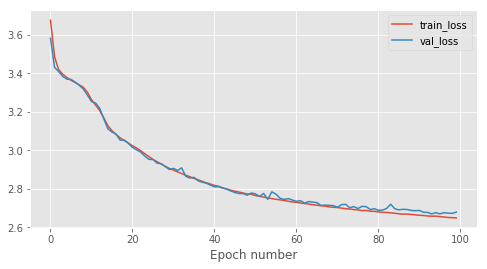

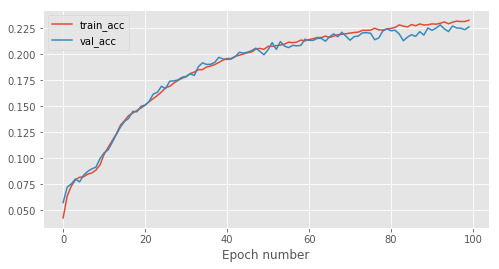

loss: 3.8543, accuracy: 0.0300:   2%|▏         | 19/1000 [00:00<00:08, 111.41it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 5, 5])
torch.Size([100, 64, 3, 3])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(6, 6), padding=(1, 1))
    (dim_reduction_avg_pool_0): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(6, 6), padding=(1, 1))
    (dim_reduction_avg_pool_1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(6, 6), padding=(1, 1))
    (dim_reduction_avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), s

loss: 3.7164, accuracy: 0.0400:   2%|▏         | 20/1000 [00:00<00:09, 105.43it/s]

Epoch 0: train_acc_0.0316_train_loss_3.7915_val_acc_0.0581_val_loss_3.6538 epoch time 10.8688 seconds
total time0.0 : 10.868795394897461


loss: 3.6178, accuracy: 0.0400:   2%|▏         | 20/1000 [00:00<00:09, 105.42it/s]

Epoch 1: train_acc_0.0614_train_loss_3.6232_val_acc_0.0643_val_loss_3.5966 epoch time 10.9348 seconds
total time0.0 : 21.80354619026184


loss: 3.5209, accuracy: 0.0500:   2%|▏         | 20/1000 [00:00<00:09, 105.76it/s]

Epoch 2: train_acc_0.0666_train_loss_3.5628_val_acc_0.0679_val_loss_3.5302 epoch time 10.9363 seconds
total time0.0 : 32.73980140686035


loss: 3.4896, accuracy: 0.0500:   2%|▏         | 20/1000 [00:00<00:09, 106.70it/s]

Epoch 3: train_acc_0.0743_train_loss_3.4949_val_acc_0.0801_val_loss_3.4716 epoch time 11.0250 seconds
total time0.0 : 43.764806509017944


loss: 3.3806, accuracy: 0.0600:   2%|▏         | 20/1000 [00:00<00:09, 106.25it/s]

Epoch 4: train_acc_0.0814_train_loss_3.4460_val_acc_0.0820_val_loss_3.4333 epoch time 10.9340 seconds
total time0.0 : 54.698814392089844


loss: 3.3987, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 108.63it/s]

Epoch 5: train_acc_0.0892_train_loss_3.4099_val_acc_0.0939_val_loss_3.4026 epoch time 11.0485 seconds
total time1.0 : 5.7473366260528564


loss: 3.4076, accuracy: 0.0500:   2%|▏         | 20/1000 [00:00<00:09, 107.71it/s]

Epoch 6: train_acc_0.0929_train_loss_3.3900_val_acc_0.0957_val_loss_3.3857 epoch time 10.9499 seconds
total time1.0 : 16.697272539138794


loss: 3.4005, accuracy: 0.0700:   2%|▏         | 20/1000 [00:00<00:09, 108.89it/s]

Epoch 7: train_acc_0.0957_train_loss_3.3738_val_acc_0.0985_val_loss_3.3815 epoch time 11.0424 seconds
total time1.0 : 27.739665269851685


loss: 3.2972, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 106.50it/s]

Epoch 8: train_acc_0.0971_train_loss_3.3587_val_acc_0.1007_val_loss_3.3547 epoch time 10.9964 seconds
total time1.0 : 38.736034870147705


loss: 3.4402, accuracy: 0.0700:   2%|▏         | 21/1000 [00:00<00:08, 112.78it/s]

Epoch 9: train_acc_0.1004_train_loss_3.3427_val_acc_0.1030_val_loss_3.3438 epoch time 11.0295 seconds
total time1.0 : 49.76549506187439


loss: 3.2897, accuracy: 0.0700:   2%|▏         | 20/1000 [00:00<00:09, 104.84it/s]

Epoch 10: train_acc_0.1023_train_loss_3.3242_val_acc_0.1063_val_loss_3.3184 epoch time 10.9004 seconds
total time2.0 : 0.665900468826294


loss: 3.4191, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:08, 109.93it/s]

Epoch 11: train_acc_0.1054_train_loss_3.3062_val_acc_0.1094_val_loss_3.3166 epoch time 11.0299 seconds
total time2.0 : 11.695839405059814


loss: 3.3047, accuracy: 0.1200:   2%|▏         | 20/1000 [00:00<00:09, 106.95it/s]

Epoch 12: train_acc_0.1093_train_loss_3.2881_val_acc_0.1135_val_loss_3.2836 epoch time 10.8884 seconds
total time2.0 : 22.584217071533203


loss: 3.1767, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 106.19it/s]

Epoch 13: train_acc_0.1139_train_loss_3.2658_val_acc_0.1173_val_loss_3.2641 epoch time 11.0019 seconds
total time2.0 : 33.58614230155945


loss: 3.2275, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:08, 109.65it/s]

Epoch 14: train_acc_0.1170_train_loss_3.2424_val_acc_0.1211_val_loss_3.2389 epoch time 10.9600 seconds
total time2.0 : 44.54613733291626


loss: 3.1713, accuracy: 0.0700:   2%|▏         | 20/1000 [00:00<00:09, 105.32it/s]

Epoch 15: train_acc_0.1209_train_loss_3.2168_val_acc_0.1246_val_loss_3.2062 epoch time 11.0110 seconds
total time2.0 : 55.55717420578003


loss: 3.1120, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 107.77it/s]

Epoch 16: train_acc_0.1283_train_loss_3.1799_val_acc_0.1303_val_loss_3.1614 epoch time 10.9375 seconds
total time3.0 : 6.49465537071228


loss: 3.2519, accuracy: 0.0800:   2%|▏         | 20/1000 [00:00<00:09, 108.26it/s]

Epoch 17: train_acc_0.1361_train_loss_3.1421_val_acc_0.1406_val_loss_3.1344 epoch time 10.9753 seconds
total time3.0 : 17.469908952713013


loss: 3.0462, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:09, 104.75it/s]

Epoch 18: train_acc_0.1433_train_loss_3.1161_val_acc_0.1378_val_loss_3.1494 epoch time 10.9250 seconds
total time3.0 : 28.394906997680664


loss: 3.4028, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 108.20it/s]

Epoch 19: train_acc_0.1448_train_loss_3.0976_val_acc_0.1522_val_loss_3.0907 epoch time 11.0820 seconds
total time3.0 : 39.47694420814514


loss: 3.0616, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:08, 109.76it/s]

Epoch 20: train_acc_0.1503_train_loss_3.0802_val_acc_0.1527_val_loss_3.0759 epoch time 10.8478 seconds
total time3.0 : 50.32472372055054


loss: 3.0716, accuracy: 0.1700:   2%|▏         | 20/1000 [00:00<00:08, 109.51it/s]

Epoch 21: train_acc_0.1554_train_loss_3.0636_val_acc_0.1606_val_loss_3.0603 epoch time 10.9791 seconds
total time4.0 : 1.3037965297698975


loss: 2.9297, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 107.78it/s]

Epoch 22: train_acc_0.1580_train_loss_3.0481_val_acc_0.1649_val_loss_3.0337 epoch time 10.8882 seconds
total time4.0 : 12.192044973373413


loss: 3.0122, accuracy: 0.0900:   2%|▏         | 20/1000 [00:00<00:08, 110.46it/s]

Epoch 23: train_acc_0.1616_train_loss_3.0340_val_acc_0.1656_val_loss_3.0270 epoch time 10.9210 seconds
total time4.0 : 23.11307668685913


loss: 2.9251, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 107.21it/s]

Epoch 24: train_acc_0.1641_train_loss_3.0195_val_acc_0.1706_val_loss_3.0177 epoch time 10.9348 seconds
total time4.0 : 34.047866106033325


loss: 2.9858, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 108.25it/s]

Epoch 25: train_acc_0.1676_train_loss_3.0052_val_acc_0.1728_val_loss_2.9969 epoch time 10.9977 seconds
total time4.0 : 45.045520305633545


loss: 2.8110, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:08, 109.12it/s]

Epoch 26: train_acc_0.1714_train_loss_2.9901_val_acc_0.1752_val_loss_2.9879 epoch time 10.9259 seconds
total time4.0 : 55.971457958221436


loss: 2.8526, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 107.23it/s]

Epoch 27: train_acc_0.1752_train_loss_2.9780_val_acc_0.1765_val_loss_2.9786 epoch time 10.9847 seconds
total time5.0 : 6.956159353256226


loss: 2.7981, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 106.73it/s]

Epoch 28: train_acc_0.1782_train_loss_2.9652_val_acc_0.1809_val_loss_2.9537 epoch time 10.9006 seconds
total time5.0 : 17.85679292678833


loss: 2.9055, accuracy: 0.2200:   2%|▏         | 21/1000 [00:00<00:08, 109.85it/s]

Epoch 29: train_acc_0.1818_train_loss_2.9531_val_acc_0.1785_val_loss_2.9566 epoch time 11.0194 seconds
total time5.0 : 28.876190900802612


loss: 2.7760, accuracy: 0.2300:   2%|▏         | 20/1000 [00:00<00:09, 107.85it/s]

Epoch 30: train_acc_0.1845_train_loss_2.9414_val_acc_0.1864_val_loss_2.9364 epoch time 10.9076 seconds
total time5.0 : 39.783754110336304


loss: 2.9357, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 108.54it/s]

Epoch 31: train_acc_0.1874_train_loss_2.9272_val_acc_0.1932_val_loss_2.9214 epoch time 11.0815 seconds
total time5.0 : 50.86520862579346


loss: 3.0131, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 107.96it/s]

Epoch 32: train_acc_0.1903_train_loss_2.9162_val_acc_0.1949_val_loss_2.9105 epoch time 10.8872 seconds
total time6.0 : 1.7524218559265137


loss: 3.0122, accuracy: 0.1500:   2%|▏         | 20/1000 [00:00<00:09, 106.90it/s]

Epoch 33: train_acc_0.1918_train_loss_2.9052_val_acc_0.1934_val_loss_2.8988 epoch time 11.0018 seconds
total time6.0 : 12.754268407821655


loss: 2.9078, accuracy: 0.1600:   2%|▏         | 20/1000 [00:00<00:09, 105.89it/s]

Epoch 34: train_acc_0.1947_train_loss_2.8943_val_acc_0.1994_val_loss_2.8935 epoch time 10.9508 seconds
total time6.0 : 23.705065965652466


loss: 2.8386, accuracy: 0.2400:   2%|▏         | 20/1000 [00:00<00:09, 107.21it/s]

Epoch 35: train_acc_0.1982_train_loss_2.8837_val_acc_0.2033_val_loss_2.8804 epoch time 11.0686 seconds
total time6.0 : 34.77366375923157


loss: 2.9411, accuracy: 0.1600:   2%|▏         | 21/1000 [00:00<00:09, 108.67it/s]

Epoch 36: train_acc_0.1998_train_loss_2.8748_val_acc_0.2039_val_loss_2.8735 epoch time 10.9247 seconds
total time6.0 : 45.698397159576416


loss: 2.9185, accuracy: 0.2100:   2%|▏         | 20/1000 [00:00<00:09, 105.31it/s]

Epoch 37: train_acc_0.2017_train_loss_2.8661_val_acc_0.2023_val_loss_2.8746 epoch time 11.0802 seconds
total time6.0 : 56.77859044075012


loss: 2.9817, accuracy: 0.1800:   2%|▏         | 20/1000 [00:00<00:09, 107.80it/s]

Epoch 38: train_acc_0.2042_train_loss_2.8580_val_acc_0.1996_val_loss_2.8695 epoch time 10.9416 seconds
total time7.0 : 7.720191478729248


loss: 2.7727, accuracy: 0.1900:   2%|▏         | 21/1000 [00:00<00:08, 113.74it/s]

Epoch 39: train_acc_0.2058_train_loss_2.8483_val_acc_0.2092_val_loss_2.8465 epoch time 11.0219 seconds
total time7.0 : 18.742042064666748


loss: 2.8855, accuracy: 0.2100:  29%|██▉       | 292/1000 [00:02<00:06, 104.26it/s]


KeyboardInterrupt: 

In [5]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [3,3,3,3,3,3]
strides = [1,2,3,4,5,6]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = 4
experiment_name = []
for stride in strides:
    experiment_name.append("strided_convolution_avgpooling_{}".format(stride))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,stride in zip(dim_reduction_idx,experiment_name,strides):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=num_layers, use_bias=True,stride=stride)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f66f8576f60>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f66f72e7c88>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f66f72e7c18>)
Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 14, 14])
torch.Size([100, 64, 8, 8])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 3, 3])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU


  0%|          | 0/1000 [00:00<?, ?it/s]

ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (dim_reduction_max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (logit_linear_layer): Linear(in_features=256, out_features=47, bias=True)
)


loss: 0.8594, accuracy: 0.7200: 100%|██████████| 158/158 [00:01<00:00, 148.80it/s]


Epoch 0: train_acc_0.5908_train_loss_1.3634_val_acc_0.7640_val_loss_0.7504 epoch time 13.9483 seconds
total time0.0 : 13.948267221450806


loss: 0.5538, accuracy: 0.8400:   2%|▏         | 16/1000 [00:00<00:11, 84.07it/s]

Epoch 1: train_acc_0.7796_train_loss_0.6694_val_acc_0.8067_val_loss_0.5733 epoch time 13.5235 seconds
total time0.0 : 27.471742630004883


loss: 0.5493, accuracy: 0.8100:   2%|▏         | 16/1000 [00:00<00:11, 87.97it/s]

Epoch 2: train_acc_0.8148_train_loss_0.5487_val_acc_0.8235_val_loss_0.5214 epoch time 13.5978 seconds
total time0.0 : 41.069581270217896


loss: 0.4567, accuracy: 0.8400:   2%|▏         | 16/1000 [00:00<00:11, 86.11it/s]

Epoch 3: train_acc_0.8339_train_loss_0.4865_val_acc_0.8399_val_loss_0.4566 epoch time 13.5299 seconds
total time0.0 : 54.59948778152466


loss: 0.4537, accuracy: 0.8600:   2%|▏         | 16/1000 [00:00<00:11, 88.48it/s]

Epoch 4: train_acc_0.8460_train_loss_0.4457_val_acc_0.8508_val_loss_0.4369 epoch time 13.5890 seconds
total time1.0 : 8.188502550125122


loss: 0.3434, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 86.04it/s]

Epoch 5: train_acc_0.8529_train_loss_0.4160_val_acc_0.8504_val_loss_0.4316 epoch time 13.5230 seconds
total time1.0 : 21.711498260498047


loss: 0.3345, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 86.23it/s]

Epoch 6: train_acc_0.8595_train_loss_0.3955_val_acc_0.8505_val_loss_0.4192 epoch time 13.4983 seconds
total time1.0 : 35.20975637435913


loss: 0.2708, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 87.02it/s]

Epoch 7: train_acc_0.8639_train_loss_0.3795_val_acc_0.8565_val_loss_0.4105 epoch time 13.3854 seconds
total time1.0 : 48.595160722732544


loss: 0.3554, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 84.41it/s]

Epoch 8: train_acc_0.8684_train_loss_0.3621_val_acc_0.8553_val_loss_0.4061 epoch time 13.4584 seconds
total time2.0 : 2.0535404682159424


loss: 0.3562, accuracy: 0.8400:   2%|▏         | 16/1000 [00:00<00:11, 85.14it/s]

Epoch 9: train_acc_0.8719_train_loss_0.3496_val_acc_0.8591_val_loss_0.4046 epoch time 13.5127 seconds
total time2.0 : 15.566286087036133


loss: 0.2118, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.71it/s]

Epoch 10: train_acc_0.8758_train_loss_0.3365_val_acc_0.8669_val_loss_0.3808 epoch time 13.5110 seconds
total time2.0 : 29.077266216278076


loss: 0.5378, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 87.99it/s]

Epoch 11: train_acc_0.8789_train_loss_0.3275_val_acc_0.8634_val_loss_0.3855 epoch time 13.5017 seconds
total time2.0 : 42.57896280288696


loss: 0.2261, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 86.05it/s]

Epoch 12: train_acc_0.8826_train_loss_0.3147_val_acc_0.8611_val_loss_0.3948 epoch time 13.3797 seconds
total time2.0 : 55.958646059036255


loss: 0.3053, accuracy: 0.8500:   2%|▏         | 16/1000 [00:00<00:11, 87.20it/s]

Epoch 13: train_acc_0.8858_train_loss_0.3043_val_acc_0.8669_val_loss_0.3900 epoch time 13.3305 seconds
total time3.0 : 9.289120197296143


loss: 0.2402, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 85.74it/s]

Epoch 14: train_acc_0.8878_train_loss_0.2976_val_acc_0.8655_val_loss_0.3878 epoch time 13.4128 seconds
total time3.0 : 22.701944828033447


loss: 0.3566, accuracy: 0.8300:   2%|▏         | 16/1000 [00:00<00:11, 86.72it/s]

Epoch 15: train_acc_0.8920_train_loss_0.2881_val_acc_0.8657_val_loss_0.3948 epoch time 13.3655 seconds
total time3.0 : 36.067450284957886


loss: 0.2566, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 88.22it/s]

Epoch 16: train_acc_0.8920_train_loss_0.2820_val_acc_0.8646_val_loss_0.4003 epoch time 13.4802 seconds
total time3.0 : 49.547630071640015


loss: 0.2210, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 87.84it/s]

Epoch 17: train_acc_0.8953_train_loss_0.2742_val_acc_0.8651_val_loss_0.3958 epoch time 13.4154 seconds
total time4.0 : 2.9630026817321777


loss: 0.2111, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 84.61it/s]

Epoch 18: train_acc_0.8972_train_loss_0.2659_val_acc_0.8641_val_loss_0.4087 epoch time 13.4592 seconds
total time4.0 : 16.42221450805664


loss: 0.1627, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 86.43it/s]

Epoch 19: train_acc_0.8997_train_loss_0.2600_val_acc_0.8618_val_loss_0.4108 epoch time 13.5907 seconds
total time4.0 : 30.012877702713013


loss: 0.1504, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 88.35it/s]

Epoch 20: train_acc_0.9019_train_loss_0.2535_val_acc_0.8631_val_loss_0.4155 epoch time 13.5248 seconds
total time4.0 : 43.5377151966095


loss: 0.2006, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 85.08it/s]

Epoch 21: train_acc_0.9029_train_loss_0.2485_val_acc_0.8607_val_loss_0.4281 epoch time 13.4374 seconds
total time4.0 : 56.97507381439209


loss: 0.2165, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 84.63it/s]

Epoch 22: train_acc_0.9056_train_loss_0.2408_val_acc_0.8643_val_loss_0.4355 epoch time 13.5124 seconds
total time5.0 : 10.487486839294434


loss: 0.1663, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 87.85it/s]

Epoch 23: train_acc_0.9065_train_loss_0.2386_val_acc_0.8646_val_loss_0.4355 epoch time 13.4549 seconds
total time5.0 : 23.94243621826172


loss: 0.2070, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.31it/s]

Epoch 24: train_acc_0.9069_train_loss_0.2345_val_acc_0.8625_val_loss_0.4435 epoch time 13.4777 seconds
total time5.0 : 37.42010521888733


loss: 0.1927, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 85.25it/s]

Epoch 25: train_acc_0.9101_train_loss_0.2278_val_acc_0.8597_val_loss_0.4480 epoch time 13.4945 seconds
total time5.0 : 50.91459584236145


loss: 0.2941, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 86.36it/s]

Epoch 26: train_acc_0.9107_train_loss_0.2212_val_acc_0.8571_val_loss_0.4767 epoch time 13.5880 seconds
total time6.0 : 4.502591848373413


loss: 0.2756, accuracy: 0.8500:   2%|▏         | 16/1000 [00:00<00:11, 86.20it/s]

Epoch 27: train_acc_0.9127_train_loss_0.2189_val_acc_0.8596_val_loss_0.4675 epoch time 13.3751 seconds
total time6.0 : 17.877665996551514


loss: 0.1614, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 87.89it/s]

Epoch 28: train_acc_0.9132_train_loss_0.2155_val_acc_0.8605_val_loss_0.4624 epoch time 13.4318 seconds
total time6.0 : 31.309505462646484


loss: 0.2024, accuracy: 0.8700:   2%|▏         | 16/1000 [00:00<00:11, 85.00it/s]

Epoch 29: train_acc_0.9162_train_loss_0.2100_val_acc_0.8592_val_loss_0.4928 epoch time 13.3950 seconds
total time6.0 : 44.70453977584839


loss: 0.1475, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 85.41it/s]

Epoch 30: train_acc_0.9172_train_loss_0.2063_val_acc_0.8598_val_loss_0.4866 epoch time 13.5480 seconds
total time6.0 : 58.252490282058716


loss: 0.1591, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 87.16it/s]

Epoch 31: train_acc_0.9180_train_loss_0.2026_val_acc_0.8588_val_loss_0.5028 epoch time 13.5676 seconds
total time7.0 : 11.820077419281006


loss: 0.1415, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 84.54it/s]

Epoch 32: train_acc_0.9190_train_loss_0.2000_val_acc_0.8558_val_loss_0.5002 epoch time 13.4720 seconds
total time7.0 : 25.2920503616333


loss: 0.2091, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 85.53it/s]

Epoch 33: train_acc_0.9203_train_loss_0.1949_val_acc_0.8602_val_loss_0.5134 epoch time 13.3475 seconds
total time7.0 : 38.63958764076233


loss: 0.1424, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 85.08it/s]

Epoch 34: train_acc_0.9215_train_loss_0.1933_val_acc_0.8580_val_loss_0.5140 epoch time 13.5352 seconds
total time7.0 : 52.174771547317505


loss: 0.1860, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.11it/s]

Epoch 35: train_acc_0.9219_train_loss_0.1913_val_acc_0.8581_val_loss_0.5082 epoch time 13.5219 seconds
total time8.0 : 5.696648597717285


loss: 0.1812, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 86.02it/s]

Epoch 36: train_acc_0.9242_train_loss_0.1861_val_acc_0.8566_val_loss_0.5423 epoch time 13.4716 seconds
total time8.0 : 19.16828417778015


loss: 0.1465, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:11, 87.39it/s]

Epoch 37: train_acc_0.9239_train_loss_0.1849_val_acc_0.8595_val_loss_0.5313 epoch time 13.3989 seconds
total time8.0 : 32.56716442108154


loss: 0.1564, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 88.88it/s]

Epoch 38: train_acc_0.9255_train_loss_0.1811_val_acc_0.8602_val_loss_0.5523 epoch time 13.3472 seconds
total time8.0 : 45.914392948150635


loss: 0.1656, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.82it/s]

Epoch 39: train_acc_0.9262_train_loss_0.1777_val_acc_0.8569_val_loss_0.5508 epoch time 13.3953 seconds
total time8.0 : 59.309704542160034


loss: 0.1091, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 87.48it/s]

Epoch 40: train_acc_0.9274_train_loss_0.1759_val_acc_0.8540_val_loss_0.5703 epoch time 13.4838 seconds
total time9.0 : 12.7935209274292


loss: 0.2223, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 87.13it/s]

Epoch 41: train_acc_0.9291_train_loss_0.1718_val_acc_0.8582_val_loss_0.5866 epoch time 13.3825 seconds
total time9.0 : 26.175990104675293


loss: 0.2016, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 84.34it/s]

Epoch 42: train_acc_0.9296_train_loss_0.1696_val_acc_0.8558_val_loss_0.5858 epoch time 13.5309 seconds
total time9.0 : 39.70693516731262


loss: 0.1688, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 84.94it/s]

Epoch 43: train_acc_0.9302_train_loss_0.1688_val_acc_0.8560_val_loss_0.6022 epoch time 13.4279 seconds
total time9.0 : 53.13483381271362


loss: 0.1382, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 84.33it/s]

Epoch 44: train_acc_0.9307_train_loss_0.1664_val_acc_0.8541_val_loss_0.6081 epoch time 13.4216 seconds
total time10.0 : 6.55643892288208


loss: 0.1302, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 85.24it/s]

Epoch 45: train_acc_0.9317_train_loss_0.1648_val_acc_0.8472_val_loss_0.6181 epoch time 13.3582 seconds
total time10.0 : 19.914639949798584


loss: 0.1192, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 85.68it/s]

Epoch 46: train_acc_0.9328_train_loss_0.1610_val_acc_0.8509_val_loss_0.6281 epoch time 13.5411 seconds
total time10.0 : 33.4557683467865


loss: 0.2158, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 86.29it/s]

Epoch 47: train_acc_0.9342_train_loss_0.1607_val_acc_0.8570_val_loss_0.6329 epoch time 13.3975 seconds
total time10.0 : 46.85328984260559


loss: 0.1456, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 85.99it/s]

Epoch 48: train_acc_0.9356_train_loss_0.1549_val_acc_0.8519_val_loss_0.6755 epoch time 13.5419 seconds
total time11.0 : 0.3951985836029053


loss: 0.1999, accuracy: 0.8900:   2%|▏         | 16/1000 [00:00<00:11, 85.18it/s]

Epoch 49: train_acc_0.9343_train_loss_0.1570_val_acc_0.8532_val_loss_0.6428 epoch time 13.4596 seconds
total time11.0 : 13.854809999465942


loss: 0.0989, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 85.13it/s]

Epoch 50: train_acc_0.9355_train_loss_0.1564_val_acc_0.8513_val_loss_0.6682 epoch time 13.4135 seconds
total time11.0 : 27.26832866668701


loss: 0.1305, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.74it/s]

Epoch 51: train_acc_0.9368_train_loss_0.1521_val_acc_0.8516_val_loss_0.6779 epoch time 13.5120 seconds
total time11.0 : 40.780303955078125


loss: 0.0754, accuracy: 0.9800:   2%|▏         | 16/1000 [00:00<00:11, 86.65it/s]

Epoch 52: train_acc_0.9380_train_loss_0.1503_val_acc_0.8546_val_loss_0.6761 epoch time 13.4942 seconds
total time11.0 : 54.27452635765076


loss: 0.1365, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 85.71it/s]

Epoch 53: train_acc_0.9382_train_loss_0.1489_val_acc_0.8481_val_loss_0.7117 epoch time 13.4613 seconds
total time12.0 : 7.735840320587158


loss: 0.1238, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 85.62it/s]

Epoch 54: train_acc_0.9399_train_loss_0.1445_val_acc_0.8557_val_loss_0.6700 epoch time 13.4711 seconds
total time12.0 : 21.20691418647766


loss: 0.1440, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 84.51it/s]

Epoch 55: train_acc_0.9395_train_loss_0.1458_val_acc_0.8510_val_loss_0.6843 epoch time 13.4877 seconds
total time12.0 : 34.69462466239929


loss: 0.1059, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 84.04it/s]

Epoch 56: train_acc_0.9407_train_loss_0.1433_val_acc_0.8515_val_loss_0.7137 epoch time 13.3606 seconds
total time12.0 : 48.055217027664185


loss: 0.1639, accuracy: 0.9100:   2%|▏         | 16/1000 [00:00<00:11, 85.78it/s]

Epoch 57: train_acc_0.9405_train_loss_0.1442_val_acc_0.8514_val_loss_0.7231 epoch time 13.4422 seconds
total time13.0 : 1.4974381923675537


loss: 0.0669, accuracy: 0.9800:   2%|▏         | 16/1000 [00:00<00:11, 88.84it/s]

Epoch 58: train_acc_0.9412_train_loss_0.1412_val_acc_0.8522_val_loss_0.7115 epoch time 13.3605 seconds
total time13.0 : 14.857943058013916


loss: 0.0883, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 86.16it/s]

Epoch 59: train_acc_0.9434_train_loss_0.1372_val_acc_0.8558_val_loss_0.7386 epoch time 13.4247 seconds
total time13.0 : 28.282690286636353


loss: 0.1565, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 83.02it/s]

Epoch 60: train_acc_0.9438_train_loss_0.1351_val_acc_0.8519_val_loss_0.7643 epoch time 13.3880 seconds
total time13.0 : 41.670676946640015


loss: 0.1339, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 85.99it/s]

Epoch 61: train_acc_0.9440_train_loss_0.1350_val_acc_0.8508_val_loss_0.7576 epoch time 13.5754 seconds
total time13.0 : 55.246124029159546


loss: 0.0669, accuracy: 0.9900:   2%|▏         | 16/1000 [00:00<00:11, 89.34it/s]

Epoch 62: train_acc_0.9435_train_loss_0.1362_val_acc_0.8492_val_loss_0.7750 epoch time 13.5741 seconds
total time14.0 : 8.820215702056885


loss: 0.1185, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 86.72it/s]

Epoch 63: train_acc_0.9448_train_loss_0.1340_val_acc_0.8459_val_loss_0.7816 epoch time 13.3963 seconds
total time14.0 : 22.216465711593628


loss: 0.1064, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 86.65it/s]

Epoch 64: train_acc_0.9447_train_loss_0.1338_val_acc_0.8478_val_loss_0.7929 epoch time 13.4958 seconds
total time14.0 : 35.71228861808777


loss: 0.1003, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 84.97it/s]

Epoch 65: train_acc_0.9468_train_loss_0.1291_val_acc_0.8476_val_loss_0.7948 epoch time 13.3990 seconds
total time14.0 : 49.111260652542114


loss: 0.0852, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 86.25it/s]

Epoch 66: train_acc_0.9461_train_loss_0.1311_val_acc_0.8494_val_loss_0.8110 epoch time 13.4885 seconds
total time15.0 : 2.599724531173706


loss: 0.1503, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.27it/s]

Epoch 67: train_acc_0.9471_train_loss_0.1268_val_acc_0.8472_val_loss_0.8332 epoch time 13.4052 seconds
total time15.0 : 16.00492525100708


loss: 0.1802, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 88.49it/s]

Epoch 68: train_acc_0.9478_train_loss_0.1298_val_acc_0.8520_val_loss_0.7949 epoch time 13.4056 seconds
total time15.0 : 29.410504579544067


loss: 0.0837, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 87.28it/s]

Epoch 69: train_acc_0.9479_train_loss_0.1256_val_acc_0.8513_val_loss_0.8217 epoch time 13.4216 seconds
total time15.0 : 42.83213257789612


loss: 0.1343, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 83.29it/s]

Epoch 70: train_acc_0.9470_train_loss_0.1276_val_acc_0.8496_val_loss_0.8382 epoch time 13.4254 seconds
total time15.0 : 56.25752282142639


loss: 0.1104, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 86.52it/s]

Epoch 71: train_acc_0.9493_train_loss_0.1219_val_acc_0.8492_val_loss_0.8438 epoch time 13.5238 seconds
total time16.0 : 9.781336307525635


loss: 0.1137, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 84.38it/s]

Epoch 72: train_acc_0.9507_train_loss_0.1212_val_acc_0.8463_val_loss_0.9200 epoch time 13.5021 seconds
total time16.0 : 23.283405303955078


loss: 0.1324, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 87.22it/s]

Epoch 73: train_acc_0.9495_train_loss_0.1231_val_acc_0.8448_val_loss_0.8947 epoch time 13.5139 seconds
total time16.0 : 36.797308683395386


loss: 0.1781, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 84.81it/s]

Epoch 74: train_acc_0.9512_train_loss_0.1201_val_acc_0.8512_val_loss_0.8649 epoch time 13.3973 seconds
total time16.0 : 50.194628953933716


loss: 0.2058, accuracy: 0.9000:   2%|▏         | 16/1000 [00:00<00:11, 85.84it/s]

Epoch 75: train_acc_0.9506_train_loss_0.1198_val_acc_0.8502_val_loss_0.8843 epoch time 13.5568 seconds
total time17.0 : 3.751458168029785


loss: 0.0410, accuracy: 0.9900:   2%|▏         | 16/1000 [00:00<00:11, 86.20it/s]

Epoch 76: train_acc_0.9518_train_loss_0.1173_val_acc_0.8486_val_loss_0.8755 epoch time 13.5240 seconds
total time17.0 : 17.27544665336609


loss: 0.1377, accuracy: 0.9700:   2%|▏         | 17/1000 [00:00<00:10, 91.08it/s]

Epoch 77: train_acc_0.9514_train_loss_0.1194_val_acc_0.8465_val_loss_0.9104 epoch time 13.4217 seconds
total time17.0 : 30.69714641571045


loss: 0.1319, accuracy: 0.9200:   2%|▏         | 16/1000 [00:00<00:11, 82.97it/s]

Epoch 78: train_acc_0.9506_train_loss_0.1216_val_acc_0.8490_val_loss_0.8885 epoch time 13.5068 seconds
total time17.0 : 44.203959941864014


loss: 0.1216, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 84.93it/s]

Epoch 79: train_acc_0.9542_train_loss_0.1126_val_acc_0.8480_val_loss_0.9008 epoch time 13.4758 seconds
total time17.0 : 57.67972016334534


loss: 0.1344, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 86.13it/s]

Epoch 80: train_acc_0.9521_train_loss_0.1173_val_acc_0.8463_val_loss_0.9487 epoch time 13.4929 seconds
total time18.0 : 11.172642469406128


loss: 0.0915, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 88.90it/s]

Epoch 81: train_acc_0.9528_train_loss_0.1154_val_acc_0.8511_val_loss_0.9084 epoch time 13.4044 seconds
total time18.0 : 24.57701873779297


loss: 0.0859, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 87.03it/s]

Epoch 82: train_acc_0.9536_train_loss_0.1152_val_acc_0.8472_val_loss_0.9609 epoch time 13.4234 seconds
total time18.0 : 38.00045561790466


loss: 0.1373, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 85.79it/s]

Epoch 83: train_acc_0.9536_train_loss_0.1130_val_acc_0.8468_val_loss_0.9600 epoch time 13.3185 seconds
total time18.0 : 51.318907499313354


loss: 0.1408, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 85.62it/s]

Epoch 84: train_acc_0.9522_train_loss_0.1173_val_acc_0.8427_val_loss_0.9392 epoch time 13.5212 seconds
total time19.0 : 4.84012246131897


loss: 0.2111, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 84.44it/s]

Epoch 85: train_acc_0.9560_train_loss_0.1089_val_acc_0.8497_val_loss_0.9656 epoch time 13.4677 seconds
total time19.0 : 18.307782649993896


loss: 0.1734, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 87.01it/s]

Epoch 86: train_acc_0.9553_train_loss_0.1132_val_acc_0.8459_val_loss_0.9808 epoch time 13.5805 seconds
total time19.0 : 31.888250589370728


loss: 0.0365, accuracy: 0.9900:   2%|▏         | 16/1000 [00:00<00:11, 84.54it/s]

Epoch 87: train_acc_0.9555_train_loss_0.1107_val_acc_0.8535_val_loss_0.9273 epoch time 13.5546 seconds
total time19.0 : 45.442843437194824


loss: 0.1332, accuracy: 0.9600:   2%|▏         | 17/1000 [00:00<00:11, 88.08it/s]

Epoch 88: train_acc_0.9581_train_loss_0.1046_val_acc_0.8471_val_loss_0.9981 epoch time 13.5712 seconds
total time19.0 : 59.014079332351685


loss: 0.0738, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 88.66it/s]

Epoch 89: train_acc_0.9555_train_loss_0.1117_val_acc_0.8461_val_loss_1.0010 epoch time 13.5477 seconds
total time20.0 : 12.561774015426636


loss: 0.0737, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 86.95it/s]

Epoch 90: train_acc_0.9560_train_loss_0.1067_val_acc_0.8477_val_loss_1.0052 epoch time 13.5443 seconds
total time20.0 : 26.10603094100952


loss: 0.1023, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 85.36it/s]

Epoch 91: train_acc_0.9577_train_loss_0.1036_val_acc_0.8446_val_loss_1.0432 epoch time 13.5458 seconds
total time20.0 : 39.65185570716858


loss: 0.0585, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 84.55it/s]

Epoch 92: train_acc_0.9560_train_loss_0.1092_val_acc_0.8463_val_loss_1.0202 epoch time 13.5129 seconds
total time20.0 : 53.16478681564331


loss: 0.0587, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 85.44it/s]

Epoch 93: train_acc_0.9569_train_loss_0.1075_val_acc_0.8506_val_loss_1.0221 epoch time 13.5781 seconds
total time21.0 : 6.742898225784302


loss: 0.1300, accuracy: 0.9400:   2%|▏         | 16/1000 [00:00<00:11, 86.30it/s]

Epoch 94: train_acc_0.9564_train_loss_0.1080_val_acc_0.8482_val_loss_1.0197 epoch time 13.5151 seconds
total time21.0 : 20.257954597473145


loss: 0.1636, accuracy: 0.9300:   2%|▏         | 16/1000 [00:00<00:11, 86.65it/s]

Epoch 95: train_acc_0.9573_train_loss_0.1061_val_acc_0.8381_val_loss_1.1069 epoch time 13.5543 seconds
total time21.0 : 33.812248945236206


loss: 0.0880, accuracy: 0.9500:   2%|▏         | 16/1000 [00:00<00:11, 88.49it/s]

Epoch 96: train_acc_0.9562_train_loss_0.1086_val_acc_0.8482_val_loss_1.0232 epoch time 13.5580 seconds
total time21.0 : 47.37023639678955


loss: 0.1282, accuracy: 0.9700:   2%|▏         | 16/1000 [00:00<00:11, 84.20it/s]

Epoch 97: train_acc_0.9593_train_loss_0.1007_val_acc_0.8453_val_loss_1.0198 epoch time 13.5085 seconds
total time22.0 : 0.8787648677825928


loss: 0.0927, accuracy: 0.9600:   2%|▏         | 16/1000 [00:00<00:11, 85.12it/s]

Epoch 98: train_acc_0.9585_train_loss_0.1040_val_acc_0.8447_val_loss_1.0464 epoch time 13.5446 seconds
total time22.0 : 14.423355340957642


loss: 0.2713, accuracy: 0.9100:  18%|█▊        | 28/158 [00:00<00:00, 152.64it/s]

Epoch 99: train_acc_0.9585_train_loss_0.1052_val_acc_0.8418_val_loss_1.0906 epoch time 13.6236 seconds
total time22.0 : 28.046928882598877
Generating test set evaluation metrics


loss: 0.4825, accuracy: 0.8200: 100%|██████████| 158/158 [00:01<00:00, 145.04it/s]


finish


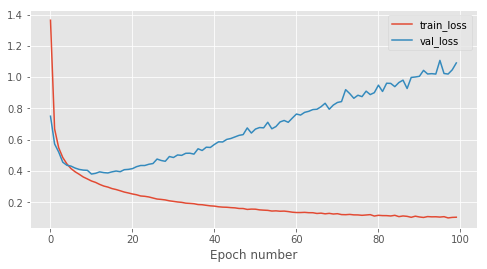

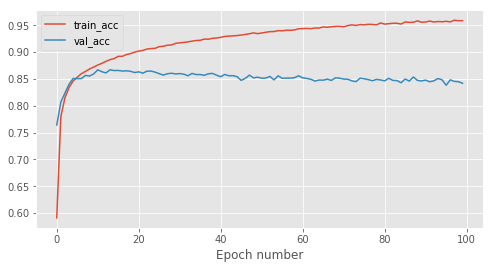

loss: 3.8338, accuracy: 0.0500:   2%|▏         | 15/1000 [00:00<00:10, 97.47it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 10, 10])
torch.Size([100, 64, 6, 6])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 2, 2])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, p

loss: 1.0425, accuracy: 0.6600:   2%|▏         | 18/1000 [00:00<00:10, 96.30it/s]

Epoch 0: train_acc_0.4776_train_loss_1.7336_val_acc_0.6466_val_loss_1.0965 epoch time 12.4098 seconds
total time0.0 : 12.409774541854858


loss: 0.9292, accuracy: 0.6800:   2%|▏         | 17/1000 [00:00<00:10, 93.71it/s]

Epoch 1: train_acc_0.6922_train_loss_0.9481_val_acc_0.7210_val_loss_0.8512 epoch time 12.3273 seconds
total time0.0 : 24.737061023712158


loss: 0.8129, accuracy: 0.7000:   2%|▏         | 17/1000 [00:00<00:10, 93.00it/s]

Epoch 2: train_acc_0.7490_train_loss_0.7565_val_acc_0.7766_val_loss_0.6905 epoch time 12.4531 seconds
total time0.0 : 37.19019031524658


loss: 0.5266, accuracy: 0.8200:   2%|▏         | 18/1000 [00:00<00:10, 93.82it/s]

Epoch 3: train_acc_0.7806_train_loss_0.6570_val_acc_0.7878_val_loss_0.6434 epoch time 12.3568 seconds
total time0.0 : 49.546982526779175


loss: 0.6551, accuracy: 0.8000:   2%|▏         | 17/1000 [00:00<00:10, 91.51it/s]

Epoch 4: train_acc_0.7984_train_loss_0.5991_val_acc_0.8001_val_loss_0.5830 epoch time 12.4278 seconds
total time1.0 : 1.9747400283813477


loss: 0.4507, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 97.73it/s]

Epoch 5: train_acc_0.8096_train_loss_0.5617_val_acc_0.8109_val_loss_0.5553 epoch time 12.3664 seconds
total time1.0 : 14.341111183166504


loss: 0.7613, accuracy: 0.7500:   2%|▏         | 18/1000 [00:00<00:10, 94.16it/s]

Epoch 6: train_acc_0.8205_train_loss_0.5263_val_acc_0.8121_val_loss_0.5532 epoch time 12.4084 seconds
total time1.0 : 26.74947714805603


loss: 0.6066, accuracy: 0.8300:   2%|▏         | 18/1000 [00:00<00:10, 94.72it/s]

Epoch 7: train_acc_0.8271_train_loss_0.5027_val_acc_0.8232_val_loss_0.5261 epoch time 12.3936 seconds
total time1.0 : 39.143067836761475


loss: 0.3738, accuracy: 0.8400:   2%|▏         | 18/1000 [00:00<00:10, 96.49it/s]

Epoch 8: train_acc_0.8333_train_loss_0.4814_val_acc_0.8256_val_loss_0.5033 epoch time 12.3420 seconds
total time1.0 : 51.48505115509033


loss: 0.3728, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 95.97it/s]

Epoch 9: train_acc_0.8375_train_loss_0.4642_val_acc_0.8299_val_loss_0.4912 epoch time 12.4340 seconds
total time2.0 : 3.919093132019043


loss: 0.3361, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 91.95it/s]

Epoch 10: train_acc_0.8421_train_loss_0.4504_val_acc_0.8294_val_loss_0.5080 epoch time 12.2591 seconds
total time2.0 : 16.178205490112305


loss: 0.3903, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 95.38it/s]

Epoch 11: train_acc_0.8445_train_loss_0.4391_val_acc_0.8382_val_loss_0.4723 epoch time 12.2995 seconds
total time2.0 : 28.47769260406494


loss: 0.3731, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 92.36it/s]

Epoch 12: train_acc_0.8492_train_loss_0.4249_val_acc_0.8364_val_loss_0.4785 epoch time 12.3292 seconds
total time2.0 : 40.806843519210815


loss: 0.3837, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 95.51it/s]

Epoch 13: train_acc_0.8527_train_loss_0.4148_val_acc_0.8337_val_loss_0.4841 epoch time 12.2141 seconds
total time2.0 : 53.02091383934021


loss: 0.4298, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 94.74it/s]

Epoch 14: train_acc_0.8541_train_loss_0.4075_val_acc_0.8434_val_loss_0.4632 epoch time 12.2698 seconds
total time3.0 : 5.290668487548828


loss: 0.1923, accuracy: 0.9400:   2%|▏         | 18/1000 [00:00<00:10, 96.08it/s]

Epoch 15: train_acc_0.8574_train_loss_0.3975_val_acc_0.8390_val_loss_0.4686 epoch time 12.3659 seconds
total time3.0 : 17.65661644935608


loss: 0.3050, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 93.47it/s]

Epoch 16: train_acc_0.8581_train_loss_0.3912_val_acc_0.8323_val_loss_0.4823 epoch time 12.3279 seconds
total time3.0 : 29.984517574310303


loss: 0.4569, accuracy: 0.8500:   2%|▏         | 17/1000 [00:00<00:10, 93.84it/s]

Epoch 17: train_acc_0.8610_train_loss_0.3833_val_acc_0.8358_val_loss_0.4720 epoch time 12.3824 seconds
total time3.0 : 42.366878032684326


loss: 0.2891, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 93.98it/s]

Epoch 18: train_acc_0.8636_train_loss_0.3764_val_acc_0.8446_val_loss_0.4554 epoch time 12.3502 seconds
total time3.0 : 54.71708011627197


loss: 0.3392, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 94.73it/s]

Epoch 19: train_acc_0.8648_train_loss_0.3698_val_acc_0.8441_val_loss_0.4634 epoch time 12.3597 seconds
total time4.0 : 7.076771259307861


loss: 0.2612, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 95.33it/s]

Epoch 20: train_acc_0.8668_train_loss_0.3644_val_acc_0.8431_val_loss_0.4675 epoch time 12.3250 seconds
total time4.0 : 19.401721477508545


loss: 0.3682, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 95.76it/s]

Epoch 21: train_acc_0.8701_train_loss_0.3568_val_acc_0.8409_val_loss_0.4589 epoch time 12.4278 seconds
total time4.0 : 31.829512119293213


loss: 0.2531, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 94.48it/s]

Epoch 22: train_acc_0.8705_train_loss_0.3523_val_acc_0.8385_val_loss_0.4732 epoch time 12.3473 seconds
total time4.0 : 44.17676568031311


loss: 0.2053, accuracy: 0.9300:   2%|▏         | 18/1000 [00:00<00:10, 94.13it/s]

Epoch 23: train_acc_0.8724_train_loss_0.3468_val_acc_0.8398_val_loss_0.4683 epoch time 12.3940 seconds
total time4.0 : 56.57073926925659


loss: 0.3274, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:10, 97.26it/s]

Epoch 24: train_acc_0.8724_train_loss_0.3415_val_acc_0.8354_val_loss_0.4824 epoch time 12.2875 seconds
total time5.0 : 8.858262538909912


loss: 0.2531, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 94.90it/s]

Epoch 25: train_acc_0.8747_train_loss_0.3373_val_acc_0.8396_val_loss_0.4764 epoch time 12.3205 seconds
total time5.0 : 21.178768396377563


loss: 0.2249, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 94.76it/s]

Epoch 26: train_acc_0.8765_train_loss_0.3304_val_acc_0.8423_val_loss_0.4701 epoch time 12.3388 seconds
total time5.0 : 33.51754879951477


loss: 0.3654, accuracy: 0.8600:   2%|▏         | 17/1000 [00:00<00:10, 92.74it/s]

Epoch 27: train_acc_0.8780_train_loss_0.3261_val_acc_0.8421_val_loss_0.4746 epoch time 12.3211 seconds
total time5.0 : 45.838685035705566


loss: 0.1883, accuracy: 0.9300:   2%|▏         | 18/1000 [00:00<00:10, 94.63it/s]

Epoch 28: train_acc_0.8786_train_loss_0.3239_val_acc_0.8433_val_loss_0.4756 epoch time 12.2966 seconds
total time5.0 : 58.135265588760376


loss: 0.1679, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 90.66it/s]

Epoch 29: train_acc_0.8800_train_loss_0.3182_val_acc_0.8423_val_loss_0.4764 epoch time 12.3252 seconds
total time6.0 : 10.460482835769653


loss: 0.2476, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 94.87it/s]

Epoch 30: train_acc_0.8818_train_loss_0.3150_val_acc_0.8437_val_loss_0.4825 epoch time 12.2466 seconds
total time6.0 : 22.707112073898315


loss: 0.2616, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 95.34it/s]

Epoch 31: train_acc_0.8832_train_loss_0.3104_val_acc_0.8387_val_loss_0.4935 epoch time 12.2844 seconds
total time6.0 : 34.99156165122986


loss: 0.2607, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 96.62it/s]

Epoch 32: train_acc_0.8844_train_loss_0.3063_val_acc_0.8413_val_loss_0.4952 epoch time 12.4311 seconds
total time6.0 : 47.422704458236694


loss: 0.4277, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 94.30it/s]

Epoch 33: train_acc_0.8848_train_loss_0.3026_val_acc_0.8393_val_loss_0.4949 epoch time 12.3845 seconds
total time6.0 : 59.80724740028381


loss: 0.2198, accuracy: 0.9400:   2%|▏         | 17/1000 [00:00<00:10, 92.31it/s]

Epoch 34: train_acc_0.8852_train_loss_0.3009_val_acc_0.8367_val_loss_0.4991 epoch time 12.4051 seconds
total time7.0 : 12.212387084960938


loss: 0.2540, accuracy: 0.8800:   2%|▏         | 17/1000 [00:00<00:10, 93.12it/s]

Epoch 35: train_acc_0.8860_train_loss_0.2967_val_acc_0.8403_val_loss_0.5006 epoch time 12.4845 seconds
total time7.0 : 24.696889877319336


loss: 0.3048, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 93.75it/s]

Epoch 36: train_acc_0.8881_train_loss_0.2928_val_acc_0.8369_val_loss_0.5091 epoch time 12.3768 seconds
total time7.0 : 37.073676109313965


loss: 0.3151, accuracy: 0.8700:   2%|▏         | 18/1000 [00:00<00:10, 96.24it/s]

Epoch 37: train_acc_0.8895_train_loss_0.2890_val_acc_0.8368_val_loss_0.5243 epoch time 12.3596 seconds
total time7.0 : 49.43324136734009


loss: 0.2961, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 95.80it/s]

Epoch 38: train_acc_0.8900_train_loss_0.2875_val_acc_0.8359_val_loss_0.5285 epoch time 12.2880 seconds
total time8.0 : 1.7212414741516113


loss: 0.3511, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 96.06it/s]

Epoch 39: train_acc_0.8915_train_loss_0.2846_val_acc_0.8415_val_loss_0.5083 epoch time 12.2869 seconds
total time8.0 : 14.00810194015503


loss: 0.2627, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:10, 92.72it/s]

Epoch 40: train_acc_0.8921_train_loss_0.2802_val_acc_0.8410_val_loss_0.5182 epoch time 12.3529 seconds
total time8.0 : 26.361024141311646


loss: 0.3001, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 94.41it/s]

Epoch 41: train_acc_0.8920_train_loss_0.2781_val_acc_0.8366_val_loss_0.5332 epoch time 12.4547 seconds
total time8.0 : 38.81571316719055


loss: 0.2598, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 95.04it/s]

Epoch 42: train_acc_0.8928_train_loss_0.2762_val_acc_0.8340_val_loss_0.5325 epoch time 12.3396 seconds
total time8.0 : 51.15533423423767


loss: 0.2938, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 94.15it/s]

Epoch 43: train_acc_0.8947_train_loss_0.2725_val_acc_0.8318_val_loss_0.5505 epoch time 12.3262 seconds
total time9.0 : 3.4815733432769775


loss: 0.1813, accuracy: 0.9400:   2%|▏         | 18/1000 [00:00<00:10, 97.02it/s]

Epoch 44: train_acc_0.8952_train_loss_0.2708_val_acc_0.8366_val_loss_0.5444 epoch time 12.3525 seconds
total time9.0 : 15.834066390991211


loss: 0.3056, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 92.54it/s]

Epoch 45: train_acc_0.8960_train_loss_0.2669_val_acc_0.8381_val_loss_0.5439 epoch time 12.4675 seconds
total time9.0 : 28.301520109176636


loss: 0.2712, accuracy: 0.8800:   2%|▏         | 17/1000 [00:00<00:10, 93.18it/s]

Epoch 46: train_acc_0.8959_train_loss_0.2670_val_acc_0.8361_val_loss_0.5561 epoch time 12.4573 seconds
total time9.0 : 40.75879788398743


loss: 0.2706, accuracy: 0.9000:   2%|▏         | 17/1000 [00:00<00:10, 92.19it/s]

Epoch 47: train_acc_0.8970_train_loss_0.2625_val_acc_0.8358_val_loss_0.5500 epoch time 12.4320 seconds
total time9.0 : 53.19076633453369


loss: 0.2610, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 93.93it/s]

Epoch 48: train_acc_0.8975_train_loss_0.2631_val_acc_0.8335_val_loss_0.5595 epoch time 12.3631 seconds
total time10.0 : 5.553915739059448


loss: 0.2008, accuracy: 0.9400:   2%|▏         | 18/1000 [00:00<00:10, 95.92it/s]

Epoch 49: train_acc_0.8978_train_loss_0.2577_val_acc_0.8349_val_loss_0.5695 epoch time 12.2765 seconds
total time10.0 : 17.83043360710144


loss: 0.1913, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 92.80it/s]

Epoch 50: train_acc_0.8984_train_loss_0.2573_val_acc_0.8370_val_loss_0.5752 epoch time 12.3934 seconds
total time10.0 : 30.223877668380737


loss: 0.3274, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 93.56it/s]

Epoch 51: train_acc_0.8995_train_loss_0.2546_val_acc_0.8320_val_loss_0.5758 epoch time 12.3391 seconds
total time10.0 : 42.56298589706421


loss: 0.2000, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 93.56it/s]

Epoch 52: train_acc_0.8998_train_loss_0.2524_val_acc_0.8283_val_loss_0.6004 epoch time 12.4232 seconds
total time10.0 : 54.986146450042725


loss: 0.2525, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 91.87it/s]

Epoch 53: train_acc_0.9031_train_loss_0.2450_val_acc_0.8364_val_loss_0.5763 epoch time 12.5023 seconds
total time11.0 : 7.488444089889526


loss: 0.2188, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 92.42it/s]

Epoch 54: train_acc_0.9006_train_loss_0.2518_val_acc_0.8313_val_loss_0.5813 epoch time 12.3530 seconds
total time11.0 : 19.841477155685425


loss: 0.1795, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 95.00it/s]

Epoch 55: train_acc_0.9034_train_loss_0.2447_val_acc_0.8283_val_loss_0.5956 epoch time 12.3576 seconds
total time11.0 : 32.19910955429077


loss: 0.1716, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 92.86it/s]

Epoch 56: train_acc_0.9025_train_loss_0.2445_val_acc_0.8294_val_loss_0.6066 epoch time 12.3403 seconds
total time11.0 : 44.53944540023804


loss: 0.2554, accuracy: 0.8800:   2%|▏         | 17/1000 [00:00<00:10, 92.51it/s]

Epoch 57: train_acc_0.9029_train_loss_0.2449_val_acc_0.8352_val_loss_0.5987 epoch time 12.2951 seconds
total time11.0 : 56.83458662033081


loss: 0.2262, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 94.25it/s]

Epoch 58: train_acc_0.9051_train_loss_0.2395_val_acc_0.8298_val_loss_0.6198 epoch time 12.3147 seconds
total time12.0 : 9.149297714233398


loss: 0.1506, accuracy: 0.9500:   2%|▏         | 18/1000 [00:00<00:10, 93.46it/s]

Epoch 59: train_acc_0.9051_train_loss_0.2393_val_acc_0.8323_val_loss_0.6203 epoch time 12.2617 seconds
total time12.0 : 21.41096305847168


loss: 0.2753, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 94.62it/s]

Epoch 60: train_acc_0.9048_train_loss_0.2387_val_acc_0.8302_val_loss_0.6280 epoch time 12.3635 seconds
total time12.0 : 33.77442502975464


loss: 0.2396, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 94.36it/s]

Epoch 61: train_acc_0.9073_train_loss_0.2332_val_acc_0.8271_val_loss_0.6491 epoch time 12.4301 seconds
total time12.0 : 46.20448184013367


loss: 0.2610, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 94.76it/s]

Epoch 62: train_acc_0.9069_train_loss_0.2333_val_acc_0.8330_val_loss_0.6259 epoch time 12.3675 seconds
total time12.0 : 58.57200622558594


loss: 0.2590, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 94.52it/s]

Epoch 63: train_acc_0.9082_train_loss_0.2302_val_acc_0.8284_val_loss_0.6401 epoch time 12.3033 seconds
total time13.0 : 10.875325918197632


loss: 0.2330, accuracy: 0.9100:   2%|▏         | 17/1000 [00:00<00:10, 91.66it/s]

Epoch 64: train_acc_0.9074_train_loss_0.2312_val_acc_0.8257_val_loss_0.6592 epoch time 12.3517 seconds
total time13.0 : 23.22698450088501


loss: 0.1464, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 94.96it/s]

Epoch 65: train_acc_0.9085_train_loss_0.2285_val_acc_0.8297_val_loss_0.6412 epoch time 12.4527 seconds
total time13.0 : 35.67966151237488


loss: 0.1938, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 96.36it/s]

Epoch 66: train_acc_0.9088_train_loss_0.2268_val_acc_0.8297_val_loss_0.6495 epoch time 12.4305 seconds
total time13.0 : 48.11019706726074


loss: 0.2359, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 93.06it/s]

Epoch 67: train_acc_0.9090_train_loss_0.2248_val_acc_0.8294_val_loss_0.6563 epoch time 12.3276 seconds
total time14.0 : 0.4377872943878174


loss: 0.1627, accuracy: 0.9600:   2%|▏         | 18/1000 [00:00<00:09, 98.62it/s]

Epoch 68: train_acc_0.9096_train_loss_0.2247_val_acc_0.8281_val_loss_0.6865 epoch time 12.3946 seconds
total time14.0 : 12.832418203353882


loss: 0.1626, accuracy: 0.9300:   2%|▏         | 18/1000 [00:00<00:10, 93.33it/s]

Epoch 69: train_acc_0.9117_train_loss_0.2202_val_acc_0.8241_val_loss_0.6755 epoch time 12.3932 seconds
total time14.0 : 25.225608825683594


loss: 0.1612, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 94.88it/s]

Epoch 70: train_acc_0.9105_train_loss_0.2231_val_acc_0.8253_val_loss_0.6778 epoch time 12.3657 seconds
total time14.0 : 37.59134030342102


loss: 0.2888, accuracy: 0.8700:   2%|▏         | 17/1000 [00:00<00:10, 92.68it/s]

Epoch 71: train_acc_0.9117_train_loss_0.2192_val_acc_0.8281_val_loss_0.6737 epoch time 12.4727 seconds
total time14.0 : 50.06403708457947


loss: 0.2626, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 95.60it/s]

Epoch 72: train_acc_0.9125_train_loss_0.2189_val_acc_0.8283_val_loss_0.6787 epoch time 12.4290 seconds
total time15.0 : 2.4930384159088135


loss: 0.1730, accuracy: 0.9200:   2%|▏         | 18/1000 [00:00<00:10, 94.92it/s]

Epoch 73: train_acc_0.9123_train_loss_0.2161_val_acc_0.8276_val_loss_0.6846 epoch time 12.3156 seconds
total time15.0 : 14.808676958084106


loss: 0.0597, accuracy: 0.9900:   2%|▏         | 18/1000 [00:00<00:10, 95.33it/s]

Epoch 74: train_acc_0.9122_train_loss_0.2159_val_acc_0.8287_val_loss_0.6951 epoch time 12.3543 seconds
total time15.0 : 27.162964582443237


loss: 0.2340, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 92.55it/s]

Epoch 75: train_acc_0.9135_train_loss_0.2147_val_acc_0.8280_val_loss_0.6895 epoch time 12.3749 seconds
total time15.0 : 39.537896156311035


loss: 0.2322, accuracy: 0.8900:   2%|▏         | 17/1000 [00:00<00:10, 93.99it/s]

Epoch 76: train_acc_0.9133_train_loss_0.2135_val_acc_0.8214_val_loss_0.7370 epoch time 12.4015 seconds
total time15.0 : 51.93940806388855


loss: 0.3587, accuracy: 0.8800:   2%|▏         | 18/1000 [00:00<00:10, 94.37it/s]

Epoch 77: train_acc_0.9141_train_loss_0.2119_val_acc_0.8275_val_loss_0.7102 epoch time 12.3661 seconds
total time16.0 : 4.30547022819519


loss: 0.1880, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 94.80it/s]

Epoch 78: train_acc_0.9155_train_loss_0.2083_val_acc_0.8235_val_loss_0.7312 epoch time 12.2250 seconds
total time16.0 : 16.53046703338623


loss: 0.1058, accuracy: 0.9600:   2%|▏         | 18/1000 [00:00<00:10, 97.05it/s]

Epoch 79: train_acc_0.9153_train_loss_0.2094_val_acc_0.8282_val_loss_0.7243 epoch time 12.2745 seconds
total time16.0 : 28.805001735687256


loss: 0.1800, accuracy: 0.9100:   2%|▏         | 18/1000 [00:00<00:10, 95.07it/s]

Epoch 80: train_acc_0.9158_train_loss_0.2079_val_acc_0.8226_val_loss_0.7330 epoch time 12.3098 seconds
total time16.0 : 41.114837884902954


loss: 0.2043, accuracy: 0.8900:   2%|▏         | 17/1000 [00:00<00:10, 91.25it/s]

Epoch 81: train_acc_0.9167_train_loss_0.2066_val_acc_0.8192_val_loss_0.7467 epoch time 12.3541 seconds
total time16.0 : 53.46898293495178


loss: 0.1940, accuracy: 0.9400:   2%|▏         | 17/1000 [00:00<00:10, 91.66it/s]

Epoch 82: train_acc_0.9161_train_loss_0.2052_val_acc_0.8225_val_loss_0.7558 epoch time 12.4855 seconds
total time17.0 : 5.954450368881226


loss: 0.2586, accuracy: 0.9000:   2%|▏         | 18/1000 [00:00<00:10, 94.39it/s]

Epoch 83: train_acc_0.9146_train_loss_0.2085_val_acc_0.8222_val_loss_0.7492 epoch time 12.3719 seconds
total time17.0 : 18.32639193534851


loss: 0.1596, accuracy: 0.9400:   2%|▏         | 18/1000 [00:00<00:10, 95.74it/s]

Epoch 84: train_acc_0.9176_train_loss_0.2034_val_acc_0.8279_val_loss_0.7341 epoch time 12.3023 seconds
total time17.0 : 30.62873339653015


loss: 0.1132, accuracy: 0.9700:   2%|▏         | 18/1000 [00:00<00:10, 96.37it/s]

Epoch 85: train_acc_0.9164_train_loss_0.2049_val_acc_0.8222_val_loss_0.7634 epoch time 12.2661 seconds
total time17.0 : 42.89487648010254


loss: 0.3194, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 96.03it/s]

Epoch 86: train_acc_0.9179_train_loss_0.2014_val_acc_0.8280_val_loss_0.7598 epoch time 12.3189 seconds
total time17.0 : 55.213823556900024


loss: 0.3163, accuracy: 0.8600:   2%|▏         | 18/1000 [00:00<00:10, 97.26it/s]

Epoch 87: train_acc_0.9190_train_loss_0.1998_val_acc_0.8230_val_loss_0.7750 epoch time 12.3922 seconds
total time18.0 : 7.606065988540649


loss: 0.1431, accuracy: 0.9500:   2%|▏         | 17/1000 [00:00<00:10, 93.00it/s]

Epoch 88: train_acc_0.9179_train_loss_0.2009_val_acc_0.8289_val_loss_0.7538 epoch time 12.2787 seconds
total time18.0 : 19.884775161743164


loss: 0.1874, accuracy: 0.9300:   2%|▏         | 18/1000 [00:00<00:10, 94.76it/s]

Epoch 89: train_acc_0.9192_train_loss_0.1982_val_acc_0.8259_val_loss_0.7488 epoch time 12.3986 seconds
total time18.0 : 32.28340983390808


loss: 0.0822, accuracy: 0.9500:   2%|▏         | 18/1000 [00:00<00:10, 94.11it/s]

Epoch 90: train_acc_0.9188_train_loss_0.1988_val_acc_0.8155_val_loss_0.7980 epoch time 12.3573 seconds
total time18.0 : 44.64075422286987


loss: 0.1713, accuracy: 0.9200:   2%|▏         | 17/1000 [00:00<00:10, 94.94it/s]

Epoch 91: train_acc_0.9185_train_loss_0.1982_val_acc_0.8213_val_loss_0.7623 epoch time 12.3592 seconds
total time18.0 : 56.999913692474365


loss: 0.2899, accuracy: 0.8500:   2%|▏         | 18/1000 [00:00<00:10, 95.66it/s]

Epoch 92: train_acc_0.9206_train_loss_0.1935_val_acc_0.8227_val_loss_0.7911 epoch time 12.4156 seconds
total time19.0 : 9.415542364120483


loss: 0.1689, accuracy: 0.9300:   2%|▏         | 17/1000 [00:00<00:10, 93.07it/s]

Epoch 93: train_acc_0.9222_train_loss_0.1927_val_acc_0.8228_val_loss_0.7942 epoch time 12.3454 seconds
total time19.0 : 21.7609601020813


loss: 0.1300, accuracy: 0.9500:   2%|▏         | 17/1000 [00:00<00:10, 93.68it/s]

Epoch 94: train_acc_0.9196_train_loss_0.1970_val_acc_0.8203_val_loss_0.8078 epoch time 12.4712 seconds
total time19.0 : 34.23219299316406


loss: 0.2825, accuracy: 0.8900:   2%|▏         | 18/1000 [00:00<00:10, 95.46it/s]

Epoch 95: train_acc_0.9215_train_loss_0.1911_val_acc_0.8127_val_loss_0.8412 epoch time 12.3886 seconds
total time19.0 : 46.620800733566284


loss: 0.0931, accuracy: 0.9700:   2%|▏         | 18/1000 [00:00<00:10, 91.36it/s]

Epoch 96: train_acc_0.9216_train_loss_0.1912_val_acc_0.8178_val_loss_0.8223 epoch time 12.3785 seconds
total time19.0 : 58.99927353858948


loss: 0.1495, accuracy: 0.9600:   2%|▏         | 18/1000 [00:00<00:10, 96.71it/s]

Epoch 97: train_acc_0.9216_train_loss_0.1902_val_acc_0.8161_val_loss_0.8317 epoch time 12.3565 seconds
total time20.0 : 11.355737209320068


loss: 0.0956, accuracy: 0.9600:   2%|▏         | 18/1000 [00:00<00:10, 95.91it/s]

Epoch 98: train_acc_0.9213_train_loss_0.1926_val_acc_0.8179_val_loss_0.8410 epoch time 12.2815 seconds
total time20.0 : 23.63721227645874


loss: 0.3134, accuracy: 0.8500:  18%|█▊        | 29/158 [00:00<00:00, 159.92it/s]

Epoch 99: train_acc_0.9227_train_loss_0.1867_val_acc_0.8187_val_loss_0.8357 epoch time 12.3827 seconds
total time20.0 : 36.019893646240234
Generating test set evaluation metrics


loss: 0.4417, accuracy: 0.8300: 100%|██████████| 158/158 [00:01<00:00, 151.15it/s]


finish


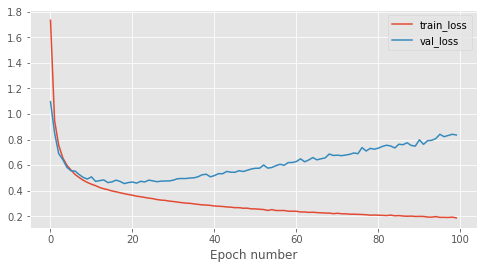

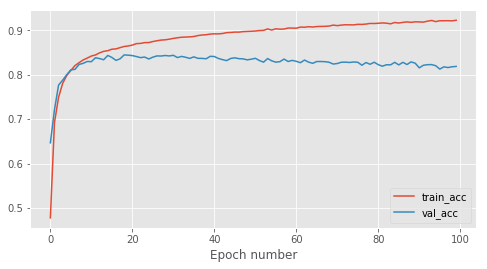

loss: 3.8514, accuracy: 0.0300:   2%|▏         | 16/1000 [00:00<00:09, 103.74it/s]

Building basic block of ConvolutionalNetwork using input shape (100, 1, 28, 28)
torch.Size([100, 64, 7, 7])
torch.Size([100, 64, 4, 4])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])
shape before final linear layer torch.Size([100, 64, 2, 2])
Block is built, output volume is torch.Size([100, 47])
use GPU
ConvolutionalNetwork(
  (layer_dict): ModuleDict(
    (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (dim_reduction_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (dim_reduction_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (dim_reduction_max_pool_2): MaxPool2d(kernel_size=2, stride=2, pad

loss: 3.4961, accuracy: 0.0700:   2%|▏         | 20/1000 [00:00<00:09, 106.92it/s]

Epoch 0: train_acc_0.0505_train_loss_3.6312_val_acc_0.0682_val_loss_3.4879 epoch time 11.4841 seconds
total time0.0 : 11.484147548675537


loss: 3.3826, accuracy: 0.0600:   2%|▏         | 19/1000 [00:00<00:09, 101.33it/s]

Epoch 1: train_acc_0.0827_train_loss_3.4005_val_acc_0.0935_val_loss_3.3338 epoch time 11.5014 seconds
total time0.0 : 22.98556113243103


loss: 3.3046, accuracy: 0.1000:   2%|▏         | 19/1000 [00:00<00:09, 101.97it/s]

Epoch 2: train_acc_0.1011_train_loss_3.2873_val_acc_0.1087_val_loss_3.2630 epoch time 11.6016 seconds
total time0.0 : 34.58717226982117


loss: 3.2302, accuracy: 0.0800:   2%|▏         | 19/1000 [00:00<00:09, 100.90it/s]

Epoch 3: train_acc_0.1121_train_loss_3.2337_val_acc_0.1166_val_loss_3.2109 epoch time 11.4474 seconds
total time0.0 : 46.03461146354675


loss: 3.1037, accuracy: 0.1500:   2%|▏         | 19/1000 [00:00<00:09, 98.99it/s]

Epoch 4: train_acc_0.1213_train_loss_3.1844_val_acc_0.1261_val_loss_3.1822 epoch time 11.6177 seconds
total time0.0 : 57.65233898162842


loss: 3.2434, accuracy: 0.1500:   2%|▏         | 19/1000 [00:00<00:09, 102.09it/s]

Epoch 5: train_acc_0.1276_train_loss_3.1517_val_acc_0.1278_val_loss_3.1494 epoch time 11.5812 seconds
total time1.0 : 9.233553171157837


loss: 3.1882, accuracy: 0.1300:   2%|▏         | 19/1000 [00:00<00:09, 100.36it/s]

Epoch 6: train_acc_0.1319_train_loss_3.1303_val_acc_0.1300_val_loss_3.1272 epoch time 11.6441 seconds
total time1.0 : 20.87764573097229


loss: 2.9375, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 98.31it/s]

Epoch 7: train_acc_0.1362_train_loss_3.1101_val_acc_0.1360_val_loss_3.1046 epoch time 11.5664 seconds
total time1.0 : 32.44404864311218


loss: 3.2340, accuracy: 0.1100:   2%|▏         | 19/1000 [00:00<00:09, 102.76it/s]

Epoch 8: train_acc_0.1384_train_loss_3.0922_val_acc_0.1376_val_loss_3.0938 epoch time 11.5419 seconds
total time1.0 : 43.98593235015869


loss: 3.2405, accuracy: 0.0700:   2%|▏         | 19/1000 [00:00<00:09, 103.77it/s]

Epoch 9: train_acc_0.1406_train_loss_3.0778_val_acc_0.1406_val_loss_3.0818 epoch time 11.5040 seconds
total time1.0 : 55.489898920059204


loss: 2.9063, accuracy: 0.1200:   2%|▏         | 19/1000 [00:00<00:09, 99.93it/s]

Epoch 10: train_acc_0.1436_train_loss_3.0647_val_acc_0.1452_val_loss_3.0574 epoch time 11.6385 seconds
total time2.0 : 7.128356456756592


loss: 3.1202, accuracy: 0.1100:   2%|▏         | 19/1000 [00:00<00:09, 103.45it/s]

Epoch 11: train_acc_0.1456_train_loss_3.0530_val_acc_0.1477_val_loss_3.0537 epoch time 11.5844 seconds
total time2.0 : 18.712757110595703


loss: 3.0665, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 101.57it/s]

Epoch 12: train_acc_0.1488_train_loss_3.0425_val_acc_0.1474_val_loss_3.0509 epoch time 11.6874 seconds
total time2.0 : 30.400118350982666


loss: 2.9125, accuracy: 0.1300:   2%|▏         | 20/1000 [00:00<00:09, 107.90it/s]

Epoch 13: train_acc_0.1487_train_loss_3.0350_val_acc_0.1513_val_loss_3.0287 epoch time 11.5689 seconds
total time2.0 : 41.96897006034851


loss: 2.9739, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 99.85it/s]

Epoch 14: train_acc_0.1501_train_loss_3.0260_val_acc_0.1535_val_loss_3.0189 epoch time 11.5834 seconds
total time2.0 : 53.55232381820679


loss: 3.2201, accuracy: 0.1400:   2%|▏         | 19/1000 [00:00<00:10, 97.69it/s]

Epoch 15: train_acc_0.1521_train_loss_3.0177_val_acc_0.1520_val_loss_3.0207 epoch time 11.6130 seconds
total time3.0 : 5.165340185165405


loss: 2.9826, accuracy: 0.1400:   2%|▏         | 19/1000 [00:00<00:09, 101.83it/s]

Epoch 16: train_acc_0.1538_train_loss_3.0125_val_acc_0.1534_val_loss_3.0127 epoch time 11.6128 seconds
total time3.0 : 16.77815556526184


loss: 2.8887, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 99.92it/s]

Epoch 17: train_acc_0.1542_train_loss_3.0061_val_acc_0.1510_val_loss_3.0099 epoch time 11.5339 seconds
total time3.0 : 28.312031269073486


loss: 3.0272, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 101.71it/s]

Epoch 18: train_acc_0.1544_train_loss_2.9996_val_acc_0.1536_val_loss_3.0179 epoch time 11.5526 seconds
total time3.0 : 39.86460995674133


loss: 3.0157, accuracy: 0.1200:   2%|▏         | 19/1000 [00:00<00:09, 101.61it/s]

Epoch 19: train_acc_0.1575_train_loss_2.9935_val_acc_0.1565_val_loss_2.9962 epoch time 11.5220 seconds
total time3.0 : 51.38661050796509


loss: 2.9335, accuracy: 0.1400:   2%|▏         | 20/1000 [00:00<00:09, 105.85it/s]

Epoch 20: train_acc_0.1577_train_loss_2.9888_val_acc_0.1559_val_loss_2.9975 epoch time 11.5593 seconds
total time4.0 : 2.945906639099121


loss: 3.0113, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 101.42it/s]

Epoch 21: train_acc_0.1603_train_loss_2.9845_val_acc_0.1549_val_loss_3.0069 epoch time 11.5389 seconds
total time4.0 : 14.484806776046753


loss: 3.0013, accuracy: 0.1900:   2%|▏         | 20/1000 [00:00<00:09, 102.95it/s]

Epoch 22: train_acc_0.1606_train_loss_2.9785_val_acc_0.1593_val_loss_2.9921 epoch time 11.5535 seconds
total time4.0 : 26.038304805755615


loss: 3.0020, accuracy: 0.2300:   2%|▏         | 19/1000 [00:00<00:09, 100.16it/s]

Epoch 23: train_acc_0.1603_train_loss_2.9756_val_acc_0.1582_val_loss_2.9972 epoch time 11.5009 seconds
total time4.0 : 37.53918147087097


loss: 3.0079, accuracy: 0.1400:   2%|▏         | 19/1000 [00:00<00:09, 101.73it/s]

Epoch 24: train_acc_0.1602_train_loss_2.9706_val_acc_0.1605_val_loss_2.9809 epoch time 11.6763 seconds
total time4.0 : 49.215489864349365


loss: 2.9782, accuracy: 0.1300:   2%|▏         | 19/1000 [00:00<00:09, 99.77it/s]

Epoch 25: train_acc_0.1623_train_loss_2.9673_val_acc_0.1654_val_loss_2.9739 epoch time 11.5673 seconds
total time5.0 : 0.7828187942504883


loss: 2.9436, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 102.13it/s]

Epoch 26: train_acc_0.1624_train_loss_2.9635_val_acc_0.1639_val_loss_2.9752 epoch time 11.5855 seconds
total time5.0 : 12.368347883224487


loss: 3.1011, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 101.83it/s]

Epoch 27: train_acc_0.1631_train_loss_2.9605_val_acc_0.1623_val_loss_2.9723 epoch time 11.4539 seconds
total time5.0 : 23.822219133377075


loss: 3.0309, accuracy: 0.1400:   2%|▏         | 19/1000 [00:00<00:09, 102.04it/s]

Epoch 28: train_acc_0.1643_train_loss_2.9572_val_acc_0.1601_val_loss_2.9871 epoch time 11.6304 seconds
total time5.0 : 35.4526002407074


loss: 3.0687, accuracy: 0.1000:   2%|▏         | 19/1000 [00:00<00:09, 100.48it/s]

Epoch 29: train_acc_0.1661_train_loss_2.9545_val_acc_0.1628_val_loss_2.9694 epoch time 11.4600 seconds
total time5.0 : 46.912593364715576


loss: 2.7625, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 99.87it/s]

Epoch 30: train_acc_0.1658_train_loss_2.9508_val_acc_0.1611_val_loss_2.9663 epoch time 11.5881 seconds
total time5.0 : 58.500649213790894


loss: 3.2646, accuracy: 0.0900:   2%|▏         | 18/1000 [00:00<00:10, 97.18it/s]

Epoch 31: train_acc_0.1658_train_loss_2.9496_val_acc_0.1647_val_loss_2.9643 epoch time 11.6495 seconds
total time6.0 : 10.150107860565186


loss: 3.0969, accuracy: 0.1100:   2%|▏         | 19/1000 [00:00<00:09, 99.32it/s]

Epoch 32: train_acc_0.1661_train_loss_2.9475_val_acc_0.1642_val_loss_2.9719 epoch time 11.7039 seconds
total time6.0 : 21.85401177406311


loss: 2.9432, accuracy: 0.1800:   2%|▏         | 18/1000 [00:00<00:10, 98.06it/s]

Epoch 33: train_acc_0.1673_train_loss_2.9447_val_acc_0.1630_val_loss_2.9822 epoch time 11.6282 seconds
total time6.0 : 33.48222756385803


loss: 2.9794, accuracy: 0.1200:   2%|▏         | 19/1000 [00:00<00:09, 101.08it/s]

Epoch 34: train_acc_0.1667_train_loss_2.9425_val_acc_0.1666_val_loss_2.9562 epoch time 11.6196 seconds
total time6.0 : 45.10187220573425


loss: 2.9628, accuracy: 0.1900:   2%|▏         | 18/1000 [00:00<00:09, 98.27it/s]

Epoch 35: train_acc_0.1669_train_loss_2.9397_val_acc_0.1673_val_loss_2.9595 epoch time 11.5825 seconds
total time6.0 : 56.684398889541626


loss: 2.9197, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 102.44it/s]

Epoch 36: train_acc_0.1674_train_loss_2.9374_val_acc_0.1651_val_loss_2.9623 epoch time 11.5476 seconds
total time7.0 : 8.232022285461426


loss: 2.9164, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 102.45it/s]

Epoch 37: train_acc_0.1698_train_loss_2.9352_val_acc_0.1646_val_loss_2.9726 epoch time 11.5830 seconds
total time7.0 : 19.81497359275818


loss: 3.0259, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 101.01it/s]

Epoch 38: train_acc_0.1687_train_loss_2.9347_val_acc_0.1627_val_loss_2.9575 epoch time 11.5584 seconds
total time7.0 : 31.373414039611816


loss: 2.8572, accuracy: 0.2100:   2%|▏         | 18/1000 [00:00<00:09, 99.48it/s]

Epoch 39: train_acc_0.1695_train_loss_2.9309_val_acc_0.1668_val_loss_2.9538 epoch time 11.6185 seconds
total time7.0 : 42.991923093795776


loss: 2.8849, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 102.21it/s]

Epoch 40: train_acc_0.1700_train_loss_2.9287_val_acc_0.1644_val_loss_2.9598 epoch time 11.6533 seconds
total time7.0 : 54.64525771141052


loss: 2.5996, accuracy: 0.2300:   2%|▏         | 19/1000 [00:00<00:09, 99.84it/s]

Epoch 41: train_acc_0.1702_train_loss_2.9275_val_acc_0.1657_val_loss_2.9532 epoch time 11.5571 seconds
total time8.0 : 6.202355146408081


loss: 2.7365, accuracy: 0.2500:   2%|▏         | 19/1000 [00:00<00:09, 102.65it/s]

Epoch 42: train_acc_0.1695_train_loss_2.9255_val_acc_0.1645_val_loss_2.9557 epoch time 11.6812 seconds
total time8.0 : 17.883559226989746


loss: 2.8138, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 100.04it/s]

Epoch 43: train_acc_0.1706_train_loss_2.9233_val_acc_0.1639_val_loss_2.9516 epoch time 11.6123 seconds
total time8.0 : 29.49581289291382


loss: 2.8739, accuracy: 0.2300:   2%|▏         | 18/1000 [00:00<00:09, 99.35it/s]

Epoch 44: train_acc_0.1703_train_loss_2.9222_val_acc_0.1663_val_loss_2.9439 epoch time 11.7042 seconds
total time8.0 : 41.20004081726074


loss: 3.0695, accuracy: 0.1100:   2%|▏         | 19/1000 [00:00<00:09, 100.66it/s]

Epoch 45: train_acc_0.1715_train_loss_2.9199_val_acc_0.1666_val_loss_2.9534 epoch time 11.5392 seconds
total time8.0 : 52.739261865615845


loss: 2.9067, accuracy: 0.1300:   2%|▏         | 19/1000 [00:00<00:09, 101.98it/s]

Epoch 46: train_acc_0.1712_train_loss_2.9182_val_acc_0.1681_val_loss_2.9412 epoch time 11.6201 seconds
total time9.0 : 4.3593244552612305


loss: 2.7470, accuracy: 0.2200:   2%|▏         | 19/1000 [00:00<00:09, 99.90it/s]

Epoch 47: train_acc_0.1720_train_loss_2.9174_val_acc_0.1659_val_loss_2.9460 epoch time 11.5954 seconds
total time9.0 : 15.954704284667969


loss: 2.8495, accuracy: 0.2300:   2%|▏         | 19/1000 [00:00<00:09, 99.24it/s]

Epoch 48: train_acc_0.1704_train_loss_2.9159_val_acc_0.1677_val_loss_2.9468 epoch time 11.7184 seconds
total time9.0 : 27.67307686805725


loss: 2.7528, accuracy: 0.2000:   2%|▏         | 19/1000 [00:00<00:09, 101.92it/s]

Epoch 49: train_acc_0.1714_train_loss_2.9129_val_acc_0.1660_val_loss_2.9546 epoch time 11.5532 seconds
total time9.0 : 39.22627067565918


loss: 2.9037, accuracy: 0.2000:   2%|▏         | 20/1000 [00:00<00:09, 103.68it/s]

Epoch 50: train_acc_0.1731_train_loss_2.9118_val_acc_0.1683_val_loss_2.9479 epoch time 11.5980 seconds
total time9.0 : 50.82427930831909


loss: 2.9636, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 99.13it/s]

Epoch 51: train_acc_0.1739_train_loss_2.9119_val_acc_0.1639_val_loss_2.9491 epoch time 11.5304 seconds
total time10.0 : 2.354707717895508


loss: 2.7854, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 100.50it/s]

Epoch 52: train_acc_0.1731_train_loss_2.9099_val_acc_0.1680_val_loss_2.9452 epoch time 11.5914 seconds
total time10.0 : 13.946063756942749


loss: 2.9934, accuracy: 0.2000:   2%|▏         | 19/1000 [00:00<00:09, 99.58it/s]

Epoch 53: train_acc_0.1720_train_loss_2.9091_val_acc_0.1675_val_loss_2.9592 epoch time 11.5000 seconds
total time10.0 : 25.446099519729614


loss: 2.7961, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 101.35it/s]

Epoch 54: train_acc_0.1733_train_loss_2.9080_val_acc_0.1664_val_loss_2.9506 epoch time 11.5457 seconds
total time10.0 : 36.99177432060242


loss: 3.0000, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 98.74it/s]

Epoch 55: train_acc_0.1741_train_loss_2.9059_val_acc_0.1678_val_loss_2.9461 epoch time 11.5059 seconds
total time10.0 : 48.49763202667236


loss: 2.8435, accuracy: 0.1300:   2%|▏         | 19/1000 [00:00<00:09, 102.19it/s]

Epoch 56: train_acc_0.1740_train_loss_2.9053_val_acc_0.1674_val_loss_2.9493 epoch time 11.6239 seconds
total time11.0 : 0.12154102325439453


loss: 2.8007, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 100.17it/s]

Epoch 57: train_acc_0.1733_train_loss_2.9039_val_acc_0.1675_val_loss_2.9453 epoch time 11.5623 seconds
total time11.0 : 11.683890104293823


loss: 3.0458, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 100.04it/s]

Epoch 58: train_acc_0.1751_train_loss_2.9036_val_acc_0.1635_val_loss_2.9437 epoch time 11.6252 seconds
total time11.0 : 23.30909490585327


loss: 2.8744, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 101.31it/s]

Epoch 59: train_acc_0.1740_train_loss_2.9016_val_acc_0.1626_val_loss_2.9524 epoch time 11.6558 seconds
total time11.0 : 34.96484851837158


loss: 2.8408, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 100.36it/s]

Epoch 60: train_acc_0.1755_train_loss_2.8990_val_acc_0.1675_val_loss_2.9394 epoch time 11.5232 seconds
total time11.0 : 46.48803353309631


loss: 2.8288, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 99.01it/s]

Epoch 61: train_acc_0.1764_train_loss_2.8995_val_acc_0.1646_val_loss_2.9530 epoch time 11.5754 seconds
total time11.0 : 58.06342887878418


loss: 2.8240, accuracy: 0.2200:   2%|▏         | 19/1000 [00:00<00:09, 104.54it/s]

Epoch 62: train_acc_0.1760_train_loss_2.8977_val_acc_0.1661_val_loss_2.9472 epoch time 11.7274 seconds
total time12.0 : 9.79079294204712


loss: 2.8737, accuracy: 0.1800:   2%|▏         | 18/1000 [00:00<00:09, 100.81it/s]

Epoch 63: train_acc_0.1757_train_loss_2.8987_val_acc_0.1676_val_loss_2.9417 epoch time 11.5609 seconds
total time12.0 : 21.35169768333435


loss: 2.7311, accuracy: 0.2000:   2%|▏         | 19/1000 [00:00<00:09, 98.80it/s]

Epoch 64: train_acc_0.1761_train_loss_2.8970_val_acc_0.1663_val_loss_2.9446 epoch time 11.7218 seconds
total time12.0 : 33.0735125541687


loss: 2.9991, accuracy: 0.1000:   2%|▏         | 19/1000 [00:00<00:09, 101.58it/s]

Epoch 65: train_acc_0.1760_train_loss_2.8947_val_acc_0.1646_val_loss_2.9476 epoch time 11.6458 seconds
total time12.0 : 44.71926832199097


loss: 2.6494, accuracy: 0.2600:   2%|▏         | 18/1000 [00:00<00:09, 99.72it/s]

Epoch 66: train_acc_0.1758_train_loss_2.8939_val_acc_0.1672_val_loss_2.9432 epoch time 11.6568 seconds
total time12.0 : 56.37608814239502


loss: 2.8885, accuracy: 0.1700:   2%|▏         | 19/1000 [00:00<00:09, 101.62it/s]

Epoch 67: train_acc_0.1767_train_loss_2.8930_val_acc_0.1659_val_loss_2.9433 epoch time 11.6061 seconds
total time13.0 : 7.982165575027466


loss: 2.8271, accuracy: 0.1500:   2%|▏         | 19/1000 [00:00<00:09, 100.73it/s]

Epoch 68: train_acc_0.1759_train_loss_2.8918_val_acc_0.1651_val_loss_2.9521 epoch time 11.6594 seconds
total time13.0 : 19.64153289794922


loss: 2.8315, accuracy: 0.1500:   2%|▏         | 19/1000 [00:00<00:09, 100.90it/s]

Epoch 69: train_acc_0.1767_train_loss_2.8913_val_acc_0.1653_val_loss_2.9479 epoch time 11.5535 seconds
total time13.0 : 31.195037603378296


loss: 2.9248, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 101.21it/s]

Epoch 70: train_acc_0.1774_train_loss_2.8907_val_acc_0.1673_val_loss_2.9512 epoch time 11.4627 seconds
total time13.0 : 42.65774726867676


loss: 2.9119, accuracy: 0.1500:   2%|▏         | 19/1000 [00:00<00:09, 101.84it/s]

Epoch 71: train_acc_0.1780_train_loss_2.8894_val_acc_0.1677_val_loss_2.9371 epoch time 11.5780 seconds
total time13.0 : 54.235777854919434


loss: 2.8036, accuracy: 0.2100:   2%|▏         | 19/1000 [00:00<00:09, 102.53it/s]

Epoch 72: train_acc_0.1773_train_loss_2.8877_val_acc_0.1708_val_loss_2.9436 epoch time 11.6589 seconds
total time14.0 : 5.89465594291687


loss: 3.1383, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 101.40it/s]

Epoch 73: train_acc_0.1785_train_loss_2.8869_val_acc_0.1680_val_loss_2.9400 epoch time 11.4631 seconds
total time14.0 : 17.357783555984497


loss: 2.8920, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 100.09it/s]

Epoch 74: train_acc_0.1805_train_loss_2.8867_val_acc_0.1682_val_loss_2.9482 epoch time 11.5940 seconds
total time14.0 : 28.951783180236816


loss: 2.9477, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 102.09it/s]

Epoch 75: train_acc_0.1778_train_loss_2.8862_val_acc_0.1673_val_loss_2.9425 epoch time 11.5125 seconds
total time14.0 : 40.464324951171875


loss: 2.9128, accuracy: 0.2500:   2%|▏         | 18/1000 [00:00<00:10, 97.73it/s]

Epoch 76: train_acc_0.1780_train_loss_2.8842_val_acc_0.1704_val_loss_2.9408 epoch time 11.5353 seconds
total time14.0 : 51.999577045440674


loss: 2.7399, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 99.17it/s]

Epoch 77: train_acc_0.1780_train_loss_2.8843_val_acc_0.1675_val_loss_2.9408 epoch time 11.5700 seconds
total time15.0 : 3.5695924758911133


loss: 2.8355, accuracy: 0.2200:   2%|▏         | 19/1000 [00:00<00:09, 102.43it/s]

Epoch 78: train_acc_0.1795_train_loss_2.8836_val_acc_0.1708_val_loss_2.9389 epoch time 11.6616 seconds
total time15.0 : 15.231216669082642


loss: 2.9538, accuracy: 0.1400:   2%|▏         | 18/1000 [00:00<00:09, 98.72it/s]

Epoch 79: train_acc_0.1793_train_loss_2.8823_val_acc_0.1703_val_loss_2.9456 epoch time 11.6134 seconds
total time15.0 : 26.84463357925415


loss: 2.9511, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 103.39it/s]

Epoch 80: train_acc_0.1797_train_loss_2.8811_val_acc_0.1675_val_loss_2.9440 epoch time 11.5770 seconds
total time15.0 : 38.421605825424194


loss: 2.8081, accuracy: 0.2000:   2%|▏         | 19/1000 [00:00<00:09, 100.35it/s]

Epoch 81: train_acc_0.1802_train_loss_2.8808_val_acc_0.1699_val_loss_2.9371 epoch time 11.5558 seconds
total time15.0 : 49.97740030288696


loss: 2.8910, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 103.87it/s]

Epoch 82: train_acc_0.1796_train_loss_2.8803_val_acc_0.1710_val_loss_2.9437 epoch time 11.5394 seconds
total time16.0 : 1.516817569732666


loss: 2.9158, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 101.51it/s]

Epoch 83: train_acc_0.1801_train_loss_2.8788_val_acc_0.1655_val_loss_2.9461 epoch time 11.5509 seconds
total time16.0 : 13.067698955535889


loss: 3.1544, accuracy: 0.1400:   2%|▏         | 19/1000 [00:00<00:09, 101.97it/s]

Epoch 84: train_acc_0.1799_train_loss_2.8776_val_acc_0.1662_val_loss_2.9392 epoch time 11.5489 seconds
total time16.0 : 24.616642236709595


loss: 2.8749, accuracy: 0.1700:   2%|▏         | 18/1000 [00:00<00:10, 98.19it/s]

Epoch 85: train_acc_0.1805_train_loss_2.8762_val_acc_0.1673_val_loss_2.9444 epoch time 11.5681 seconds
total time16.0 : 36.18470525741577


loss: 2.6161, accuracy: 0.2800:   2%|▏         | 19/1000 [00:00<00:09, 104.68it/s]

Epoch 86: train_acc_0.1804_train_loss_2.8756_val_acc_0.1678_val_loss_2.9402 epoch time 11.6463 seconds
total time16.0 : 47.830976247787476


loss: 2.9440, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 102.02it/s]

Epoch 87: train_acc_0.1801_train_loss_2.8759_val_acc_0.1684_val_loss_2.9422 epoch time 11.5568 seconds
total time16.0 : 59.38779354095459


loss: 2.8663, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 102.17it/s]

Epoch 88: train_acc_0.1808_train_loss_2.8750_val_acc_0.1682_val_loss_2.9365 epoch time 11.6357 seconds
total time17.0 : 11.023443937301636


loss: 3.0214, accuracy: 0.1500:   2%|▏         | 19/1000 [00:00<00:09, 99.78it/s]

Epoch 89: train_acc_0.1806_train_loss_2.8743_val_acc_0.1684_val_loss_2.9426 epoch time 11.5496 seconds
total time17.0 : 22.573040008544922


loss: 2.8850, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 100.50it/s]

Epoch 90: train_acc_0.1813_train_loss_2.8738_val_acc_0.1679_val_loss_2.9420 epoch time 11.7454 seconds
total time17.0 : 34.31844663619995


loss: 2.8468, accuracy: 0.2100:   2%|▏         | 19/1000 [00:00<00:09, 98.54it/s]

Epoch 91: train_acc_0.1808_train_loss_2.8740_val_acc_0.1675_val_loss_2.9468 epoch time 11.6027 seconds
total time17.0 : 45.92113184928894


loss: 2.8870, accuracy: 0.2100:   2%|▏         | 19/1000 [00:00<00:09, 99.93it/s]

Epoch 92: train_acc_0.1806_train_loss_2.8722_val_acc_0.1719_val_loss_2.9383 epoch time 11.7310 seconds
total time17.0 : 57.652093172073364


loss: 2.9125, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 99.44it/s]

Epoch 93: train_acc_0.1820_train_loss_2.8718_val_acc_0.1703_val_loss_2.9387 epoch time 11.6035 seconds
total time18.0 : 9.255582571029663


loss: 2.8882, accuracy: 0.2200:   2%|▏         | 19/1000 [00:00<00:09, 104.41it/s]

Epoch 94: train_acc_0.1805_train_loss_2.8722_val_acc_0.1698_val_loss_2.9372 epoch time 11.6597 seconds
total time18.0 : 20.91524386405945


loss: 2.8501, accuracy: 0.1900:   2%|▏         | 19/1000 [00:00<00:09, 99.56it/s]

Epoch 95: train_acc_0.1818_train_loss_2.8708_val_acc_0.1704_val_loss_2.9378 epoch time 11.5557 seconds
total time18.0 : 32.470932960510254


loss: 2.9131, accuracy: 0.1600:   2%|▏         | 19/1000 [00:00<00:09, 101.45it/s]

Epoch 96: train_acc_0.1797_train_loss_2.8704_val_acc_0.1705_val_loss_2.9440 epoch time 11.5976 seconds
total time18.0 : 44.068496227264404


loss: 2.8295, accuracy: 0.1800:   2%|▏         | 19/1000 [00:00<00:09, 99.88it/s]

Epoch 97: train_acc_0.1821_train_loss_2.8695_val_acc_0.1675_val_loss_2.9358 epoch time 11.5653 seconds
total time18.0 : 55.63382363319397


loss: 2.8752, accuracy: 0.2000:   2%|▏         | 19/1000 [00:00<00:09, 99.22it/s]

Epoch 98: train_acc_0.1822_train_loss_2.8686_val_acc_0.1707_val_loss_2.9499 epoch time 11.5556 seconds
total time19.0 : 7.189469337463379


loss: 2.8632, accuracy: 0.2200:  21%|██        | 33/158 [00:00<00:00, 172.18it/s]

Epoch 99: train_acc_0.1822_train_loss_2.8681_val_acc_0.1658_val_loss_2.9418 epoch time 11.5040 seconds
total time19.0 : 18.693445920944214
Generating test set evaluation metrics


loss: 2.8954, accuracy: 0.2100: 100%|██████████| 158/158 [00:01<00:00, 157.73it/s]


finish


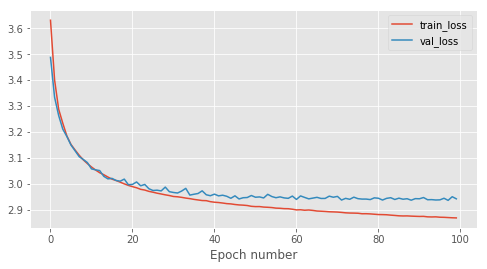

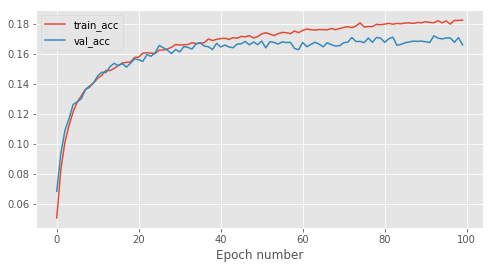

In [6]:
batch_size = 100
image_num_channels = 1
image_height = 28
image_width = 28
dim_reduction_idx = [2,2,2]
strides = [2,3,4]
dim_reduction_type = ['strided_convolution', 'dilated_convolution', 'max_pooling', 'avg_pooling']
num_filters = 64
num_layers = 4
experiment_name = []
for stride in strides:
    experiment_name.append("strided_convolution_maxpooling_{}".format(stride))
num_epochs = 100
weight_decay_coefficient = 1e-05
seed = 9112018
use_gpu = True

rng = np.random.RandomState(seed=seed)
train_data = data_providers.EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
val_data = data_providers.EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = data_providers.EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

for reduction_idx,experiment,stride in zip(dim_reduction_idx,experiment_name,strides):
    
    custom_conv_net = ConvolutionalNetwork(
        input_shape=(batch_size, image_num_channels, image_height, image_width),
        dim_reduction_type=dim_reduction_type[reduction_idx],
        num_output_classes=47, num_filters=num_filters, num_layers=num_layers, use_bias=True,stride=stride)

    conv_experiment = ExperimentBuilder(network_model=custom_conv_net,
                                    experiment_name=experiment,
                                    num_epochs=num_epochs,
                                    weight_decay_coefficient=weight_decay_coefficient,
                                    use_gpu=use_gpu,
                                    train_data=train_data, val_data=val_data, test_data=test_data)
    print(custom_conv_net)
    total_losses = conv_experiment.run_experiment()
    print('finish')
    plot_stats_in_graph(total_losses[0])